In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import root_pandas as rp
import uproot as ur
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ROOT
from analysis import analysis
import array
import matplotlib
#%matplotlib qt
matplotlib.rcParams['text.usetex'] = False
from scipy.stats import norm
from matplotlib import rc
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

Welcome to JupyROOT 6.22/02


# Start by determining cuts

Initialize analysis class with no cuts, keeping all events. Restrict extended virtual readout chip (VRC) to actual fiducial area of chip for accurate data/MC ratios

In [ ]:
a = analysis(E_cut = 0, recoils_only = False, fei4_restrict = False)

In [ ]:
LER_cont_inj = a.get_tpc_data_during_study_period("LER", "Cont_inj")
LER_decay = a.get_tpc_data_during_study_period("LER", "Decay")
HER_cont_inj = a.get_tpc_data_during_study_period("HER", "Cont_inj")
HER_decay = a.get_tpc_data_during_study_period("HER", "Decay")
Lumi_cont_inj = a.get_tpc_data_during_study_period("Lumi", "Cont_inj")
Lumi_decay = a.get_tpc_data_during_study_period("Lumi", "Decay")
Lumi = {}
HER = {}
LER = {}
Single_beam = {}
Lumi_all = {}
HER_all = {}
LER_all = {}
Single_beam_all = {}
data = {} #ALL DATA TOGETHER FOR CALIBRATION

MC = a.MC_data

for tpc in Lumi_decay.keys():
    Lumi_all[tpc] = Lumi_decay[tpc].append(Lumi_cont_inj[tpc])
    HER_all[tpc] = HER_decay[tpc].append(HER_cont_inj[tpc])
    LER_all[tpc] = LER_decay[tpc].append(LER_cont_inj[tpc])
    Single_beam_all[tpc] = LER_all[tpc].append(HER_all[tpc])
    data[tpc] = Lumi_all[tpc].append(Single_beam_all[tpc])
    #data[tpc] = Lumi_all[tpc]
    
    Lumi[tpc] = Lumi_cont_inj[tpc]
    #Lumi[tpc] = Lumi_all[tpc]
    HER[tpc] = HER_cont_inj[tpc]
    LER[tpc] = LER_cont_inj[tpc]
    Single_beam[tpc] = LER[tpc].append(HER[tpc])
    
    #Lumi[tpc] = Lumi_decay[tpc]
    #HER[tpc] = HER_decay[tpc]
    #LER[tpc] = LER_decay[tpc]
    #Single_beam[tpc] = LER[tpc].append(HER[tpc])
    
    Lumi[tpc].index = [i for i in range(0,len(Lumi[tpc]))]
    Single_beam[tpc].index = [i for i in range(0,len(Single_beam[tpc]))]
    data[tpc].index = [i for i in range(0,len(data[tpc]))]
    #MC[tpc] = MC[tpc].loc[(MC[tpc]['is_recoil']==1)]

### Tune xray veto using MC

In [4]:
E = np.linspace(0,20,101)
efficiency = {}
purity = {}
tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
pos = ['z=-5.6m', 'z=+6.6m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']
for tpc in tpcs:
    efficiency[tpc] = []
    purity[tpc]=[]
    for i in E: #is_reocil ==1 means events passed the cuts
        efficiency[tpc].append(MC[tpc].loc[(np.abs(MC[tpc]['PDG'])>1e9)&(MC[tpc]['is_recoil']==1)&(MC[tpc]['reco_energy']>i)]['ones'].sum()/MC[tpc].loc[np.abs(MC[tpc]['PDG'])>1e9]['ones'].sum())
        purity[tpc].append(MC[tpc].loc[(np.abs(MC[tpc]['PDG'])>1e9)&(MC[tpc]['reco_energy']>i)&(MC[tpc]['is_recoil']==1)]['ones'].sum()/MC[tpc].loc[(MC[tpc]['reco_energy']>i)&(MC[tpc]['is_recoil']==1)]['ones'].sum())

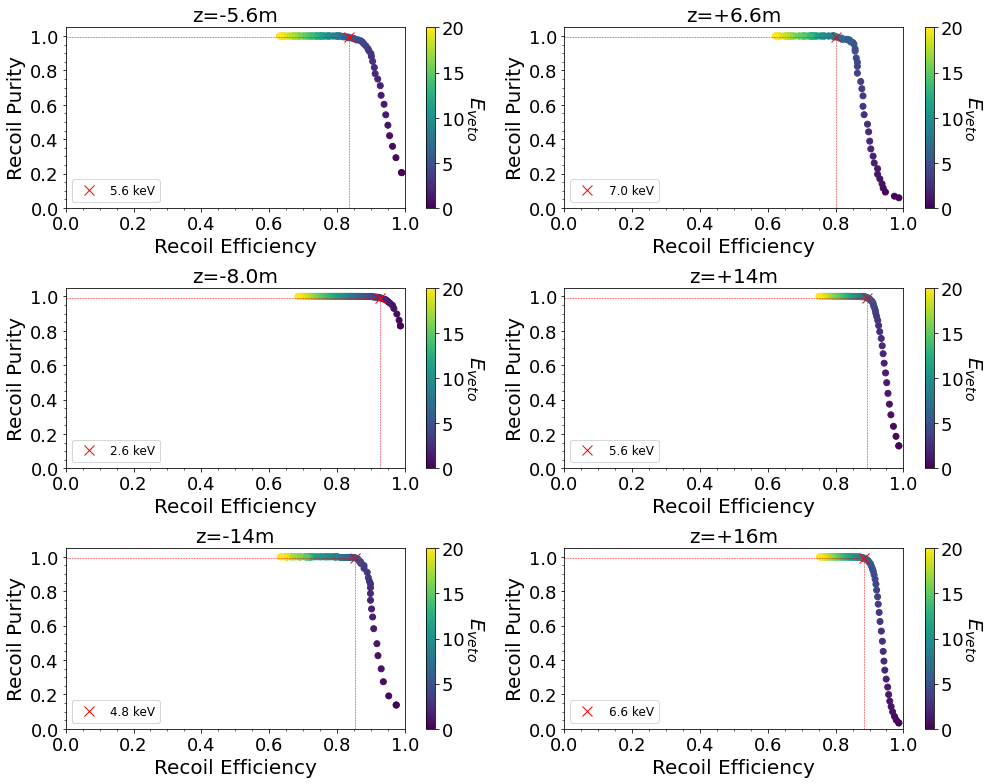

In [5]:
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (14,11))
i=1
pos = ['z=-5.6m', 'z=+6.6m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']
crit = {}
axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1], ax[2,0], ax[2,1]]
for tpc in tpcs:
    df = pd.DataFrame()
    df['E'] = E
    df['purity'] = purity[tpc]
    df['efficiency'] = efficiency[tpc]
    df['FOM'] = df['purity']
    #print(df)
    crit[tpc] = df.loc[df['FOM']>.99]['E'].min()
    loc = df.loc[df['E']==crit[tpc]].index.to_numpy()
    #plt.subplot(3,2,i)
    c=axs[i-1].scatter(efficiency[tpc],purity[tpc],c=E)#,norm=matplotlib.colors.LogNorm(vmin = 1, vmax = 20))
    axs[i-1].plot(df['efficiency'][loc],df['purity'][loc],'x',markersize = 10,color = 'red',label='%s keV'%(round(crit[tpc],2))) 
    axs[i-1].hlines(df['purity'][loc], 0,df['efficiency'][loc],linestyle='--',lw = 0.5, color = 'red') 
    axs[i-1].vlines(df['efficiency'][loc], 0,df['purity'][loc],linestyle='--',lw = 0.5, color = 'red') 
    plt.colorbar(c,ax=axs[i-1]).set_label(r'$E_{veto}$',rotation=270,labelpad=20)
    axs[i-1].set_xlabel('Recoil Efficiency')
    axs[i-1].set_ylabel('Recoil Purity')
    axs[i-1].set_xlim(0,1)
    axs[i-1].set_ylim(0,1.05)
    axs[i-1].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    axs[i-1].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i-1].yaxis.set_minor_locator(AutoMinorLocator())
    axs[i-1].set_title(pos[i-1])
    axs[i-1].legend(loc='lower left')
    i+=1
plt.tight_layout()
plt.show()

In [ ]:
x = np.linspace(0,20000,20001)
plt.figure(figsize = (12,12))
#xs = np.array([1200, 4000,10000])
#ys = np.array([7,50,280])
xs = np.array([1600,3000,15000])
ys = np.array([0,40,800])
fit = np.polyfit(xs,ys,2)
for i, tpc in enumerate(tpcs):
    plt.subplot(3,2,i+1)
    plt.plot(MC[tpc].loc[MC[tpc]['is_recoil']==0]['new_length'], MC[tpc].loc[MC[tpc]['is_recoil']==0]['reco_energy'],'o', markersize = 2, label = 'Not MC recoil')
    plt.plot(MC[tpc].loc[MC[tpc]['is_recoil']==1]['new_length'], MC[tpc].loc[MC[tpc]['is_recoil']==1]['reco_energy'],'o', markersize = 2, label = 'MC recoil')
    #plt.plot(MC[tpc].loc[MC[tpc]['PDG']==11]['new_length'], MC[tpc].loc[MC[tpc]['PDG']==11]['reco_energy'],'o', markersize = 2, label = 'Truth electron')
    #plt.plot(MC[tpc].loc[MC[tpc]['PDG']>1e9]['new_length'], MC[tpc].loc[MC[tpc]['PDG']>1e9]['reco_energy'],'o', markersize = 2, label = 'Truth recoil')
    plt.plot(fit[0]*x**2+fit[1]*x+fit[2])
    plt.xlim(0,4000)
    plt.ylim(0,60)
    plt.title(tpc)
    plt.legend()
    plt.grid()    
plt.tight_layout()


In [ ]:
x = np.linspace(0,20000,20001)
plt.figure(figsize = (12,12))
#xs = np.array([1200, 4000,10000])
#ys = np.array([7,50,280])
xs = np.array([1600,3000,15000])
ys = np.array([0,40,800])
fit = np.polyfit(xs,ys,2)
crit = {'palila': 9, 'tako': 4.6,'elepaio': 6.4, 'iiwi': 8.8,'nene': 5.6, 'humu': 6.6}
for i, tpc in enumerate(tpcs):
    if tpc == 'humu':
        xs = np.array([1600,3000,15000])
        ys = np.array([0,25,450])
        fit = np.polyfit(xs,ys,2)
    plt.subplot(3,2,i+1)
    plt.plot(data[tpc].loc[data[tpc]['is_recoil']==1]['new_length'], data[tpc].loc[data[tpc]['is_recoil']==1]['track_energy'],'o', markersize = 2)
    plt.plot(fit[0]*x**2+fit[1]*x+fit[2])
    plt.hlines(crit[tpc],0,2000, color = 'red')
    plt.xlim(0,8000)
    plt.ylim(0,200)
    plt.title(tpc)
    plt.grid()
plt.tight_layout()


In [ ]:
MC['iiwi'].loc[MC['iiwi']['reco_energy']>(fit[0]*MC['iiwi']['new_length']**2+fit[1]*MC['iiwi']['new_length']+fit[2])]

### Check EvL in data and MC

In [ ]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)

#original 'humu': np.array([1950, 3000, 20000]
x = {'iiwi': np.array([850, 2500, 15000]), 'nene': np.array([950, 2500, 16000]), 'humu': np.array([1950, 3000, 20000]),
    'palila': np.array([900, 2350, 15000]), 'tako': np.array([1400, 2500, 15000]), 'elepaio': np.array([1050, 2500, 15000])}
y = np.array([6,20,800])
cut = {}
plt.figure(figsize=(16,16))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=.6)
xmax = 15000
ymax = 600
i = 1
pos = ['z=-5.6m', 'z=+6.6m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']
crit = {'palila': 6.8, 'iiwi': 8, 'tako': 4, 'nene': 7.8, 'elepaio': 7.4, 'humu': 9}
for tpc in ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']:
    cut[tpc] = np.polyfit(x[tpc],y,2)
    x_plt = np.linspace(0,xmax,xmax+1)
    plt.subplot(3,2,i)
    plt.plot(data[tpc]['new_length'], data[tpc]['track_energy'],'o', markersize = 1, alpha = 0.5, label = 'data')
    #plt.plot(Lumi[tpc]['new_length'], Lumi[tpc]['track_energy'],'o', markersize = 1, label = 'Data')
   
    #plt.plot(Single_beam_all[tpc]['new_length'], Single_beam_all[tpc]['track_energy'],'o', markersize = 1, label = 'Data', color = 'blue')
    
    #plt.plot(MC[tpc].loc[(MC[tpc]['PDG']==1000020030) & (MC[tpc]['VRC_id']>0)]['new_length'],MC[tpc].loc[(MC[tpc]['PDG']==1000020030)& (MC[tpc]['VRC_id']>0)]['reco_energy'],'o',markersize = 4, alpha = 0.5,label = 'MC_He')
    #plt.plot(MC[tpc].loc[(MC[tpc]['PDG']<1000020030) & (MC[tpc]['PDG']!=11)& (MC[tpc]['VRC_id']>0)]['new_length'],MC[tpc].loc[(MC[tpc]['PDG']<1000020030) & (MC[tpc]['PDG']!=11)& (MC[tpc]['VRC_id']>0)]['reco_energy'],'o',markersize = 4, alpha = 0.5,label = 'MC_other')
    #plt.plot(MC[tpc].loc[(MC[tpc]['PDG']>=1000060110)& (MC[tpc]['VRC_id']>0)]['new_length'],MC[tpc].loc[(MC[tpc]['PDG']>=1000060110)& (MC[tpc]['VRC_id']>0)]['reco_energy'],'o',markersize = 4, alpha = 0.5,label = 'MC_CO')
    plt.plot(MC[tpc].loc[np.abs(MC[tpc]['PDG'])>1e9]['new_length'],MC[tpc].loc[np.abs(MC[tpc]['PDG'])>1e9]['reco_energy'],'o',markersize = 2, alpha = 0.5,label = 'MC_recoil',color = 'tab:green')
    plt.plot(MC[tpc].loc[MC[tpc]['PDG']==11]['new_length'],MC[tpc].loc[MC[tpc]['PDG']==11]['reco_energy'],'o',markersize = 2, alpha = 0.5,label = 'MC_x-ray',color = 'magenta')
    x_crit = 0
    for val in x_plt:
        if np.abs(cut[tpc][0]*val**2+cut[tpc][1]*val+cut[tpc][2] - crit[tpc]) < np.abs(cut[tpc][0]*x_crit**2+cut[tpc][1]*x_crit+cut[tpc][2] - crit[tpc]):
            x_crit = val
    x_plt_new = np.linspace(x_crit,xmax,100000)
    plt.plot(x_plt_new, cut[tpc][0]*x_plt_new**2+cut[tpc][1]*x_plt_new+cut[tpc][2], '--', lw = 2, color = 'black')
    plt.hlines(crit[tpc],0,x_crit, linestyle = '--', lw=2, color = 'black', label = 'Recoil boundary')
    plt.title(pos[i-1])
    
    legend_elements = [Line2D([0], [0], marker='o', color='white', label='Experimental Data',
                          markerfacecolor='tab:blue', markersize=6),
                   Line2D([0], [0], marker='o', color='white', label='MC He-recoil',
                          markerfacecolor='tab:orange', markersize=12, alpha = 0.5),
                      Line2D([0], [0], marker='o', color='white', label='MC C/O-recoil',
                          markerfacecolor='tab:red', markersize=12, alpha = 0.5),
                      Line2D([0], [0], marker='o', color='white', label='MC Other',
                          markerfacecolor='tab:green', markersize=12, alpha = 0.5),
                      Line2D([0], [0], marker='o', color='white', label='MC X-ray',
                          markerfacecolor='magenta', markersize=12, alpha = 0.5),
                      Line2D([0], [0], color='black', linestyle = '--',  lw=2, label='Recoil Boundary Line')]
    
    legend_elements2 = [Line2D([0], [0], marker='o', color='white', label='Lumi Study Data',
                          markerfacecolor='red', markersize=6),
                        Line2D([0], [0], marker='o', color='white', label='Single Beam Study Data',
                          markerfacecolor='blue', markersize=6),
                       Line2D([0], [0], color='black', linestyle = '--',  lw=2, label='Recoil Boundary Line')]
    #if i == 1:
    #    plt.legend(handles = legend_elements, loc='upper center', bbox_to_anchor=(1.05, 1.5),
    #      ncol=3, fancybox=True, shadow=True)
    #    #plt.legend(handles = legend_elements2, loc='upper center', bbox_to_anchor=(1.05, 1.5), fancybox=True, ncol = 2, shadow=True)
    plt.legend()
    plt.grid()
    plt.ylim(0,ymax)
    plt.xlim(0,xmax)
    plt.ylabel('Energy [keV]')
    plt.xlabel(r'Length [$\mu$m]')
    i+=1
#plt.tight_layout()
plt.show()

In [ ]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)

#original 'humu': np.array([1950, 3000, 20000]
x = {'iiwi': np.array([850, 2500, 15000]), 'nene': np.array([950, 2500, 16000]), 'humu': np.array([1950, 3000, 20000]),
    'palila': np.array([900, 2350, 15000]), 'tako': np.array([1400, 2500, 15000]), 'elepaio': np.array([1050, 2500, 15000])}
y = np.array([6,20,800])
cut = {}
plt.figure(figsize=(20,7))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=.6)
xmax = 5000
ymax = 30
nbinsx = int(xmax/50)
nbinsy = int(ymax*2)
pos = ['z=-5.6m', 'z=+6.6m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']
#crit = {'palila': 9.0, 'iiwi': 8.8, 'tako': 4.6, 'nene': 5.6, 'elepaio': 6.4, 'humu': 6.4}
crit = {'palila': 6.8, 'iiwi': 8, 'tako': 4, 'nene': 7.8, 'elepaio': 7.4, 'humu': 9}
for tpc in ['nene']:
    plt.subplot(1,2,1)
    cut[tpc] = np.polyfit(x[tpc],y,2)
    x_plt = np.linspace(0,xmax,xmax+1)
    #plt.plot(data[tpc]['new_length'], data[tpc]['track_energy'],'o', markersize = 1, alpha = 0.5, label = 'data')
    #plt.plot(Lumi[tpc]['new_length'], Lumi[tpc]['track_energy'],'o', markersize = 1, label = 'Data')
   
    #plt.plot(Single_beam_all[tpc]['new_length'], Single_beam_all[tpc]['track_energy'],'o', markersize = 1, label = 'Data', color = 'blue')
    
    plt.plot(MC[tpc].loc[(MC[tpc]['PDG']>1e9) & (MC[tpc]['VRC_id']==5)]['new_length'],MC[tpc].loc[(MC[tpc]['PDG']>1e9)& (MC[tpc]['VRC_id']==5)]['reco_energy'],'o',color = 'cyan', markeredgecolor = 'k', markersize = 4, alpha = 1,label = 'Truth MC neutrons',zorder = 1e9)
    plt.plot(MC[tpc].loc[MC[tpc]['PDG']==11]['new_length'],MC[tpc].loc[MC[tpc]['PDG']==11]['reco_energy'],'o',markersize = 2, alpha = 0.5,label = 'Truth MC x-rays',color = 'magenta')
    x_crit = 0
    for val in x_plt:
        if np.abs(cut[tpc][0]*val**2+cut[tpc][1]*val+cut[tpc][2] - crit[tpc]) < np.abs(cut[tpc][0]*x_crit**2+cut[tpc][1]*x_crit+cut[tpc][2] - crit[tpc]):
            x_crit = val
    x_plt_new = np.linspace(x_crit,xmax,100000)
    plt.plot(x_plt_new, cut[tpc][0]*x_plt_new**2+cut[tpc][1]*x_plt_new+cut[tpc][2], '--', lw = 4, color = 'red')
    plt.hlines(crit[tpc],0,x_crit, linestyle = '--', lw=4, color = 'red', label = 'Recoil boundary')
    #plt.title(pos[i-1])
    legend_elements = [
                      Line2D([0], [0], marker='o', color='white', label='Truth MC neutron',
                          markerfacecolor='tab:cyan', markeredgecolor = 'k', markersize=8),
                      Line2D([0], [0], marker='o', color='white', label='Truth MC x-ray',
                          markerfacecolor='magenta', markersize=8),
                      Line2D([0], [0], color='red', linestyle = '--',  lw=4, label='Recoil boundary')]
    plt.legend(handles = legend_elements, loc='right', fancybox=True, shadow=True)
        #plt.legend(handles = legend_elements2, loc='upper center', bbox_to_anchor=(1.05, 1.5), fancybox=True, ncol = 2, shadow=True)
    plt.grid()
    plt.ylim(0,ymax)
    plt.xlim(0,xmax)
    plt.title('Simulation')
    plt.ylabel('Energy [keV]')
    plt.xlabel(r'Length [$\mu$m]')
    plt.subplot(1,2,2)
    plt.title('Data')
    cmap = plt.cm.viridis
    cmap.set_under(color='white')
    aa,bb,cc,dd = plt.hist2d(data[tpc]['new_length'], data[tpc]['track_energy'],bins = [nbinsx,nbinsy], range=([0,xmax],[0,ymax]), norm = matplotlib.colors.LogNorm(vmin=1, vmax=100))
    plt.colorbar(dd).set_label('Events per bin', rotation = 270, labelpad = 30)
    plt.ylabel('Energy [keV]')
    plt.xlabel(r'Length [$\mu$m]')
    plt.plot(x_plt_new, cut[tpc][0]*x_plt_new**2+cut[tpc][1]*x_plt_new+cut[tpc][2], '--', lw = 4, color = 'red')
    plt.hlines(crit[tpc],0,x_crit, linestyle = '--', lw=4, color = 'red', label = 'Recoil boundary')
    plt.legend(loc = 'upper right', fancybox=True, shadow=True)
    plt.grid()
#plt.savefig('/home/jeff/evl_datamc.jpg',dpi = 300, bbox_inches='tight')
#plt.tight_layout()
plt.show()

### Generate histograms to determine purity of xray veto cuts using data

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

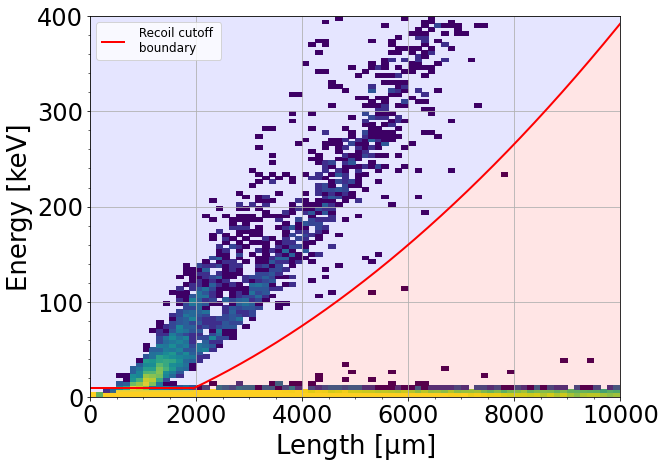

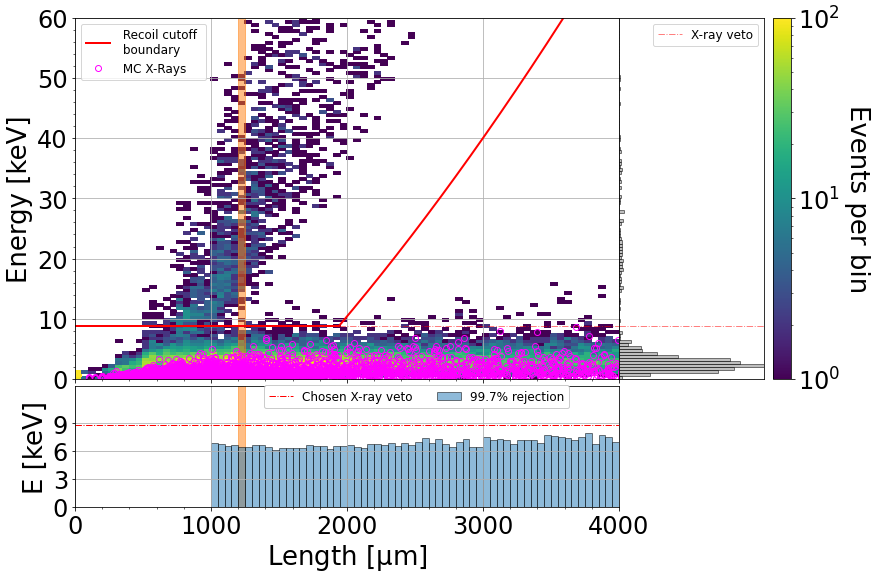

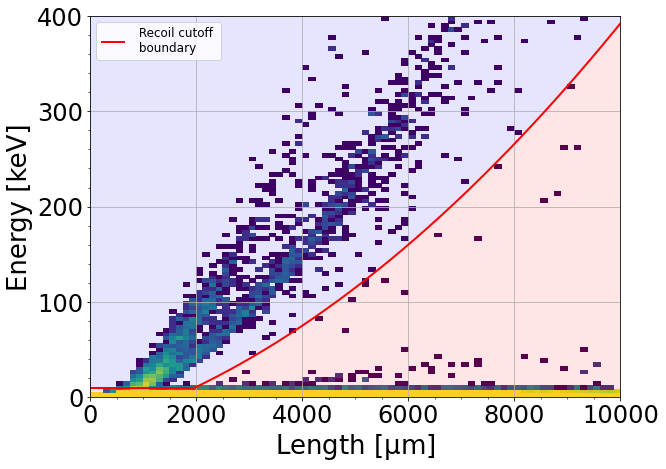

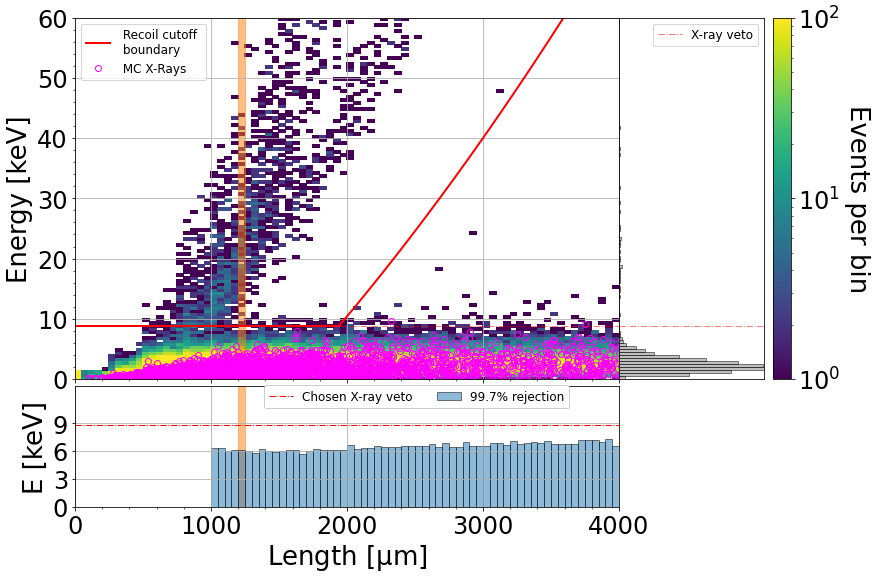

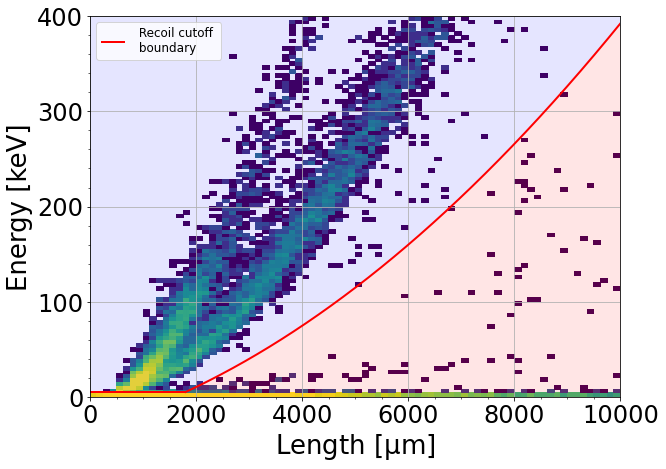

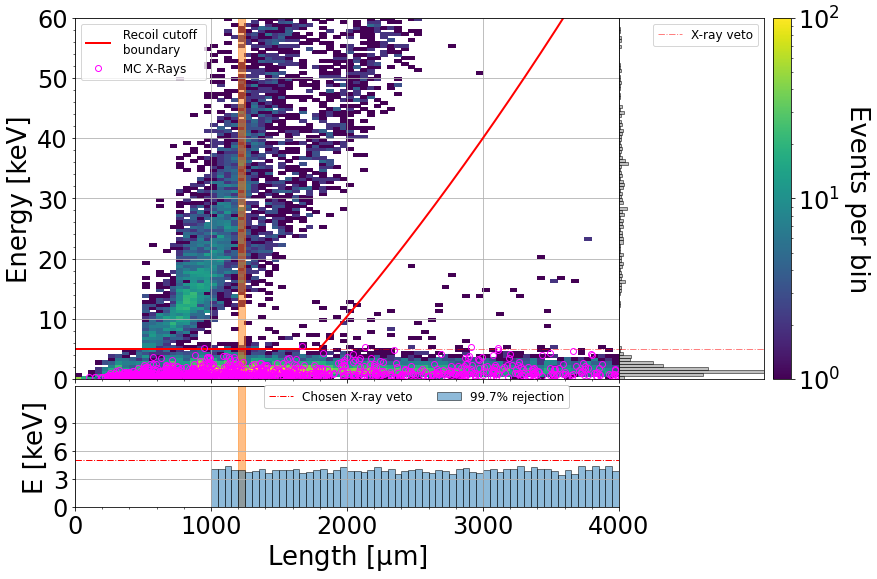

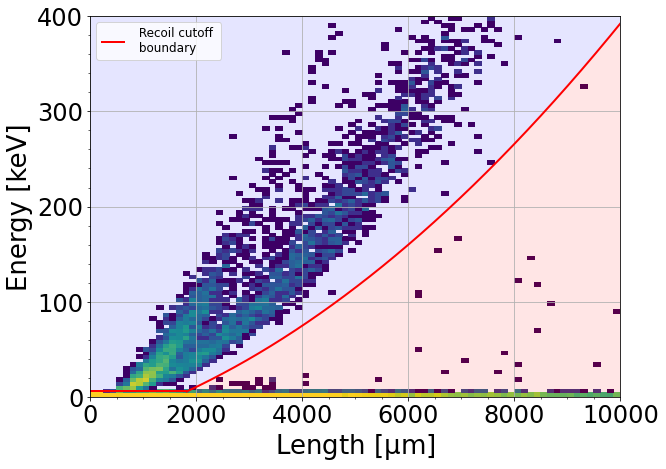

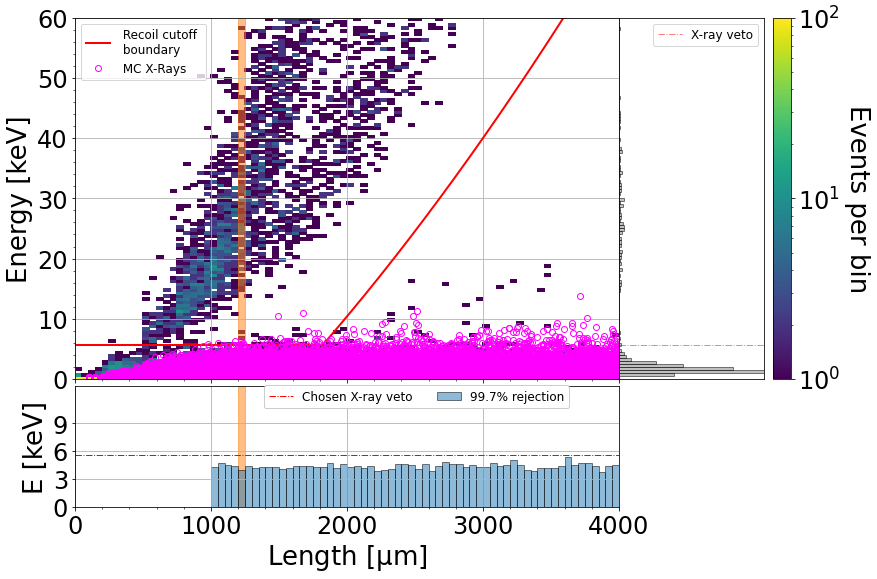

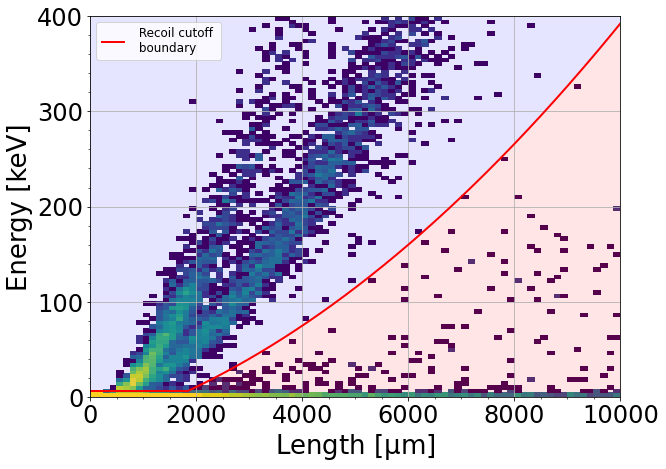

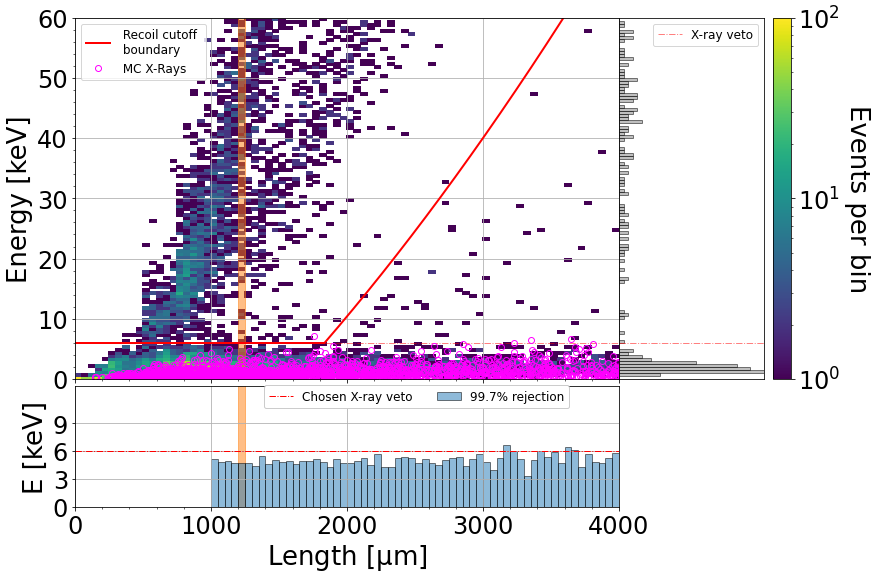

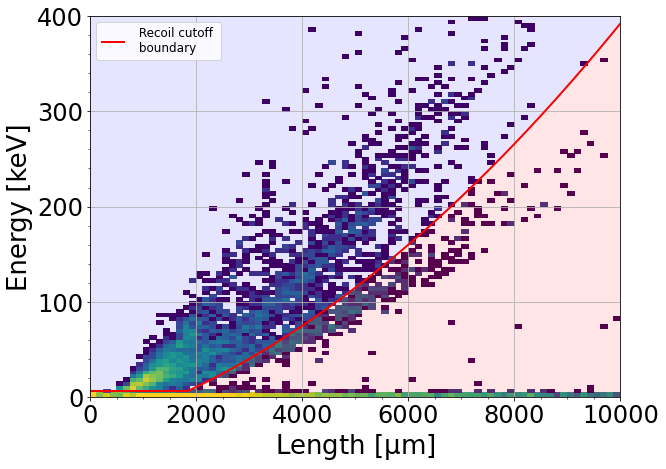

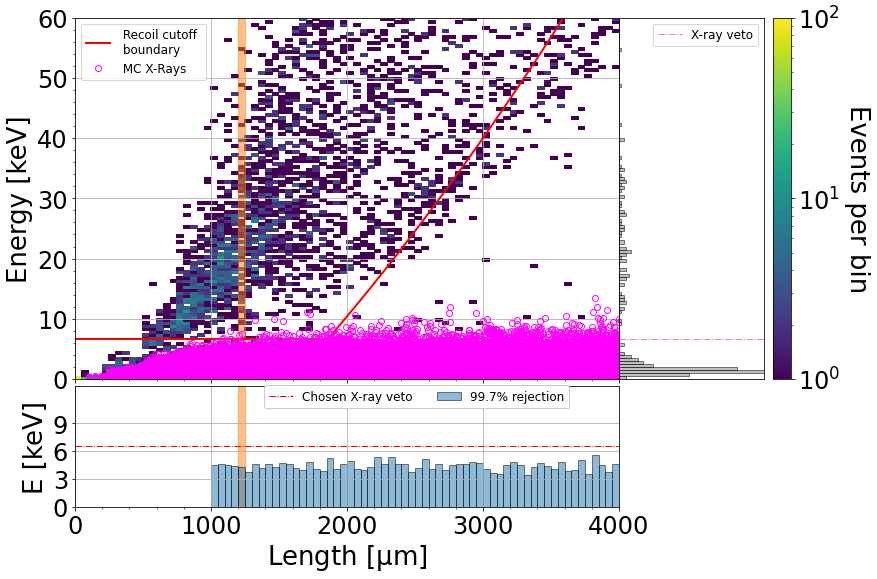

In [6]:
import warnings
matplotlib.rcParams['mathtext.default'] = 'regular'
warnings.filterwarnings("ignore") #suppress matplotlib warnings

# DEFINE HISTS
fig = plt.figure(figsize = (15,15))
cmap = plt.cm.viridis
cmap.set_under(color='white')
    
xm = 10000
ym = 400
nbinsx = int(xm/50)
nbinsy = int(ym*2)

xedges = {}
yedges = {}
bins = {}
h = {}
image = {}

for tpc in ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']:
    h[tpc + '_uncor'], xedges[tpc], yedges[tpc], image[tpc + '_uncor'] = plt.hist2d(data[tpc]['length'], data[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
    bins[tpc] = 0.5*(yedges[tpc][1:]+yedges[tpc][:-1])
plt.clf()

# CODE BELOW CREATES PLOTTED HISTOGRAMS
fig = plt.figure(figsize = (15,15))
cmap = plt.cm.viridis
cmap.set_under(color='white')
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)

#thresh = 5 #VETO THRESHOLD

xm = 10000
ym = 400
nbinsx = int(xm/50)
nbinsy = int(ym*2)


veto = {}
length = {}
sigmas = {}
e_leak = {}
veto_MC = {}
sigmas_MC = {}
e_leak_MC = {}
#cut = {}
x_crit = {}

#x = {'iiwi': np.array([850, 2500, 15000]), 'nene': np.array([950, 2500, 16000]), 'humu': np.array([1950, 3000, 20000]),
#    'palila': np.array([900, 2350, 15000]), 'tako': np.array([1400, 2500, 15000]), 'elepaio': np.array([1050, 2500, 15000])}
#y = np.array([6,20,800])
x = np.array([1600,3000,15000])
y = np.array([0,40,800])

x_plt = np.linspace(0,10000,10001)
crit = {'palila': 8.8, 'iiwi': 8.8, 'tako': 5, 'nene': 5.6, 'elepaio': 6, 'humu': 6.6}
#crit = {'palila': 9.0, 'iiwi': 8.8, 'tako': 4.6, 'nene': 5.6, 'elepaio': 6.4, 'humu': 6.4}
pos = {'palila': 'z=-5.6m', 'iiwi': 'z=+6.6m', 'tako': 'z=-8.0m', 'nene': 'z=+14m', 'elepaio': 'z=-14m', 'humu': 'z=+16m'}
for tpc in ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']:
    veto[tpc] = []
    length[tpc] = []
    sigmas[tpc] = []
    e_leak[tpc] = []
    veto_MC[tpc] = []
    sigmas_MC[tpc] = []
    e_leak_MC[tpc] = []
    i=0
    for loc in range(20,int(nbinsx*0.4)+1):
        low = bins[tpc][loc]*100-25
        high = bins[tpc][loc]*100+25
        cut = np.polyfit(x,y,2)
        x_crit[tpc] = 0
        for val in x_plt:
            if np.abs(cut[0]*val**2+cut[1]*val+cut[2] - crit[tpc]) < np.abs(cut[0]*x_crit[tpc]**2+cut[1]*x_crit[tpc]+cut[2] - crit[tpc]):
                x_crit[tpc] = val
        #if loc >= (x_crit[tpc]/xm*nbinsx):
        #    tmp = data[tpc].loc[(data[tpc]['new_length']>low) & (data[tpc]['new_length']<=high) & (data[tpc]['track_energy'] < cut[0]*data[tpc]['new_length']**2+cut[1]*data[tpc]['new_length']+cut[2])]
        #else:
        
        ### DATA ###
        tmp = data[tpc].loc[(data[tpc]['new_length']>low) & (data[tpc]['new_length']<=high) & (data[tpc]['track_energy'] < crit[tpc])]
        length[tpc].append(bins[tpc][loc]*100)
        veto[tpc].append(tmp['track_energy'].mean() + 3*tmp['track_energy'].std())
        sigmas[tpc].append((crit[tpc]-tmp['track_energy'].mean())/tmp['track_energy'].std())
        if loc >= (x_crit[tpc]/xm*nbinsx):
            e_leak[tpc].append((1-norm.cdf(sigmas[tpc][i]))*len(data[tpc].loc[(data[tpc]['track_energy'] < cut[0]*data[tpc]['new_length']**2+cut[1]*data[tpc]['new_length']+cut[2])]))
        else:
            e_leak[tpc].append((1-norm.cdf(sigmas[tpc][i]))*len(data[tpc].loc[(data[tpc]['track_energy'] < crit[tpc])]))
        
        ### MC ###
        tmp_MC = MC[tpc].loc[(MC[tpc]['new_length']>low) & (MC[tpc]['new_length']<=high) & (MC[tpc]['reco_energy'] < crit[tpc])]
        veto_MC[tpc].append(tmp_MC['reco_energy'].mean() + 3*tmp_MC['reco_energy'].std())
        sigmas_MC[tpc].append((crit[tpc]-tmp_MC['reco_energy'].mean())/tmp_MC['reco_energy'].std())
        #if loc >= (x_crit[tpc]/xm*nbinsx):
        #    e_leak_MC[tpc].append((1-norm.cdf(sigmas_MC[tpc][i]))*len(MC[tpc].loc[(MC[tpc]['reco_energy'] < cut[0]*((MC[tpc]['new_length']))**2+cut[1]*(MC[tpc]['new_length'])+cut[2])]))
        #else:
        e_leak_MC[tpc].append((1-norm.cdf(sigmas_MC[tpc][i]))*len(MC[tpc].loc[(MC[tpc]['reco_energy'] < crit[tpc])]))#cut[0]*((MC[tpc]['new_length']))**2+cut[1]*(MC[tpc]['new_length'])+cut[2])]))
        
        i+=1

#def gauss(x,mu,sigma,A): # for gaussian fit
#    return A*exp(-(x-mu)**2/2/sigma**2)

for tpc in ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']:
    fig, ax0 = plt.subplots(figsize=(9.5,7))
    #ax0.set_title(pos[tpc])
    g,h,k,l = ax0.hist2d(data[tpc]['new_length'], data[tpc]['track_energy'], bins = (80,100), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=100))
    #plt.colorbar(l).set_label('Events per bin', rotation = 270, labelpad = 30)
    ax0.set_ylabel("Energy [keV]")
    ax0.set_xlabel(r'Length [$\mu$m]')
    ax0.yaxis.set_minor_locator(AutoMinorLocator())
    ax0.xaxis.set_minor_locator(AutoMinorLocator())
    x_plt = np.linspace(x_crit[tpc],10000,10001)
    ax0.plot(x_plt, cut[0]*x_plt**2 + cut[1]*x_plt + cut[2], '-', color = 'red', lw=2)
    ax0.fill_between(x_plt, 0, cut[0]*x_plt**2 + cut[1]*x_plt + cut[2], '-', color = 'red', lw=0, alpha = 0.1)
    ax0.fill_between(x_plt, cut[0]*x_plt**2 + cut[1]*x_plt + cut[2], 400, '-', color = 'blue', lw=0, alpha = 0.1)
    ax0.hlines(crit[tpc],0,x_crit[tpc], color = 'red', lw=2, linestyle = '-', label = ' Recoil cutoff \n boundary')
    ax0.fill_between(np.linspace(0,x_crit[tpc],1434), 0, 6, '-', color = 'red', lw=0, alpha = 0.1)
    ax0.fill_between(np.linspace(0,x_crit[tpc],1434), 6, 400, '-', color = 'blue', lw=0, alpha = 0.1)
    #ax0.hlines(8,1427,2500, color = 'red', lw=1, linestyle = '-.', alpha = 0.5)
    plt.grid()
    plt.legend(loc = 'upper left')
    #plt.savefig('evl.jpg')
    for loc in range(24,25):
        fig, ax = plt.subplots(2,2, figsize = (13,9), gridspec_kw={'hspace': 0.03, 'wspace': 0, 'width_ratios': [3, 1], 'height_ratios': [3,1]})
        h1, xedge, yedge, image1 = ax[0,0].hist2d(data[tpc]['new_length'], data[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=100))
        plt.colorbar(image1, ax=[ax[0,1]]).set_label(r'Events per bin', rotation = 270, labelpad = 30)
        bin = 0.5*(yedge[1:]+yedge[:-1])
        ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].set_xticklabels([])
        x_plt = np.linspace(x_crit[tpc],10000,10001)
        ax[0,0].plot(x_plt,cut[0]*x_plt**2+cut[1]*x_plt+cut[2], color = 'red', lw=2, linestyle = '-', label = ' Recoil cutoff \n boundary')
        ax[0,0].hlines(crit[tpc],0,x_crit[tpc], color = 'red', lw=2)
        ax[0,0].hlines(crit[tpc],x_crit[tpc],xm, color = 'red', lw=1, linestyle = '-.', alpha = 0.5)
        ax[0,0].plot(MC[tpc].loc[MC[tpc]['PDG']==11]['new_length'], MC[tpc].loc[MC[tpc]['PDG']==11]['reco_energy'], 'o', color = 'magenta', fillstyle = 'none', label = ' MC X-Rays')
        ax[0,0].fill_between(np.array([xedge[loc], xedge[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange') 
        ax[0,0].set_ylim(0,60)
        ax[0,0].set_xlim(0,xm*.4)
        ax[0,0].set_ylabel(r'Energy [keV]')
        ax[0,0].set_xlabel(r'Length [$\mu$m]')
        ax[0,0].legend(loc = 'upper left')
        ax[0,0].grid(which='major')
        ax[0,1].barh(bin, h1[loc], height = ym/nbinsy, alpha = 0.5, color = 'gray',edgecolor = 'black')
        ax[0,1].hlines(crit[tpc],0,h1[loc].max(), color = 'red', linestyle = '-.', lw=1, alpha =0.5, label = 'X-ray veto')
        ax[0,1].set_yticks([])
        ax[0,1].set_xticks([])
        ax[0,1].set_ylim(0,60)
        ax[0,1].set_xlim(0,h1[loc].max())
        ax[0,1].legend()
        ax[1,0].bar(length[tpc],veto[tpc],width=xedge[loc+1]-xedge[loc], label = '99.7% rejection',edgecolor = 'black', alpha = 0.5)
        #ax[1,0].plot(length[tpc],veto_MC[tpc], 'o', label = 'Pred. x-ray veto [MC]', markersize = 2)
        ax[1,0].hlines(crit[tpc],0,xm, linestyle = '-.', color = 'red', lw = 1, label = 'Chosen X-ray veto')
        ax[1,0].fill_between(np.array([xedge[loc], xedge[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[1,0].set_xlim(0,xm*.4)
        ax[1,0].set_ylim(0,13)
        ax[1,0].set_yticks([0,3,6,9])
        ax[1,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].set_xlabel(r'Length [$\mu$m]')
        ax[1,0].set_ylabel('E [keV]')
        ax[1,0].legend(loc='lower right', bbox_to_anchor=(0.92, 0.77),ncol = 3,framealpha = 1)
        ax[1,0].grid(which = 'major')
            
        fig.delaxes(ax[1,1])
        #plt.savefig(tpc + '_xray_veto_threshold.jpg')


In [ ]:
# DEFINE HISTS
fig = plt.figure(figsize = (15,15))
cmap = plt.cm.inferno
cmap.set_under(color='white')
    
xm = 10000
ym = 400
nbinsx = int(xm/50)
nbinsy = int(ym*2)

xedges = {}
yedges = {}
bins = {}
h = {}
image = {}

for tpc in ['tako']:
    h[tpc + '_uncor'], xedges[tpc], yedges[tpc], image[tpc + '_uncor'] = plt.hist2d(data[tpc]['length'], data[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
    bins[tpc] = 0.5*(yedges[tpc][1:]+yedges[tpc][:-1])
plt.clf()

# CODE BELOW CREATES PLOTTED HISTOGRAMS
fig = plt.figure(figsize = (15,15))
cmap = plt.cm.viridis
cmap.set_under(color='white')
plt.rc('legend', fontsize=16)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)

#thresh = 5 #VETO THRESHOLD

xm = 10000
ym = 400
nbinsx = int(xm/50)
nbinsy = int(ym*2)


veto = {}
length = {}
sigmas = {}
e_leak = {}
veto_MC = {}
sigmas_MC = {}
e_leak_MC = {}
cut = {}
x_crit = {}

x = {'iiwi': np.array([850, 2500, 15000]), 'nene': np.array([950, 2500, 16000]), 'humu': np.array([1950, 3000, 20000]),
    'palila': np.array([900, 2350, 15000]), 'tako': np.array([1400, 2500, 15000]), 'elepaio': np.array([1050, 2500, 15000])}
y = np.array([6,20,800])

x_plt = np.linspace(0,10000,10001)
crit = {'palila': 9, 'iiwi': 9, 'tako': 5, 'nene': 5.6, 'elepaio': 6, 'humu': 6.2}
#crit = {'palila': 9.0, 'iiwi': 8.8, 'tako': 4.6, 'nene': 5.6, 'elepaio': 6.4, 'humu': 6.4}
pos = {'palila': 'z=-5.6m', 'iiwi': 'z=+6.6m', 'tako': 'z=-8.0m', 'nene': 'z=+14m', 'elepaio': 'z=-14m', 'humu': 'z=+16m'}
for tpc in ['tako']:
    veto[tpc] = []
    length[tpc] = []
    sigmas[tpc] = []
    e_leak[tpc] = []
    veto_MC[tpc] = []
    sigmas_MC[tpc] = []
    e_leak_MC[tpc] = []
    i=0
    for loc in range(20,int(nbinsx*0.4)+1):
        low = bins[tpc][loc]*100-25
        high = bins[tpc][loc]*100+25
        cut[tpc] = np.polyfit(x[tpc],y,2)
        x_crit[tpc] = 0
        for val in x_plt:
            if np.abs(cut[tpc][0]*val**2+cut[tpc][1]*val+cut[tpc][2] - crit[tpc]) < np.abs(cut[tpc][0]*x_crit[tpc]**2+cut[tpc][1]*x_crit[tpc]+cut[tpc][2] - crit[tpc]):
                x_crit[tpc] = val
        #if loc >= (x_crit[tpc]/xm*nbinsx):
        #    tmp = data[tpc].loc[(data[tpc]['new_length']>low) & (data[tpc]['new_length']<=high) & (data[tpc]['track_energy'] < cut[tpc][0]*data[tpc]['new_length']**2+cut[tpc][1]*data[tpc]['new_length']+cut[tpc][2])]
        #else:
        
        ### DATA ###
        tmp = data[tpc].loc[(data[tpc]['new_length']>low) & (data[tpc]['new_length']<=high) & (data[tpc]['track_energy'] < crit[tpc])]
        length[tpc].append(bins[tpc][loc]*100)
        veto[tpc].append(tmp['track_energy'].mean() + 3*tmp['track_energy'].std())
        sigmas[tpc].append((crit[tpc]-tmp['track_energy'].mean())/tmp['track_energy'].std())
        #if loc >= (x_crit[tpc]/xm*nbinsx):
        #    e_leak[tpc].append((1-norm.cdf(sigmas[tpc][i]))*len(data[tpc].loc[(data[tpc]['track_energy'] < cut[tpc][0]*data[tpc]['new_length']**2+cut[tpc][1]*data[tpc]['new_length']+cut[tpc][2])]))
        #else:
        e_leak[tpc].append((1-norm.cdf(sigmas[tpc][i]))*len(data[tpc].loc[(data[tpc]['track_energy'] < crit[tpc])]))
        
        ### MC ###
        tmp_MC = MC[tpc].loc[(MC[tpc]['new_length']>low) & (MC[tpc]['new_length']<=high) & (MC[tpc]['reco_energy'] < crit[tpc])]
        veto_MC[tpc].append(tmp_MC['reco_energy'].mean() + 3*tmp_MC['reco_energy'].std())
        sigmas_MC[tpc].append((crit[tpc]-tmp_MC['reco_energy'].mean())/tmp_MC['reco_energy'].std())
        #if loc >= (x_crit[tpc]/xm*nbinsx):
        #    e_leak_MC[tpc].append((1-norm.cdf(sigmas_MC[tpc][i]))*len(MC[tpc].loc[(MC[tpc]['reco_energy'] < cut[tpc][0]*((MC[tpc]['new_length']))**2+cut[tpc][1]*(MC[tpc]['new_length'])+cut[tpc][2])]))
        #else:
        e_leak_MC[tpc].append((1-norm.cdf(sigmas_MC[tpc][i]))*len(MC[tpc].loc[(MC[tpc]['reco_energy'] < crit[tpc])]))#cut[tpc][0]*((MC[tpc]['new_length']))**2+cut[tpc][1]*(MC[tpc]['new_length'])+cut[tpc][2])]))
        
        i+=1

#def gauss(x,mu,sigma,A): # for gaussian fit
#    return A*exp(-(x-mu)**2/2/sigma**2)

for tpc in ['tako']:
    #fig, ax0 = plt.subplots(figsize=(9.5,7))
    #ax0.set_title(pos[tpc])
    #g,h,k,l = ax0.hist2d(data[tpc]['new_length'], data[tpc]['track_energy'], bins = (80,100), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=100))
    #plt.colorbar(l).set_label('Events per bin', rotation = 270, labelpad = 30)
    #ax0.set_ylabel("Energy [keV]")
    #ax0.set_xlabel(r'Length [$\mu$m]')
    #ax0.yaxis.set_minor_locator(AutoMinorLocator())
    #ax0.xaxis.set_minor_locator(AutoMinorLocator())
    x_plt = np.linspace(x_crit[tpc],20000,20001)
    #ax0.plot(x_plt, cut[tpc][0]*x_plt**2 + cut[tpc][1]*x_plt + cut[tpc][2], '-', color = 'red', lw=2)
    #ax0.fill_between(x_plt, 0, cut[tpc][0]*x_plt**2 + cut[tpc][1]*x_plt + cut[tpc][2], '-', color = 'red', lw=0, alpha = 0.1)
    #ax0.fill_between(x_plt, cut[tpc][0]*x_plt**2 + cut[tpc][1]*x_plt + cut[tpc][2], 400, '-', color = 'blue', lw=0, alpha = 0.1)
    #ax0.hlines(crit[tpc],0,x_crit[tpc], color = 'red', lw=2, linestyle = '-', label = ' Recoil cutoff \n boundary')
    #ax0.fill_between(np.linspace(0,x_crit[tpc],1434), 0, 6, '-', color = 'red', lw=0, alpha = 0.1)
    #ax0.fill_between(np.linspace(0,x_crit[tpc],1434), 6, 400, '-', color = 'blue', lw=0, alpha = 0.1)
    #ax0.hlines(8,1427,2500, color = 'red', lw=1, linestyle = '-.', alpha = 0.5)
    #plt.grid()
    #plt.legend(loc = 'upper left')
    #plt.savefig('evl.jpg')
    for loc in range(24,25):
        fig, ax = plt.subplots(2,4, figsize = (24,10), gridspec_kw={'hspace': 0.03, 'wspace': 0, 'width_ratios': [3, 0.7, 3, 1], 'height_ratios': [3,1]})
        #g,h,k,l = ax[0,0].hist2d(data[tpc]['new_length'], data[tpc]['track_energy'], bins = (80,100), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=100), cmap = cmap)
        ax[0,0].plot(x_plt, cut[tpc][0]*x_plt**2 + cut[tpc][1]*x_plt + cut[tpc][2], '-', color = 'red', lw=4,zorder = 1e9-1)
        a#x[0,2].plot(MC[tpc].loc[(MC[tpc]['PDG']==1000020030) & (MC[tpc]['VRC_id']>0)]['new_length'],MC[tpc].loc[(MC[tpc]['PDG']==1000020030)& (MC[tpc]['VRC_id']>0)]['reco_energy'],'o',markersize = 6, color = 'red', alpha = 1,label = 'MC He-recoils')
        #ax[0,0].plot(MC[tpc].loc[(MC[tpc]['PDG']<1000020030) & (MC[tpc]['PDG']!=11)& (MC[tpc]['VRC_id']>0)]['new_length'],MC[tpc].loc[(MC[tpc]['PDG']<1000020030) & (MC[tpc]['PDG']!=11)& (MC[tpc]['VRC_id']>0)]['reco_energy'],'o',markersize = 4, alpha = 0.5,label = 'MC Other')
        ax[0,0].text(17000, 46*1000/60,'(i)',size=32)
        ax[0,0].set_ylabel(r'Energy [keVee]')
        ax[0,0].set_xlabel(r'Length [$\mu$m]')
        ax[0,0].hlines(crit[tpc],0,x_crit[tpc], color = 'red', lw=4, linestyle = '-', label = ' Recoil cutoff \n boundary',zorder=1e9)
        ax[0,0].plot(data[tpc]['new_length'], data[tpc]['track_energy'], 'o', markersize = 2, alpha = 0.5, label = 'Data', color = 'tab:blue')
        ax[0,0].plot(MC[tpc].loc[(np.abs(MC[tpc]['PDG'])>1e9)& (MC[tpc]['VRC_id']>0)]['new_length'],MC[tpc].loc[(np.abs(MC[tpc]['PDG'])>1e9)& (MC[tpc]['VRC_id']>0)]['reco_energy'],'o',markersize = 2, color = 'tab:orange', alpha = 0.5, label = 'MC Recoils')
        ax[0,0].plot(MC[tpc].loc[(np.abs(MC[tpc]['PDG'])==11)& (MC[tpc]['VRC_id']>0)]['new_length'],MC[tpc].loc[(np.abs(MC[tpc]['PDG'])==11)& (MC[tpc]['VRC_id']>0)]['reco_energy'],'o',markersize = 4, color = 'magenta', alpha = 1, label = 'MC X-rays')
        ax[0,0].plot(MC[tpc].loc[(np.abs(MC[tpc]['PDG'])<1e9)& (np.abs(MC[tpc]['PDG'])!=11) & (MC[tpc]['VRC_id']>0)]['new_length'],MC[tpc].loc[(np.abs(MC[tpc]['PDG'])<1e9)& (np.abs(MC[tpc]['PDG'])!=11) & (MC[tpc]['VRC_id']>0)]['reco_energy'],'o',markersize = 2, color = 'green', alpha = 1, label = 'MC Other')
        #ax[0,0].plot(MC[tpc].loc[(MC[tpc]['PDG']>1000020030)& (MC[tpc]['VRC_id']>0)]['new_length'],MC[tpc].loc[(MC[tpc]['PDG']>1000020030)& (MC[tpc]['VRC_id']>0)]['reco_energy'],'o',markersize = 4, color = 'tab:green', lw = 2, alpha = 1, label = 'MC C/O Recoils')
        ax[0,0].set_xlim(0,20000)
        ax[0,0].set_ylim(0,1000)
        handles = [Line2D([0], [0], color='r', lw=4, label=' Recoil cutoff \n boundary'),
                   Line2D([0], [0], marker='o', color='w', label=' Data',
                          markerfacecolor='blue', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label=' MC Recoils',
                          markerfacecolor='tab:orange', markersize=8), Line2D([0], [0], marker='o', color='w', label=' MC X-rays',
                          markerfacecolor='magenta', markersize=8)]
        ax[0,0].legend(handles=handles, loc = 'upper left',framealpha = 1)
        ax[0,0].grid(which='major')
        h1, xedge, yedge, image1 = ax[0,2].hist2d(data[tpc]['new_length'], data[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=100), cmap = cmap)
        plt.colorbar(image1, ax=[ax[0,3]]).set_label(r'Events per bin', rotation = 270, labelpad = 30)
        bin = 0.5*(yedge[1:]+yedge[:-1])
        ax[0,2].text(400,46,'(ii)',size=32)
        ax[0,2].yaxis.set_minor_locator(AutoMinorLocator())
        ax[0,2].xaxis.set_minor_locator(AutoMinorLocator())
        ax[0,2].set_xticklabels([])
        x_plt = np.linspace(x_crit[tpc],10000,10001)
        ax[0,2].plot(x_plt,cut[tpc][0]*x_plt**2+cut[tpc][1]*x_plt+cut[tpc][2], color = 'red', lw=4, linestyle = '-', label = ' Recoil cutoff \n boundary')
        ax[0,2].hlines(crit[tpc],0,x_crit[tpc], color = 'red', lw=4)
        ax[0,2].hlines(crit[tpc],x_crit[tpc],xm, color = 'red', lw=2, linestyle = '-.', alpha = 1)
        #ax[0,2].plot(MC[tpc].loc[MC[tpc]['PDG']==11]['new_length'], MC[tpc].loc[MC[tpc]['PDG']==11]['reco_energy'], 'o', color = 'magenta', alpha = 1, fillstyle = 'none', label = ' MC X-rays')
        ax[0,2].fill_between(np.array([xedge[loc], xedge[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange') 
        ax[0,2].set_ylim(0,60)
        ax[0,2].set_xlim(0,xm*.4)
        ax[0,2].set_ylabel(r'Energy [keVee]')
        ax[0,2].set_xlabel(r'Length [$\mu$m]')
        ax[0,2].legend(loc = 'upper right',framealpha = 1)
        ax[0,2].grid(which='major')
        ax[0,3].barh(bin, h1[loc], height = ym/nbinsy, alpha = 0.5, color = 'gray',edgecolor = 'black')
        ax[0,3].text(h1[loc].max()/3, 46, '(iii)', size = 32)
        ax[0,3].hlines(crit[tpc],0,h1[loc].max(), color = 'red', linestyle = '-.', lw=2, alpha =1, label = 'X-ray \n veto')
        ax[0,3].set_yticks([])
        ax[0,3].set_xticks([])
        ax[0,3].set_ylim(0,60)
        ax[0,3].set_xlim(0,h1[loc].max())
        ax[0,3].legend(framealpha = 1)
        ax[1,2].bar(length[tpc],veto[tpc],width=xedge[loc+1]-xedge[loc], label = '99.7% rejection',edgecolor = 'black', alpha = 0.5)
        #ax[1,0].plot(length[tpc],veto_MC[tpc], 'o', label = 'Pred. x-ray veto [MC]', markersize = 2)
        ax[1,2].hlines(crit[tpc],0,xm, linestyle = '-.', color = 'red', lw = 2, label = 'Chosen X-ray veto')
        ax[1,2].fill_between(np.array([xedge[loc], xedge[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[1,2].text(400,6,'(iv)',size=32)
        ax[1,2].set_xlim(0,xm*.4)
        ax[1,2].set_ylim(0,13)
        ax[1,2].set_yticks([0,3,6,9])
        ax[1,2].xaxis.set_minor_locator(AutoMinorLocator())
        ax[1,2].set_xlabel(r'Length [$\mu$m]')
        ax[1,2].set_ylabel('E [keVee]')
        ax[1,2].legend(loc='lower right', bbox_to_anchor=(0.92, 0.7),ncol = 3,framealpha = 1)
        ax[1,2].grid(which = 'major')
        
        fig.delaxes(ax[1,0])
        fig.delaxes(ax[1,1])
        fig.delaxes(ax[0,1])
        fig.delaxes(ax[1,3])
        plt.savefig(tpc + '_xray_veto_threshold.jpg',bbox_inches = 'tight', dpi = 200)


In [7]:
#e_leak_df = {}
for tpc in tpcs:
    #e_leak_df[tpc] = pd.DataFrame(e_leak[tpc])
    #e_leak_df[tpc].columns = ['val']
    print('data: %s'%(1-(pd.Series(e_leak[tpc]).dropna().sum()/len(data[tpc].loc[(data[tpc]['track_energy']>crit[tpc])&(data[tpc]['is_recoil']==1)&(data[tpc]['new_length']<=4000)]))))
#tmp = MC[tpc].loc[MC[tpc]['new_length']>900].index.to_numpy()
#e_leak_MC_df = pd.DataFrame(e_leak_MC[tpc])
#e_leak_MC_df.columns = ['val']
#print('MC: %s'%(1-(e_leak_MC_df['val'].loc[e_leak_MC_df['val'].index.isin(tmp)].dropna().sum()/len(MC[tpc].loc[(MC[tpc]['is_recoil']==1)&(MC[tpc]['new_length']<=3000)&(MC[tpc]['new_length']>900)]))))

data: 0.9915297562190182
data: 0.993386670281924
data: 0.9989468544461774
data: 0.9959496283383448
data: 0.9901449298636733
data: 0.9998441991338612


In [ ]:
e_leak

In [ ]:
for tpc in tpcs:
    e_leak_df = pd.DataFrame(e_leak[tpc])
    e_leak_df.columns = ['val']
    print(tpc, e_leak_df.sum())

palila 1.0
iiwi 1.0
tako 0.9994472084024323
nene 0.9916445893621357
elepaio 0.9961977186311787
humu 0.9904132659670942


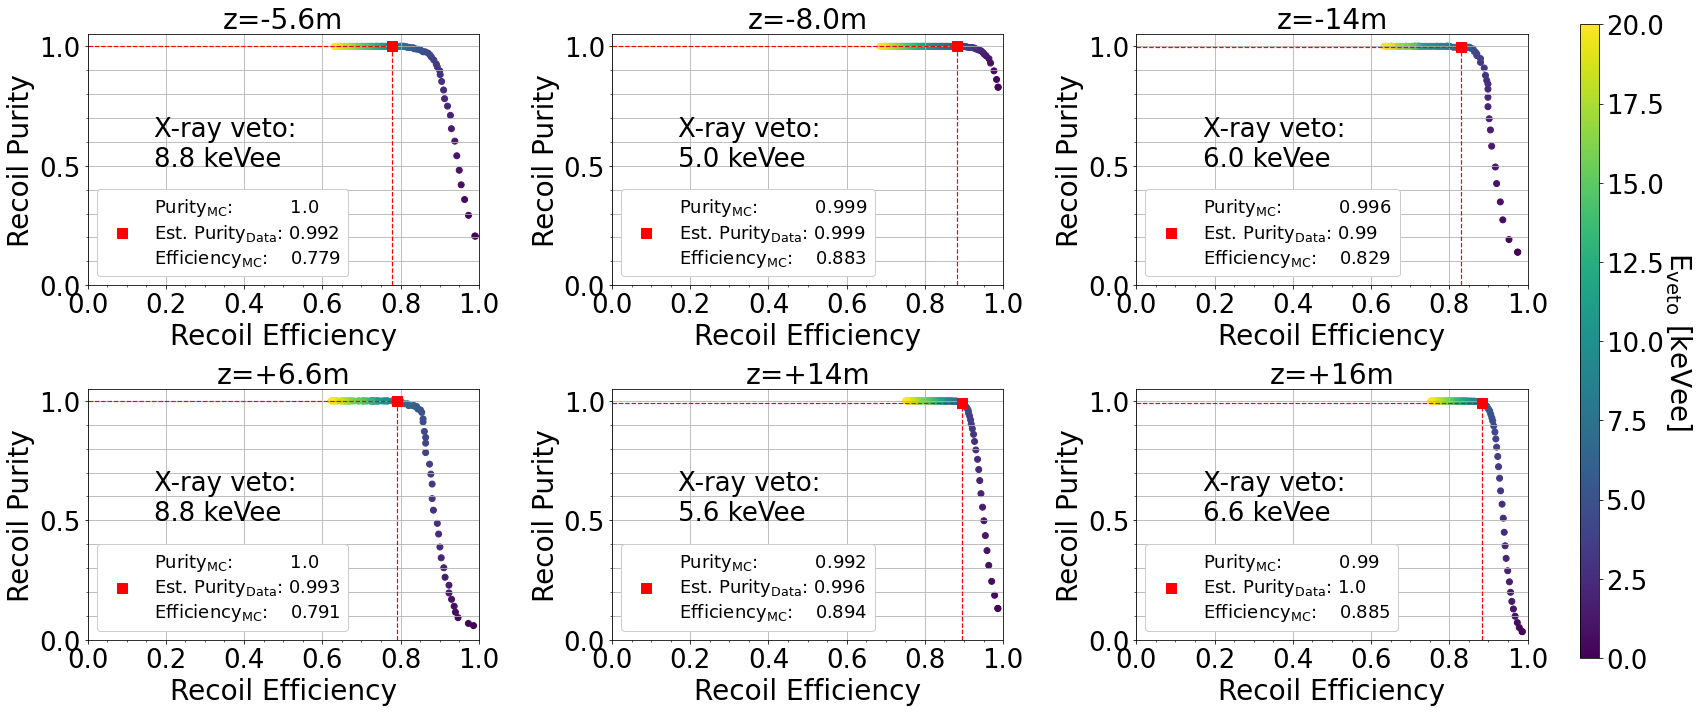

In [31]:

#crit = {'palila': 9.0, 'iiwi': 8.8, 'tako': 4.6, 'nene': 5.6, 'elepaio': 6.4, 'humu': 6.4} #actual chosen veto
#crit2 = {'palila': 4.8, 'iiwi': 3.8, 'tako': 2.0, 'nene': 4.6, 'elepaio': 3.6, 'humu': 4.2} #MC predicted veto
crit = {'palila': 8.8, 'iiwi': 8.8, 'tako': 5.0, 'nene': 5.6, 'elepaio': 6.0, 'humu': 6.6}
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=26)
plt.rc('ytick', labelsize=26)
plt.rc('axes', labelsize=28)
plt.rc('axes', titlesize=28)
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (22,10))
i=1
pos = ['z=-5.6m', 'z=+6.6m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']
axs = [ax[0,0], ax[1,0], ax[0,1], ax[1,1], ax[0,2], ax[1,2]]
for tpc in ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']:
    df = pd.DataFrame()
    df['E'] = E
    df['purity'] = purity[tpc]
    df['efficiency'] = efficiency[tpc]
    #print(df.loc[np.abs(df['E']-crit[tpc])<0.0001].iloc[0])
    #plt.subplot(3,2,i)
    c=axs[i-1].scatter(efficiency[tpc],purity[tpc],c=E)#,norm=matplotlib.colors.LogNorm(vmin = 1, vmax = 20))
    axs[i-1].plot(df.loc[np.abs(df['E']-crit[tpc])<0.0001]['efficiency'].iloc[0],df.loc[np.abs(df['E']-crit[tpc])<0.0001]['purity'].iloc[0],'s',markersize = 10,color = 'red',label='Purity$_\mathrm{MC}$:          %s \nEst. Purity$_\mathrm{Data}$: %s\nEfficiency$_\mathrm{MC}$:    %s'%(round(df.loc[np.abs(df['E']-crit[tpc])<0.0001]['purity'].iloc[0],3),round(1-(pd.Series(e_leak[tpc]).dropna().sum()/len(data[tpc].loc[(data[tpc]['track_energy']>crit[tpc])&(data[tpc]['is_recoil']==1)&(data[tpc]['new_length']<=4000)])),3),round(df.loc[np.abs(df['E']-crit[tpc])<0.0001]['efficiency'].iloc[0],3)))
    #axs[i-1].plot(df.loc[np.abs(df['E']-crit2[tpc])<0.0001]['efficiency'].iloc[0],df.loc[np.abs(df['E']-crit2[tpc])<0.0001]['purity'].iloc[0],'s',markersize = 6,color = 'magenta',label='MC Predicted X-ray Veto: %s keV'%(round(crit2[tpc],2)))
    axs[i-1].hlines(df.loc[np.abs(df['E']-crit[tpc])<0.0001]['purity'].iloc[0], 0,df.loc[np.abs(df['E']-crit[tpc])<0.0001]['efficiency'].iloc[0],linestyle='--',lw = 1.2, color = 'red') 
    print(tpc, df.loc[np.abs(df['E']-crit[tpc])<0.0001]['purity'].iloc[0])
    axs[i-1].vlines(df.loc[np.abs(df['E']-crit[tpc])<0.0001]['efficiency'].iloc[0], 0,df.loc[np.abs(df['E']-crit[tpc])<0.0001]['purity'].iloc[0],linestyle='--',lw = 1.2, color = 'red') 
    axs[i-1].set_xlabel('Recoil Efficiency')
    axs[i-1].set_ylabel('Recoil Purity')
    axs[i-1].set_xlim(0,1)
    axs[i-1].set_ylim(0,1.05)
    axs[i-1].set_xticks([0,0.2,0.4,0.6,0.8,1.0])
    axs[i-1].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i-1].yaxis.set_minor_locator(AutoMinorLocator())
    axs[i-1].set_title(pos[i-1])
    axs[i-1].text(0.17,0.5,'X-ray veto:\n%s keVee'%round(crit[tpc],2),size = 26)
    axs[i-1].legend(loc='lower left', framealpha = 1)
    axs[i-1].grid(axis = 'x')
    axs[i-1].grid(axis = 'y', which = 'both')
    i+=1
cbar_ax = fig.add_axes([1, 0.08, 0.012, 0.88])
fig.colorbar(c,cax=cbar_ax).set_label(r'$E_{veto}$ [keVee]',rotation=270,labelpad=30)
fig.subplots_adjust(right=0.6)
plt.tight_layout()
plt.savefig("test.jpg", dpi = 200, bbox_inches='tight')
plt.show()

## Summary of xray veto choice

1. We start by finding the lowest xray veto energy where truth MC purity = 1 
2. We then test these xray veto thresholds in data by measuring the percentage of events below threshold leaking into the region above, assuming gaussian energy distributions among particles below energy threshold
3. We set the vet threshold to be the lowest energy with truth MC purity of 1 and leakages <1% in data

Values chosen:
'palila': 9.0, 
'iiwi': 8.8, 
'tako': 4.6, 
'nene': 5.6, 
'elepaio': 6.4, 
'humu': 6.4

### Come up with data/MC systematic
Do it brute force: Inefficient and slow, but it works for now

### Call class again with recoils only for accurate data/MC ratios

In [2]:
crit = {'palila': 8.8, 'iiwi': 8.8, 'tako': 5.0, 'nene': 5.6, 'elepaio': 6.0, 'humu': 6.6}
b = analysis(E_cut = crit, E_cut_err = 0, recoils_only = True,  fei4_restrict = True)
bf = analysis(E_cut = crit, E_cut_err = 0, recoils_only = True,  fei4_restrict = False)

In [5]:
crit = {'palila': 8.8, 'iiwi': 8.8, 'tako': 5.0, 'nene': 5.6, 'elepaio': 6.0, 'humu': 6.6}
tpcs = crit.keys()
crit_high = {}
crit_low = {}
for tpc in tpcs:
    crit_high[tpc] = data[tpc]['track_energy_err'].iloc[0]/data[tpc]['track_energy'].iloc[0]*crit[tpc] + crit[tpc]
    crit_low[tpc] = -1*data[tpc]['track_energy_err'].iloc[0]/data[tpc]['track_energy'].iloc[0]*crit[tpc] + crit[tpc]

In [6]:
c = analysis(E_cut = crit_high, E_cut_err = 0, recoils_only = True,  fei4_restrict = True)
d = analysis(E_cut = crit_low, E_cut_err = 0, recoils_only = True,  fei4_restrict = True)

In [7]:
datamc = b.compute_data_MC_ratios('Cont_inj', E_cut=crit)[2]
datamc_storage = b.compute_data_MC_ratios('Decay', E_cut=crit)[2]
datamc2 = bf.compute_data_MC_ratios('Cont_inj', E_cut=crit)[2]
datamc_high = c.compute_data_MC_ratios('Cont_inj',E_cut=crit_high)[2]
datamc_low = d.compute_data_MC_ratios('Cont_inj',E_cut=crit_low)[2]


 FCN=23.3691 FROM MINOS     STATUS=SUCCESSFUL    222 CALLS        1287 TOTAL
                     EDM=2.90238e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.16294e-10   6.32898e-06   2.00893e-02  -8.48189e-06
   2  p1           7.29908e-14   5.71849e-08   6.14680e-02   3.64720e-06
   3  p2           1.50027e-02   8.18925e-03  -1.25374e-06  -4.54173e-02
   4  p3           2.62609e-01   5.72335e-02   5.72335e-02   1.97492e-02
 FCN=30.5615 FROM MINOS     STATUS=SUCCESSFUL    202 CALLS        1024 TOTAL
                     EDM=5.67336e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.99999e-06   5.30638e-06   1.51382e-02   3.01795e-05
   2  p1           1.00000e-07   

Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in

In [10]:
datamc

,LER_bg_base,LER_bg_base_err,LER_bg_dynamic,LER_bg_dynamic_err,LER_T,LER_T_err,HER_bg_base,HER_bg_base_err,HER_bg_dynamic,HER_bg_dynamic_err,HER_T,HER_T_err,Lumi,Lumi_err
elepaio,7.957304,8.544032,inf,NaN,inf,NaN,inf,NaN,2.646600e-08,20.869361,1.090742,0.219313,0.390485,0.062399
tako,0.000007,2.418768,2.213891e-05,91.883821,inf,NaN,5.188831e+00,9.101441,inf,NaN,0.417508,0.301314,0.019460,0.000841
palila,1.257606,39.201534,1.537290e+00,24.214010,inf,NaN,6.222909e-08,9.783001,8.948079e+00,44.121895,1.032877,0.384968,0.040710,0.003845
iiwi,0.000260,7.594782,1.751779e-05,13.724366,0.279613,0.157386,7.121952e+01,233.120665,3.034030e+00,88.309700,1.134771,3.148284,0.037991,0.013058
nene,inf,NaN,2.608073e-07,48.787402,0.475679,0.194206,5.391279e-05,170.752760,3.373507e-04,499.243631,inf,NaN,0.000539,0.000262
humu,15.999976,12.546583,2.742856e+01,31.939926,0.220901,0.207067,7.880554e-08,54.109740,inf,NaN,inf,NaN,0.000053,0.000160


In [ ]:
crit = {'palila': 8.8, 'iiwi': 8.8, 'tako': 5.0, 'nene': 5.6, 'elepaio': 6.0, 'humu': 6.6}
b.compute_data_MC_ratios('Cont_inj', E_cut=crit, L = 1)[2]

In [14]:
(datamc_high-datamc)

,LER_bg_base,LER_bg_base_err,LER_bg_dynamic,LER_bg_dynamic_err,LER_T,LER_T_err,HER_bg_base,HER_bg_base_err,HER_bg_dynamic,HER_bg_dynamic_err,HER_T,HER_T_err,Lumi,Lumi_err
elepaio,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-9.652892e-09,1.015832,-0.009051,-0.001730,-0.002568,-0.000385
tako,0.000000,0.000000,0.000004,18.376764,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000245,0.000019
palila,-1.195746,-12.789372,-0.584728,-6.518298,NaN,NaN,0.000544,2.237628,-2.965213e+00,-6.968988,0.015522,0.001545,-0.000087,0.000065
iiwi,11.294521,4.469890,2.054026,8.546204,-0.031394,0.057677,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-0.002257,0.000049
nene,NaN,NaN,0.000000,0.000000,0.007672,0.003284,-0.000052,-21.160067,-3.360616e-04,-3.866686,NaN,NaN,-0.000013,0.000001
humu,0.000022,0.675953,-0.042120,-9.696023,-0.020429,-0.000912,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000010,0.000004


In [12]:
(datamc_low-datamc)

,LER_bg_base,LER_bg_base_err,LER_bg_dynamic,LER_bg_dynamic_err,LER_T,LER_T_err,HER_bg_base,HER_bg_base_err,HER_bg_dynamic,HER_bg_dynamic_err,HER_T,HER_T_err,Lumi,Lumi_err
elepaio,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-8.822001e-10,-0.695645,-0.024239,-0.006217,-0.010352,-0.002276
tako,0.000000,0.000000,-0.000003,-13.126260,NaN,NaN,-5.188630e+00,-1.336966,NaN,NaN,0.011918,-0.089869,-0.000421,-0.000014
palila,1.538619,0.673686,0.165809,-9.971773,NaN,NaN,5.738915e-07,1.583304,-8.948079e+00,-9.476011,0.048077,-0.048772,-0.000668,-0.000102
iiwi,-0.000213,4.273641,-0.000012,7.516634,-0.022908,0.002763,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-0.000850,-0.000005
nene,NaN,NaN,0.000045,8.210160,-0.016555,-0.003627,8.382725e-04,-4.357893,-1.160138e-04,-248.978304,NaN,NaN,0.000018,-0.000003
humu,-0.000782,4.166253,-2.399421,-10.708735,-0.016901,-0.016959,3.675647e+01,-23.262002,NaN,NaN,NaN,NaN,-0.000016,-0.000018


In [ ]:
datamc_low/datamc

In [ ]:
datamc_high/datamc

In [ ]:
datamc_storage-datamc

Turn ratios into single dataframe for convenience

### Look at data/MC vs E_thresh

In [ ]:
rat = {}
rat_err = {}
rat_LER = {}
rat_LER_err = {}
rat_HER = {}
rat_HER_err = {}

Ens = [4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]
tpcs = ['elepaio','tako','palila','iiwi','nene','humu']
for tpc in tpcs:
    rat[tpc] = []
    rat_err[tpc] = []
    rat_LER[tpc] = []
    rat_LER_err[tpc] = []
    rat_HER[tpc] = []
    rat_HER_err[tpc] = []
for E in Ens:
    data_MC = b.compute_data_MC_ratios("Cont_inj", E_cut=E)[2]
    i = 0
    for tpc in tpcs:
        rat[tpc].append(data_MC.iloc[i]['Lumi'])
        rat_err[tpc].append(data_MC.iloc[i]['Lumi_err'])
        rat_LER[tpc].append(data_MC.iloc[i]['LER_T'])
        rat_LER_err[tpc].append(data_MC.iloc[i]['LER_T_err'])
        rat_HER[tpc].append(data_MC.iloc[i]['HER_T'])
        rat_HER_err[tpc].append(data_MC.iloc[i]['HER_T_err'])
        i+=1

In [ ]:
key = 'column'
np.concatenate(MC['humu'].loc[MC['humu']['VRC_id']==5][key].to_numpy()).ravel().max()-np.concatenate(MC['humu'].loc[MC['humu']['VRC_id']==5][key].to_numpy()).ravel().min()


In [ ]:
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)

plt.figure(figsize = (16,16))
tpcs = ['palila','iiwi','tako','nene','elepaio','humu']
pos = ['z=-5.6m', 'z=+6.6m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']
#pos = ['z=-14m', 'z=-+16m', 'z=+6.6m', 'z=+14m', 'z=-5.6m', 'z=-8.0m']
i=1
for tpc in tpcs:
    plt.subplot(3,2,i)
    if tpc == 'iiwi' or tpc == 'nene' or tpc == 'humu':
        plt.errorbar(Ens,rat_LER[tpc],rat_LER_err[tpc],(Lumi[tpc]['track_energy_err']/Lumi[tpc]['track_energy'])[0]*np.array(Ens),'o', label = 'LER Touschek', color = 'indigo')
    if tpc == 'elepaio' or tpc == 'palila' or tpc == 'tako':
        plt.errorbar(Ens,rat_HER[tpc],rat_HER_err[tpc],(Lumi[tpc]['track_energy_err']/Lumi[tpc]['track_energy'])[0]*np.array(Ens),'o', label = 'HER Touschek', color = 'magenta')
    plt.errorbar(Ens,rat[tpc],rat_err[tpc],(Lumi[tpc]['track_energy_err']/Lumi[tpc]['track_energy'])[0]*np.array(Ens),'o', label = 'Lumi', color = 'green')
    plt.ylabel(r'$\mathcal{O}_{Data}/\mathcal{O}_{MC}$')
    plt.xlabel(r'$E_{thresh}$')
    plt.hlines(1,0,105, color = 'k', linestyle = '-.')
    plt.title(pos[i-1])
    #try:
    #    ymax = (np.array(rat[tpc])+1.1*np.array(rat_err[tpc])).max()
    #    #ymax = .0005
    #    plt.ylim(0,ymax)
    #except ValueError:
    #    ymax = 2
    #    plt.ylim(0,ymax)
    plt.ylim(0.0001,100)
    plt.yscale("log")
    plt.xlim(0,105)
    plt.xticks([0,9,20,40,60,80,100])
    #plt.yticks([-1,-0.5,0,0.5,1,1.5,2,2.5,3])
    plt.grid(which = 'major')
    i+=1
    plt.legend()
plt.tight_layout()
plt.show()

### Visualize MC events on VRC
Not important to show here, was used in a different notebook to test this feature

In [ ]:
tpc = 'iiwi'
len(MC[tpc].loc[MC[tpc]['PDG']>1e9])

In [ ]:
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
def plot_MC(df, evt_num, pid = 'neutron', Emin = 100, Emax = 1000, savefig = False):
    if pid.lower() == 'neutron':
        event = df.loc[(df['PDG']>1e9) & (df['VRC_id']==5) & (df['reco_energy']>=Emin) & (df['reco_energy']<=Emax)].iloc[evt_num]
    elif pid.lower() == 'xray':
        event = df.loc[(df['PDG']==11) & (df['VRC_id']==5)& (df['reco_energy']>=Emin) & (df['reco_energy']<=Emax)].iloc[evt_num]
    else:
        event = df.loc[(np.abs(df['PDG'])!=11) & (np.abs(df['PDG'])<1e9) & (df['VRC_id']==5)& (df['reco_energy']>=Emin)].iloc[evt_num]
    plt.figure(figsize = (8,6))
    e,f,g,h = plt.hist2d(event['column'], event['row'], weights = event['tot'], bins = [80,336], range = [(0,79),(0,335)], vmin = 0, vmax = 7)
    plt.colorbar(h).set_label('TOT', rotation = 270, labelpad = 20)
    #plt.title('PDG = %s, Energy = %s keV'%(event['PDG'],np.round(event['reco_energy'],1)))
    plt.title('Event energy = %s keV'%(np.round(event['reco_energy'],1)))
    plt.xlabel('Column')
    plt.ylabel('Row')
    if savefig == True:
        plt.savefig("/home/jeff/%s_%skev.jpg"%(pid, np.round(event['reco_energy'],1)),dpi=300,bbox_to_anchor = 'tight')
plot_MC(MC['tako'], 3, 'neutron', Emin = 0, Emax = 3,savefig=False)
plot_MC(MC['nene'], 0, 'xray', Emin = 12, Emax = 500,savefig=False)
#plot_MC(MC['iiwi'], 0, 'neutron', Emin = 18.5, Emax = 18.7,savefig=True)
#plot_MC(MC['humu'], 7, 'xray', Emin = 12, Emax = 100,savefig=True)
#plot_MC(MC['palila'], 0, 'other')

In [ ]:
def plot_event_and_vrc(df, i, color = 'cyan'):
    plt.figure(figsize = (10,8))
    e,f,g,h = plt.hist2d(df['column'].iloc[i], df['row'].iloc[i], weights = df['tot'].iloc[i], bins = [80*3,336*3], range = [(-79,159),(-335,670)], vmin = 0, vmax = 12)
    plt.colorbar(h).set_label('ToT', rotation = 270, labelpad = 20)
    plt.vlines(-79, -670, 670, color = color)
    plt.vlines(0, -670, 670, color = color)
    plt.vlines(79, -670, 670, color = color)
    plt.hlines(-335, -159, 159, color = color)
    plt.hlines(0, -159, 159, color = color)
    plt.hlines(335, -159, 159, color = color)
plot_event_and_vrc(MC['palila'].loc[(MC['palila']['bgType']=='RBB_Lumi')&(MC['palila']['VRC_id']==9)],2)

In [ ]:
%matplotlib inline
def plot_event(tmp, i, color = 'cyan', ekey='track_energy'):
    cmap = plt.cm.viridis
    cmap.set_under(color='white')
    fig, ax = plt.subplots(figsize = (10,6))
    df = tmp.loc[(tmp[ekey]>150) & (tmp[ekey]<500) & (tmp['new_phi']<0.2)]
    e,f,g,h = ax.hist2d(df['column'].iloc[i], 335-df['row'].iloc[i], weights = df['tot'].iloc[i], bins = [80,336], range = [(0,79),(0,335)], vmin = 0.1, vmax = 12,cmap =cmap)
    #ax.colorbar(h).set_label('TOT', rotation = 270, labelpad = 20)
    co = plt.colorbar(h)
    co.set_label('Energy', rotation = 270,labelpad = 30)
    #co.set_ticks([])
    #ax.vlines(-79, -670, 670, color = color)
    #ax.vlines(0, -670, 670, color = color)
    #ax.vlines(79, -670, 670, color = color)
    #ax.hlines(-335, -159, 159, color = color)
    #ax.hlines(0, -159, 159, color = color)
    #ax.hlines(335, -159, 159, color = color)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    print(df[['new_phi','truth_index']].iloc[i])
    #ax.set_xlim(20,30)
    #ax.set_ylim(260,304)
    #ax.set_xticks([])
    #ax.set_yticks([])
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    #ax.grid()
plot_event(MC['tako'].loc[MC['tako']['VRC_id']==5],0,ekey = 'reco_energy')
#ax.ylim(0,150)

In [ ]:
tako = rp.read_root("/home/jeff/data/phase3/spring_2020/05-09-20/geant4_simulation/all_events/tako/RBB_Lumi_tako_truth2.root")


In [ ]:
tako.iloc[206]

# Start Angular Analysis

### Find optimal chi2 for energy

Make sure quantities are defined in terms of recoils only

In [4]:
cut = 100
b = analysis(E_cut = {'palila': cut, 'iiwi': cut, 'tako': cut, 'nene': cut, 'elepaio': cut, 'humu': cut}, E_cut_err = 0, recoils_only = True,  fei4_restrict = False)
LER_cont_inj = b.get_tpc_data_during_study_period("LER", "Cont_inj")
LER_decay = b.get_tpc_data_during_study_period("LER", "Decay")
HER_cont_inj = b.get_tpc_data_during_study_period("HER", "Cont_inj")
HER_decay = b.get_tpc_data_during_study_period("HER", "Decay")
Lumi_cont_inj = b.get_tpc_data_during_study_period("Lumi", "Cont_inj")
Lumi_decay = b.get_tpc_data_during_study_period("Lumi", "Decay")
Lumi = {}
HER = {}
LER = {}
Single_beam = {}
Lumi_all = {}
HER_all = {}
LER_all = {}
Single_beam_all = {}
data = {} #ALL DATA TOGETHER FOR CALIBRATION

MC = b.MC_data

for tpc in Lumi_decay.keys():
    Lumi_all[tpc] = Lumi_decay[tpc].append(Lumi_cont_inj[tpc])
    HER_all[tpc] = HER_decay[tpc].append(HER_cont_inj[tpc])
    LER_all[tpc] = LER_decay[tpc].append(LER_cont_inj[tpc])
    Single_beam_all[tpc] = LER_all[tpc].append(HER_all[tpc])
    data[tpc] = Lumi_all[tpc].append(Single_beam_all[tpc])
    
    Lumi[tpc] = Lumi_cont_inj[tpc]
    HER[tpc] = HER_cont_inj[tpc]
    LER[tpc] = LER_cont_inj[tpc]
    Single_beam[tpc] = LER[tpc].append(HER[tpc])
    
    #Lumi[tpc] = Lumi_decay[tpc]
    #HER[tpc] = HER_decay[tpc]
    #LER[tpc] = LER_decay[tpc]
    #Single_beam[tpc] = LER[tpc].append(HER[tpc])
    
    Lumi[tpc].index = [i for i in range(0,len(Lumi[tpc]))]
    Single_beam[tpc].index = [i for i in range(0,len(Single_beam[tpc]))]
    data[tpc].index = [i for i in range(0,len(data[tpc]))]
    #MC[tpc] = MC[tpc].loc[(MC[tpc]['is_recoil']==1)]

In [ ]:
from ROOT import TVector3
def fitsvd_numpy(df, i, MC = False): #faster than root fit, so this is standard
    x = df.iloc[i]['x']
    y = df.iloc[i]['y']
    z = df.iloc[i]['z']
    if MC == True:
        q = df.iloc[i]['q_from_tot']
        x = x*10000
        y = y*10000
        z = z*10000
    else:
        q = df.iloc[i]['pixel_charge']
    data = np.concatenate((x[:, np.newaxis], y[:, np.newaxis], z[:, np.newaxis]), axis=1)
    datamean = data.mean(axis=0)
    uu, dd, vv = np.linalg.svd(data - datamean)
    projection = []
    projectionl = []
    projectionh = []
    data_low = []
    data_high = []
    for point in data:
        projection += [np.dot(point, vv[0])]
    vec = TVector3(vv[0][0],vv[0][1],vv[0][2])
    maxp = max(projection)
    minp = min(projection)
    length = maxp - minp    
    midp = 0.5*float(maxp+minp)
    head_charge = 0
    tail_charge = 0
    i=0
    for p in projection:
        if p > midp:
            head_charge += q[i]
            data_high.append(data[i])
        else:
            tail_charge += q[i]
            data_low.append(data[i])
        i += 1
    data_low = np.array(data_low)
    data_high = np.array(data_high)
    datamean_low = data_low.mean(axis=0)
    datamean_high = data_high.mean(axis=0)
    uul, ddl, vvl = np.linalg.svd(data_low - datamean_low)
    uuh, ddh, vvh = np.linalg.svd(data_high - datamean_high)
    
    for pointl in data_low:
        projectionl += [np.dot(pointl, vvl[0])]
    vecl = TVector3(vvl[0][0],vvl[0][1],vvl[0][2])
    for pointh in data_high:
        projectionh += [np.dot(pointh, vvh[0])]
    vech = TVector3(vvh[0][0],vvh[0][1],vvh[0][2])
    
    head_charge_fraction = head_charge/(head_charge+tail_charge)
    theta = vec.Theta() #RADIANS
    phi = vec.Phi() #RADIANS
    thetal = vecl.Theta() #RADIANS
    phil = vecl.Phi() #RADIANS
    thetah = vech.Theta() #RADIANS
    phih = vech.Phi() #RADIANS

    if phi < -np.pi/2 or phi > np.pi/2:
        vec = -1*vec
        theta = vec.Theta()
        phi = vec.Phi()
        
    if phil < -np.pi/2 or phil > np.pi/2:
        vecl = -1*vecl
        thetal = vecl.Theta()
        phil = vecl.Phi()
        
    if phih < -np.pi/2 or phih > np.pi/2:
        vech = -1*vech
        thetah = vech.Theta()
        phih = vech.Phi()
        
    return np.abs((thetah-thetal)*180/np.pi)
    #return length, theta, phi, head_charge_fraction, head_charge, tail_charge

res = fitsvd_numpy(Lumi['tako'], 3, MC = False)

def update_ntuple(df, MC = False):
    reso = []
    for j in range(0,len(df)):
        try:
            reso.append(fitsvd_numpy(df, j, MC = MC))
        except:
            reso.append(-1)
    df['reso'] = reso
    return df

for tpc in ['palila', 'iiwi', 'nene', 'tako', 'elepaio', 'humu']:
    Lumi[tpc] = update_ntuple(Lumi[tpc])
    MC[tpc] = update_ntuple(MC[tpc], MC = True)


In [ ]:
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=22)
plt.rc('axes', titlesize=22)
matplotlib.rcParams['mathtext.default'] = 'regular'

E_max = 100
nbins = 21

fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = (15,8))
axs = [ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2]]
i = 1
tpcs = ['palila', 'tako', 'elepaio', 'iiwi', 'nene', 'humu']
pos = ['z = -5.6m', 'z = -8.0m', 'z = -14m', 'z = +6.6m', 'z = +14m', 'z = +16m']
space = np.linspace(0,E_max,nbins)[1]-np.linspace(0,E_max,nbins)[0]
index = np.array([space*i for i in range(0,nbins-1)])+space/2
for tpc in tpcs:
    tmp = Lumi[tpc].groupby(pd.cut(Lumi[tpc]['track_energy'], bins = np.linspace(0,E_max,nbins))).mean()
    tmp_err = Lumi[tpc].groupby(pd.cut(Lumi[tpc]['track_energy'], bins = np.linspace(0,E_max,nbins))).sem()
    tmp_MC = MC[tpc].groupby(pd.cut(MC[tpc]['reco_energy'], bins = np.linspace(0,E_max,nbins))).mean()
    tmp_MC_err = MC[tpc].groupby(pd.cut(MC[tpc]['reco_energy'], bins = np.linspace(0,E_max,nbins))).sem()
    axs[i-1].errorbar(index, tmp['reso'], tmp_err['reso'], None, 'o', label = 'Exp')
    axs[i-1].errorbar(index, tmp_MC['reso'], tmp_MC_err['reso'], None, 'o', label = 'MC')
    axs[i-1].set_title(pos[i-1])
    axs[i-1].set_ylabel(r'$\mu_{\theta}$ $[^{\circ}]$')
    axs[i-1].set_xlabel(r'$E_{\mathrm{cut}}$ [keV]')
    axs[i-1].set_ylim(0,90)
    axs[i-1].set_xlim(0,E_max)
    axs[i-1].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i-1].yaxis.set_minor_locator(AutoMinorLocator())
    axs[i-1].grid()
    axs[i-1].legend()
    i+=1
plt.tight_layout()
plt.show()

In [ ]:
#%matplotlib inline
%matplotlib qt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.patheffects as pe

def plot_event(df, E_min, E_max, events_list, title, cmap = plt.cm.viridis, alpha = 1, zmax = 216*25):

    def cuboid_data(o, size=(1,1,1)):
        X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
        X = np.array(X).astype(float)
        for i in range(3):
            X[:,:,i] *= size[i]
        X += np.array(o)
        return X

    def plotCubeAt(positions,sizes=None,colors=None,edgecolors=None, **kwargs):
        if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(positions)
        if not isinstance(sizes,(list,np.ndarray)): sizes=[(1,1,1)]*len(positions)
        if not isinstance(edgecolors,(list,np.ndarray)): edgecolors=[[0,0,0,.5]]*len(positions)
        g = []
        for p,s,c in zip(positions,sizes,colors):
            g.append( cuboid_data(p, size=s) )
        return Poly3DCollection(np.concatenate(g),  
                            facecolors=np.repeat(colors,6, axis=0), 
                                edgecolors=(0,0,0,0.1), zorder = -1, **kwargs)
    
    def discretize_colormap(cmap):
        cmaplist = [cmap(i) for i in range(cmap.N)]
        # create the new map
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'Custom cmap', cmaplist, N = 14)
        return cmap
    
    cmap = discretize_colormap(cmap)

    colors_dict = {}
    for i in range(0,14):
        colors_dict[i] = np.array(cmap(i))
        colors_dict[i][3] = alpha #sets alpha

    fig = plt.figure(figsize = (18,14))
    ax = fig.add_subplot(projection='3d', proj_type='ortho')
    for i in events_list:
        tmp = df.loc[(df['track_energy']>E_min) & (df['track_energy']<E_max) & (np.abs(df['new_phi'])<.1)
                     & (df['x'].apply(lambda x: x.max())<7500) 
                     & (df['x'].apply(lambda x: x.max())>2500) 
                     & (df['y'].apply(lambda x: x.max())<5880) 
                     & (df['y'].apply(lambda x: x.max())>1680)].iloc[i]
        print(tmp['new_phi']*180/3.14)
        positions = np.concatenate((tmp['x'][:, np.newaxis], tmp['y'][:, np.newaxis], tmp['z'][:, np.newaxis]), axis=1)
        positionsmean = positions.mean(axis=0)
        uu, dd, vv = np.linalg.svd(positions-positionsmean)
        x_rel = tmp['x']-tmp['x'].mean()
        y_rel = tmp['y']-tmp['y'].mean()
        z_rel = tmp['z']-tmp['z'].mean()
        x_track = np.dot([[x_rel[i],y_rel[i],z_rel[i]] for i in range(0,len(tmp['x']))],[vv[0][0],vv[0][1],vv[0][2]])
        length = (x_track.max() - x_track.min())
        linepts = vv[0] * np.mgrid[-length/2:3.4*length/5:2j][:, np.newaxis]
        linepts += positionsmean
        colors = pd.Series(tmp['tot'].transpose()).map(colors_dict).to_numpy()
        pc = plotCubeAt(positions, sizes=[(250, 50, 216)]*len(positions), colors=colors)
        ax.add_collection3d(pc)
        ax.plot3D(*linepts.T, color = 'gray', alpha = 1, lw = 4, path_effects=[pe.Stroke(linewidth=6, foreground='k',alpha = 1), pe.Normal()],zorder = 1e6)
        
    ax.set_xlim(2500,7500)
    ax.set_ylim(1680,5880)
    ax.set_zlim(0,zmax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #ax.set_zlabel('z')
    ax.set_zticks([])
    #ax.set_zticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    #cbar_ax = fig.add_axes([0.7, 0.24, 0.026, 0.58])
    bounds = np.linspace(0, 13, 14)
    #scat = ax.scatter([0 for i in range(0,14)], [0 for i in range(0,14)], c=[i for i in range(0,14)], s=0,
    #              cmap=cmap)
    #plt.colorbar(scat,cax=cbar_ax,spacing='proportional',ticks=bounds, boundaries=bounds).set_label(r'TOT',rotation=270,labelpad=30)
    ax.zaxis.set_pane_color((0.8, 0.4, 0.4, 0.4))
    ax.xaxis.set_pane_color((1.0, 0.2, 0.4, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.set_title(title)

tpcs = ['palila','tako','elepaio','iiwi','nene','humu']
pos = ['z=-5.6m','z=-8.0m','z=-14m','z=+6.6m','z=+14m','z=+16m']
lists = [[0],[4,2,8],[0,15,10],[5,3,0],[4,6,0],[3,0,11]]
i=0
#plot_event(data['humu'], E_min = 60, E_max = 80, events_list = lists[5], title = 'z=-5.6m')
for tpc in ['tako']:
    if tpc == 'humu':
        plot_event(data[tpc], E_min = 150, E_max = 500, events_list = lists[i], title = pos[i])
    elif tpc == 'elepaio':
        plot_event(Lumi[tpc], E_min = 150, E_max = 200, events_list = lists[i], title = pos[i])
    else:
        plot_event(Lumi[tpc], E_min = 150, E_max = 500, events_list = lists[i], title = pos[i], alpha = 1)
    i+=1


In [ ]:
MC['tako']['x']

In [ ]:
cmap

In [ ]:
df = Lumi['tako'].iloc[1]
np.concatenate((df['x'][:, np.newaxis], df['y'][:, np.newaxis], df['z'][:, np.newaxis]), axis=1)

In [ ]:
import array
def perform_chi2_vs_uniform(data,E_cut,xmin = -1, xmax = 1, nbins = 11, angle = 'theta', MC = False):
    data['ones'] = 1
    if MC == False:
        data = data.loc[data['track_energy']>E_cut]
    else:
        data = data.loc[data['reco_energy']>E_cut]
    if angle == 'theta':
        group = data.groupby(pd.cut(np.cos(data['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
        #group = data.groupby(pd.cut(data['new_theta'], bins = np.linspace(xmin,xmax,nbins))).sum()
    else:
        xmin = -np.pi/2
        xmax = np.pi/2
        group = data.groupby(pd.cut((data['new_phi']), bins = np.linspace(xmin,xmax,nbins))).sum()
    chi2 = array.array('d', [0])
    ndf = array.array('i', [0])
    igood = array.array('i', [0])
    option = "UU P"
    n=len(group)
    res = array.array('d', [0 for i in range(0,n)])
    num = group['ones']
    error = 1/np.sqrt(group['ones'])
    h1 = ROOT.TH1D("h1", "h1", nbins, xmin, xmax)
    h2 = ROOT.TH1D("h2", "h2", nbins, xmin, xmax)
    for i in range(0,n):
        h1.SetBinContent(i+1,num.fillna(0)[i])
        h1.SetBinError(i+1,error.fillna(0)[i])
        h2.SetBinContent(i+1,num.sum()/n)
        #h2.SetBinError(i+1,num.fillna(0)[i]*np.sqrt((xmax-xmin)**2/12)/(n*np.sqrt(n)))
    val = h1.Chi2TestX(h2, chi2, ndf, igood, option, res=res)
    return h1, h2, chi2[0], len(data), val, ndf[0]



i=1
tpcs = ['palila','tako','elepaio','iiwi','nene','humu']
positions = ['z=-5.6m', 'z=-8.0m', 'z=-14m', 'z=+6.6m', 'z=+14m', 'z=+16m']
#vals = [10, 6,8,10,8,8]
vals = [34, 48,20,33,39,12]
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,9))
axs = [ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2]]
for tpc in tpcs:
    theta_chi2 = []
    phi_chi2 = []
    theta_pvals = []
    phi_pvals = []
    energies = []
    num_events = []
    theta_chi2_MC = []
    phi_chi2_MC = []
    theta_pvals_MC = []
    phi_pvals_MC = []
    num_events_MC = []
    
    for E in range(0,400):
        h1,h2,val_theta, events, theta_pval, ndf = perform_chi2_vs_uniform(data[tpc], E, angle = 'theta', xmin = -1, xmax = 1)
        h1,h2,val_phi, events, phi_pval, ndf = perform_chi2_vs_uniform(data[tpc], E, angle = 'phi', xmin = -np.pi/2, xmax = np.pi/2)
        h1,h2,val_MC_theta, events_MC, theta_MC_pval, ndf_MC = perform_chi2_vs_uniform(MC[tpc], E, angle = 'theta', xmin = -1, xmax = 1, MC = True)
        h1,h2,val_MC_phi, events_MC, phi_MC_pval, ndf_MC = perform_chi2_vs_uniform(MC[tpc], E, angle = 'phi', xmin = -np.pi/2, xmax = np.pi/2, MC = True)
        theta_chi2.append(val_theta)
        phi_chi2.append(val_phi)
        energies.append(E)
        num_events.append(events)
        theta_pvals.append(theta_pval)
        phi_pvals.append(phi_pval)
        theta_chi2_MC.append(val_MC_theta)
        phi_chi2_MC.append(val_MC_phi)
        num_events_MC.append(events_MC)
        theta_pvals_MC.append(theta_MC_pval)
        phi_pvals_MC.append(phi_MC_pval)

    df = pd.DataFrame()
    df['E']= energies
    df['theta_chi2'] = theta_chi2
    df['phi_chi2'] = phi_chi2
    df['theta_pval'] = theta_pvals
    df['phi_pval'] = phi_pvals
    df['events'] = num_events
    df['theta_chi2_MC'] = theta_chi2_MC
    df['phi_chi2_MC'] = phi_chi2_MC
    df['theta_pval_MC'] = theta_pvals_MC
    df['phi_pval_MC'] = phi_pvals_MC
    df['events_MC'] = num_events_MC
    #chi2s = df[['theta_chi2','phi_chi2']].to_numpy()
    tchi2 = df['theta_chi2'].to_numpy()
    pchi2 = df['phi_chi2'].to_numpy()
    tchi2_MC = df['theta_chi2_MC'].to_numpy()
    pchi2_MC = df['phi_chi2_MC'].to_numpy()
    #chi2s = df['theta_chi2'].to_numpy()
    #chi2s = (tchi2/df['events'] + pchi2/df['events'])/2
    chi2s = tchi2/ndf
    pchi2s = pchi2/ndf
    chi2s_MC = tchi2_MC/ndf_MC
    pchi2s_MC = pchi2_MC/ndf_MC
    min_chi2 = [np.min(chi2s[i]) for i in range(0,len(chi2s))]
    df['min_chi2'] = min_chi2
    #axs[i-1].plot(df['E'],df['theta_chi2']/df['events'],'o')#, label = r'$\cos(\theta)$ dist.')
    axs[i-1].plot(df['E'],chi2s*ndf,'o', label = 'theta data')
    axs[i-1].plot(df['E'],pchi2s*ndf,'o', label = 'phi data')
    axs[i-1].plot(df['E'],chi2s_MC*ndf_MC,'o', label = 'theta MC')
    axs[i-1].plot(df['E'],pchi2s_MC*ndf,'o', label = 'phi MC')
    #plt.plot(df['E'],df['phi_chi2']/df['events'],'o', label = r'$\phi$ dist.')
    #crit = df.loc[(df['min_chi2']/df['events'])==(df['min_chi2']/df['events']).max()]
    #crit = df.loc[chi2s==chi2s.max()]
    crit = df.loc[df['E']==70]
    #crit = df.loc[df['E']==vals[i-1]]
    print(tpc + ' ' + str(crit['E'].iloc[0]) + ' keV  ' + str(crit['min_chi2'].iloc[0]) + ' ' + str(crit['events'].iloc[0]) + 'events. Theta p-value = ' + str(crit['theta_pval'].iloc[0]) + ' phi p-val = ', str(crit['phi_pval'].iloc[0]))
    #print(tpc + ' ' + str(crit['E'].iloc[0]) + ' keV  ' + str(crit['min_chi2'].iloc[0]) + ' ' + str(crit['events'].iloc[0]) + 'events. Theta p-value = ' + str(crit['theta_pval'].iloc[0]))
    axs[i-1].plot(crit['E'],crit['min_chi2'],'x', label = r'Joint maximum', markersize = 20, color = 'magenta')
    #plt.vlines(vals[i-1],0,800,color = 'k')
    axs[i-1].set_xlabel(r'$E_{cut}$ [keV]')
    #axs[i-1].set_ylabel(r'$\chi^2/$ndf')
    axs[i-1].set_ylabel(r'$\chi^2$')
    axs[i-1].set_yscale("log")
    #axs[i-1].set_ylim(0.1,100)
    axs[i-1].set_ylim(0.1,1000)
    axs[i-1].set_xlim(0,400)
    #axs[i-1].set_xticks([0,100,200,300,400])
    axs[i-1].set_xticks([0,100,200,300,400])
    #axs[i-1].set_yticks([0.001,0.005,0.01, 0.05, 0.1, 0.5, 1])
    axs[i-1].set_yticks([0.1,1, 10, 100, 1000])
    axs[i-1].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[i-1].get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
    axs[i-1].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[i-1].grid(axis = 'both', which = 'both')
    axs[i-1].set_title(positions[i-1])
    axs[i-1].xaxis.set_minor_locator(AutoMinorLocator())
    #axs[i-1].legend()
    i+=1
plt.tight_layout()
plt.show()

### 2D histogram to check energy peak

In [3]:
%matplotlib qt
cut = 100
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
E_cut = {'palila': cut, 'iiwi': cut, 'tako': cut, 'nene': cut, 'elepaio': cut, 'humu': cut}
tpc = 'palila'

x = np.cos(Lumi[tpc].loc[Lumi[tpc]['track_energy']>=E_cut[tpc]]['new_theta']).to_numpy()   #turn x,y data into numpy arrays
y = Lumi[tpc].loc[Lumi[tpc]['track_energy']>=E_cut[tpc]]['new_phi'].to_numpy()   #useful for regular matplotlib arrays

fig = plt.figure(figsize = (12,10))          #create a canvas, tell matplotlib it's 3d
ax = fig.add_subplot(111, projection='3d')

#make histogram stuff - set bins - I choose 20x20 because I have a lot of data
hist, xedges, yedges = np.histogram2d(x, y, bins=(10,10),range=((-1.08,0.92),(-1.75,1.45)))
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = hist.flatten()

#cmap = matplotlib.colors.get_cmap('jet') # Get desired colormap - you can change this!
cmap = plt.cm.viridis
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k)/max_height) for k in dz] 

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba,shade = True,zsort='average',edgecolor='k')
#cbar_ax = fig.add_axes([1, 0.08, 0.012, 0.88])
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), ax=ax)
cbar.set_ticks([])
cbar.set_label('<----- Counts per bin',rotation = 270,labelpad = 30)
#plt.title("X vs. Y Amplitudes for ____ Data")
plt.ylabel(r"$\phi_\mathrm{TPC}$",labelpad = 20)
plt.xlabel(r"$\cos(\theta_\mathrm{TPC})$",labelpad = 20)
ax.zaxis.set_pane_color((0.8, 0.4, 0.4, 0.0))
ax.xaxis.set_pane_color((1.0, 0.2, 0.4, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.set_xlim(-1,1)
ax.set_ylim(-np.pi/2,np.pi/2)
#ax.set_zlabel('Counts per bin',labelpad = 20, rotation=90)
plt.savefig("LEGO.jpg",dpi = 300)
plt.show()

In [ ]:
tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
pos = ['z=-5.6m', 'z=+6.6m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']
j=1
i=1
plt.figure(figsize = (18,30))
cut = 100
E_cut = {'palila': cut,'tako': cut,'elepaio': cut,'iiwi': cut, 'nene': cut,'humu': cut}
#E_cut = {'palila': 10,'tako': 10,'elepaio': 10,'iiwi': 10, 'nene': 10,'humu': 10}
#E_cut = {'palila': 65,'tako': 85,'elepaio': 152,'iiwi': 80, 'nene': 150,'humu': 130}
#E_cut = {'palila': 35, 'tako': 65, 'elepaio': 140, 'iiwi': 75, 'nene': 80, 'humu': 125}
#E_cut = {'palila': 60, 'tako': 50, 'elepaio': 160, 'iiwi': 50, 'nene': 57, 'humu': 82}
#E_cut = {'palila': 70, 'tako': 65, 'elepaio': 120, 'iiwi': 75, 'nene': 145, 'humu': 170}
for tpc in tpcs:
    plt.subplot(6,2,i)
    z,y,x,w = plt.hist2d(np.cos(Lumi[tpc].loc[Lumi[tpc]['track_energy']>=E_cut[tpc]]['new_theta']), Lumi[tpc].loc[Lumi[tpc]['track_energy']>=E_cut[tpc]]['new_phi'], range = ((-1,1),(-np.pi/2,np.pi/2)), bins = (10, 10),vmin = 0)#, weights = Lumi[tpc]['track_energy'])
    plt.title(pos[j-1])
    plt.xlabel(r'$\cos(\theta)$')
    plt.ylabel(r'$\phi$')
    #plt.colorbar(d).set_label(r'$\sum E$ per bin [keV]', rotation = 270, labelpad = 30)
    plt.colorbar(w).set_label(r'Events per bin', rotation = 270, labelpad = 30)
    plt.subplot(6,2,i+1)
    z,y,x,w = plt.hist2d(np.cos(MC[tpc].loc[MC[tpc]['reco_energy']>=E_cut[tpc]]['new_theta']), MC[tpc].loc[MC[tpc]['reco_energy']>=E_cut[tpc]]['new_phi'], range = ((-1,1),(-np.pi/2,np.pi/2)), bins = (11, 11))#, weights = MC[tpc]['reco_energy'])
    plt.title(pos[j-1] + ' MC')
    plt.xlabel(r'$\cos(\theta)$')
    plt.ylabel(r'$\phi$')
    plt.colorbar(w).set_label(r'Events per bin', rotation = 270, labelpad = 30)
    j+=1
    i+=2
plt.tight_layout()
plt.show()

In [ ]:
tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
pos = ['z=-5.6m', 'z=+6.6m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']

i=1
cut = 100
plt.figure(figsize = (18,15))
E_cut = {'palila': cut,'tako': cut,'elepaio': cut,'iiwi': cut, 'nene': cut,'humu': cut}
#E_cut = {'palila': 65,'tako': 85,'elepaio': 152,'iiwi': 80, 'nene': 150,'humu': 130}
#E_cut = {'palila': 35, 'tako': 65, 'elepaio': 140, 'iiwi': 75, 'nene': 80, 'humu': 125}
#E_cut = {'palila': 60, 'tako': 50, 'elepaio': 160, 'iiwi': 50, 'nene': 57, 'humu': 82}
#E_cut = {'palila': 70, 'tako': 65, 'elepaio': 120, 'iiwi': 75, 'nene': 145, 'humu': 170}
for tpc in tpcs:
    plt.subplot(3,2,i)
    plt.hist(Lumi[tpc].loc[Lumi[tpc]['track_energy']>=E_cut[tpc]]['new_phi'], histtype = 'step', range = (-np.pi/2,np.pi/2), bins = 21, label = 'Data')#, weights = Lumi[tpc]['track_energy'])
    #plt.vlines(-np.pi/6,0,450, color = 'red')
    #plt.vlines(+np.pi/6,0,450, color = 'red')
    plt.title(pos[i-1])
    plt.xlabel(r'$\phi$')
    #plt.xlim(-np.pi/6, np.pi/6)
    plt.hist(MC[tpc].loc[MC[tpc]['reco_energy']>=E_cut[tpc]]['new_phi'], histtype = 'step', range = (-np.pi/2,np.pi/2), bins = 21, label = 'MC')#, weights = MC[tpc]['reco_energy'])
    i+=1
    #plt.yscale("log")
    #plt.ylim(0.9,400)
    plt.legend()
plt.tight_layout()
plt.show()

# Scale MC to study time of 1s

In [ ]:
ratio

In [3]:
cut = 100
#E_cut = {'palila': 40, 'tako': 120, 'elepaio': 110, 'iiwi': 55, 'nene': 95, 'humu': 155}
#E_cut = {'palila': 40, 'tako': 67, 'elepaio': 150, 'iiwi': 100, 'nene': 75, 'humu': 135}
#E_cut = {'palila': 90,'tako': 145,'elepaio': 155,'iiwi': 110, 'nene': 135,'humu': 130}
#E_cut = {'palila': 30,'tako': 50,'elepaio': 100,'iiwi': 60, 'nene': 45,'humu': 100}
#E_cut = {'palila': 100,'tako': 160,'elepaio': 140,'iiwi': 100, 'nene': 130,'humu': 130}
E_cut = {'palila': cut,'tako': cut,'elepaio': cut,'iiwi': cut, 'nene': cut,'humu': cut}
#ratio = bf.compute_data_MC_ratios("Cont_inj", E_cut=E_cut)[2] #with VRC
ratio = b.compute_data_MC_ratios("Cont_inj", E_cut=E_cut)[2] #currently with VRC
ratio = ratio.replace([np.inf, -np.inf, np.nan], 1)
skb = b.select_study("Lumi", "Cont_inj")
Scaled_MC = {}
tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
factors = {'Coulomb_LER_base' : 1/4., 'Coulomb_LER_dynamic' : 1/4., 
           'Coulomb_HER_base' : 1/40., 'Coulomb_HER_dynamic' : 1/40.,
          'Brems_LER_base' : 1/40., 'Brems_LER_dynamic' : 1/40., 
           'Brems_HER_base' : 1/400., 'Brems_HER_dynamic' : 1/400.,
          'Touschek_LER_all' : 1/0.4, 'Touschek_HER_all' : 1/1.6,
          #'RBB_Lumi' : (skb['ECL_lumi'].mean()/10000)/(25*2.2e-3), 'twoPhoton_Lumi' : 100*(skb['ECL_lumi'].mean()/10000)/25.}
           'RBB_Lumi' : 1/(9.7e-3*25), 'twoPhoton_Lumi' : 1/(.01*25)} #RBB 1-50000: 0.02us/file, 50000-60000: 0.08us/file, 60000-70000: 0.04 us/file, >70000-220000: 0.05us/file
#factors = {'Coulomb_LER_base' : 0, 'Coulomb_LER_dynamic' : 0, 
#           'Coulomb_HER_base' : 0., 'Coulomb_HER_dynamic' : 0,
#          'Brems_LER_base' : 0., 'Brems_LER_dynamic' : 0, 
#           'Brems_HER_base' : 0., 'Brems_HER_dynamic' : 0,
#          'Touschek_LER_all' : 2.5, 'Touschek_HER_all' : 0.625,
#          'RBB_Lumi' : 1/(9.7e-3*25), 'twoPhoton_Lumi' : 1/(.01*25)}

for tpc in tpcs:
    Scaled_MC[tpc] = MC[tpc].loc[(MC[tpc]['is_recoil']==1)][['reco_energy','new_theta', 'new_phi','bgType', 'VRC_id', 'new_length']]
    Scaled_MC[tpc].index = [i for i in range(0,len(Scaled_MC[tpc]))]
    Scaled_MC[tpc]['ones'] = 1
    Scaled_MC[tpc]['scaled_energy'] = 0
    Scaled_MC[tpc]['weights'] = 1
    Scaled_MC[tpc]['weights_err'] = 0
for tpc in tpcs:
    for key in factors.keys():
        index = Scaled_MC[tpc].loc[(Scaled_MC[tpc]['bgType'] == key)].index.to_numpy()
        for val in index:
            if (key == 'Coulomb_LER_base') or (key == 'Brems_LER_base'):
                wkey = 'LER_bg_base'
            elif (key == 'Coulomb_HER_base') or (key == 'Brems_HER_base'):
                wkey = 'HER_bg_base'
            elif (key == 'Coulomb_LER_dynamic') or (key == 'Brems_LER_dynamic'):
                wkey = 'LER_bg_dynamic'
            elif (key == 'Coulomb_HER_dynamic') or (key == 'Brems_HER_dynamic'):
                wkey = 'HER_bg_dynamic'
            elif key == 'Touschek_LER_all':
                wkey = 'LER_T'
            elif key == 'Touschek_HER_all':
                wkey = 'HER_T'
            else:
                wkey = 'Lumi'
            wkey_err = wkey + '_err'
            #Scaled_MC[tpc]['weights'].iloc[val] = factors[key]*(datamc.T.loc[data_MC.index == tpc])[wkey][0]
            #if tpc != 'elepaio':
            Scaled_MC[tpc]['weights'].iloc[val] = factors[key]*(ratio.loc[ratio.index == tpc])[wkey][0]
            Scaled_MC[tpc]['weights_err'].iloc[val] = Scaled_MC[tpc]['weights'].iloc[val]*(ratio.loc[ratio.index == tpc])[wkey_err][0]/(ratio.loc[ratio.index == tpc])[wkey][0]
            #index = Scaled_MC[tpc].loc[(Scaled_MC[tpc]['weights_err']/Scaled_MC[tpc]['weights'])>5].index.to_numpy()
            #Scaled_MC[tpc]['weights_err'][index] = 0
            #Scaled_MC[tpc]['weights'][index] = 0
            #else:
            #    Scaled_MC[tpc]['weights'].iloc[val] = factors_elepaio[key]*(ratio.loc[ratio.index == tpc])[wkey][0]
            #Scaled_MC[tpc]['reco_energy'].iloc[val] = factors[key]*Scaled_MC[tpc]['reco_energy'].iloc[val]
            #Scaled_MC[tpc]['scaled_energy'].iloc[val] = factors[key]*Scaled_MC[tpc]['reco_energy'].iloc[val]
            #Scaled_MC[tpc]['scaled_energy'].iloc[val] = Scaled_MC[tpc]['weights'].iloc[val]*Scaled_MC[tpc]['ones'].iloc[val]

 NEW MINIMUM FOUND.  GO BACK TO MINIMIZATION STEP.
                                                  V
                                                  V
                                                  V
                                               VVVVVVV
                                                VVVVV
                                                 VVV
                                                  V

 FCN=18.8734 FROM MINOS     STATUS=SUCCESSFUL    249 CALLS        1092 TOTAL
                     EDM=1.85418e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.79197e-12   9.88730e-06  -1.97763e-02** at limit **
   2  p1           6.33343e-13   7.69509e-08   5.32722e-03  -2.85515e-04
   3  p2           4.69635e-03   4.85940e-03   6.10176e-05  -2.01826e-02
   4  p3           9.25754e-02   3.36180e-02   3.36180e-02

Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in

In [ ]:
for tpc in tpcs:
    print(Scaled_MC[tpc][['weights','bgType']])

# Data-MC phi distribution comparison

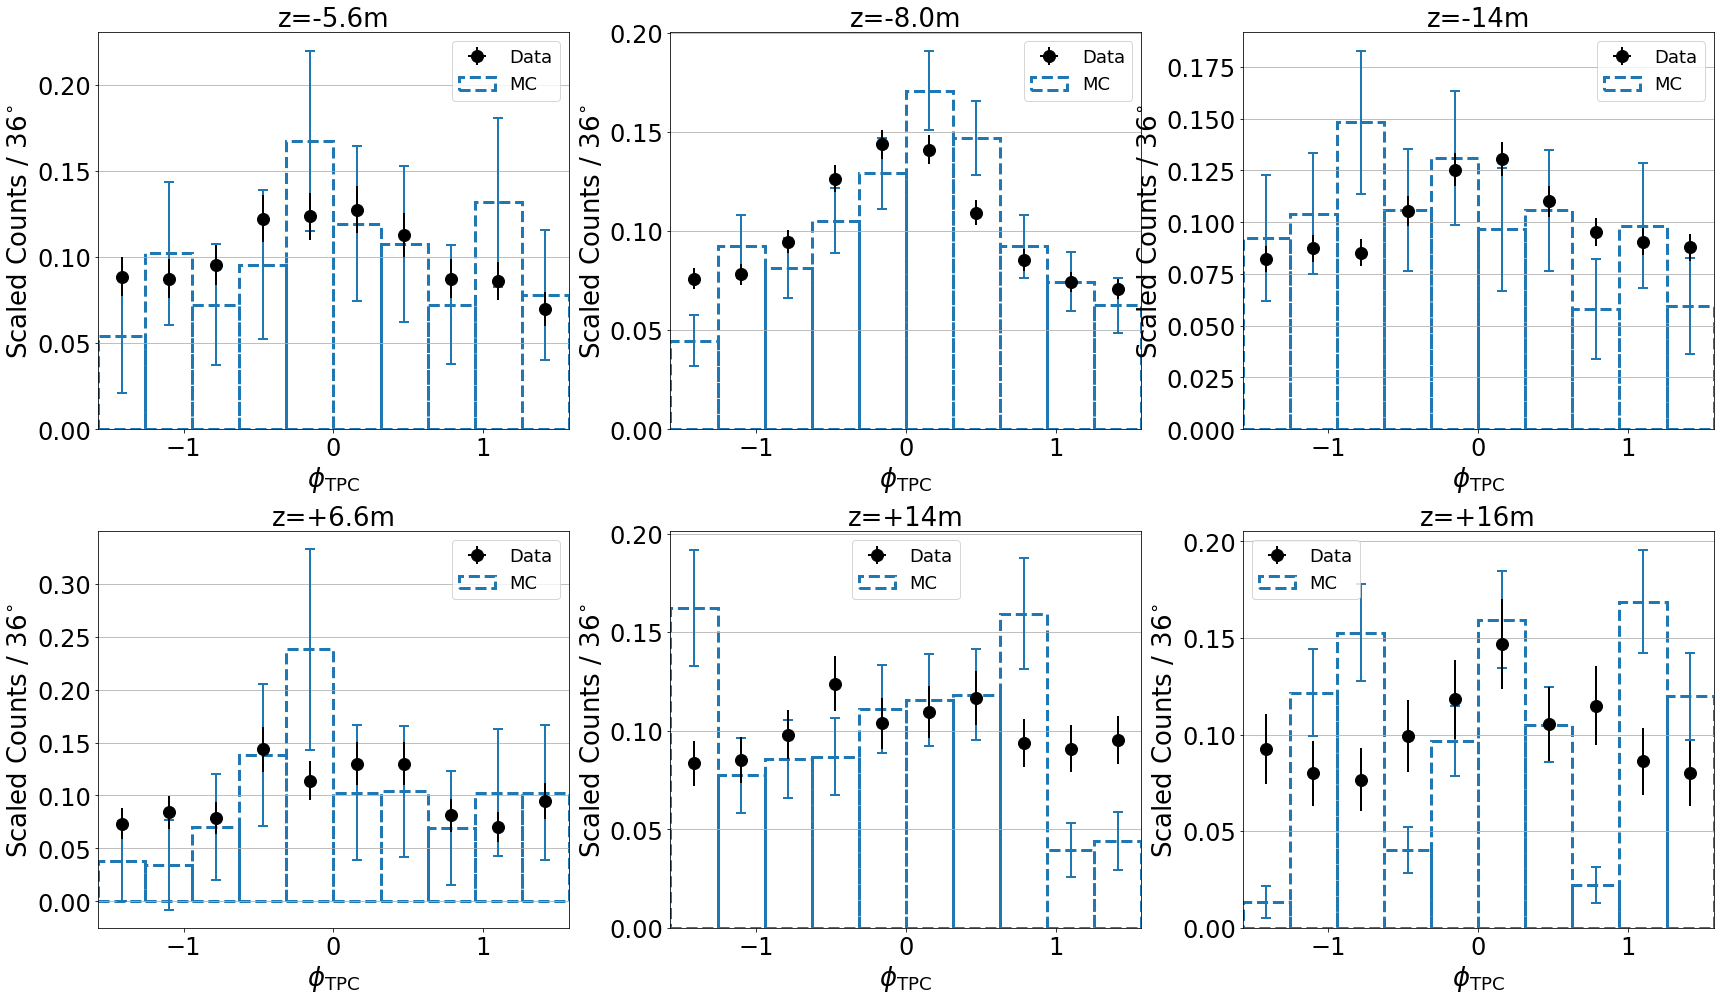

In [5]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
nbins = 11
xmin = -np.pi/2
xmax = np.pi/2
E_cut = {'palila': cut,'tako': cut,'elepaio': cut,'iiwi': cut, 'nene': cut,'humu': cut}
width = (np.abs(xmin)+np.abs(xmax))/(nbins-1)
center = [xmin +(width*i)+width/2 for i in range(0,nbins-1)]
tpcs = ['palila', 'tako', 'elepaio','iiwi', 'nene','humu']
pos = ['z=-5.6m', 'z=-8.0m', 'z=-14m', 'z=+6.6m', 'z=+14m', 'z=+16m']
n0 = {}
d0 = {}
p0 = {}
nerr0 = {}
derr0 = {}
err0 = {}
n1 = {}
d1 = {}
p1 = {}
err1 = {}
n2 = {}
d2 = {}
p2 = {}
err2 = {}
n3 = {}
d3 = {}
p3 = {}
nerr3 = {}
derr3 = {}
err3 = {}
n4 = {}
d4 = {}
p4 = {}
nerr4 = {}
derr4 = {}
err4 = {}
plt.figure(figsize = (24,14))
i=1
j=1
for tpc in tpcs:
    Lumi[tpc]['ones'] = 1
    Single_beam[tpc]['ones'] = 1
    #Scaled_MC[tpc]['counts'] = 1
    
    ### CUTS ###
    
    Lumi_tmp = Lumi[tpc].loc[Lumi[tpc]['track_energy']>E_cut[tpc]]
    SB_tmp = Single_beam[tpc].loc[Single_beam[tpc]['track_energy']>E_cut[tpc]]
    MC_tmp = Scaled_MC[tpc].loc[Scaled_MC[tpc]['reco_energy']>E_cut[tpc]]
    MC_tmp2 = MC_tmp.loc[MC_tmp['VRC_id']==5]
    
    ############

    
    
    test = Lumi_tmp.groupby(pd.cut(Lumi_tmp['new_phi'], bins = np.linspace(xmin,xmax,nbins))).sum()
    test_MC = MC_tmp.groupby(pd.cut(MC_tmp['new_phi'], bins = np.linspace(xmin,xmax,nbins))).sum()
    test_MC2 = MC_tmp2.groupby(pd.cut(MC_tmp2['new_phi'], bins = np.linspace(xmin,xmax,nbins))).sum()
    test_SB = SB_tmp.groupby(pd.cut(SB_tmp['new_phi'], bins = np.linspace(xmin,xmax,nbins))).sum()
    
    plt.subplot(2,3,i)
    
    ### Compute fractional coefficients for time of each background study. MC is already scaled to 1 equivalents
    foo = len(b.select_study("HER", "Cont_inj"))
    bar = len(b.select_study("LER", "Cont_inj"))
    lum = len(b.select_study("Lumi", "Cont_inj"))

    clumi = 1

    #plot 0: all data
    #n0[tpc] = (test_all['ones'])
    #d0[tpc] = (test_all['ones']).sum()
    #err0[tpc] = 1/d0[tpc]*np.sqrt(test['ones'])
    n0[tpc] = clumi*test['ones']
    d0[tpc] = (clumi*test['ones']).sum()
    #vals = []
    #for ent in range(0,len(n0[tpc])):
    #    val = (n0[tpc].sum()-n0[tpc][ent])*np.sqrt(n0[tpc][ent])
    #    vals.append(val)
    #nerr0[tpc] = pd.Series(vals)
    #derr0[tpc] = (n0[tpc].sum())**2
    nerr0[tpc] = np.sqrt(clumi**2*test['ones']+(0.1)**2)
    derr0[tpc] = np.sqrt((nerr0[tpc]**2).sum())
    err0[tpc] = n0[tpc]/d0[tpc]*np.sqrt((nerr0[tpc]/n0[tpc])**2+((derr0[tpc]/d0[tpc])**2))
    #err0[tpc] = nerr0[tpc]/derr0[tpc]
    #p0[tpc] = plt.bar(center,n0[tpc]/d0[tpc] ,yerr = err0[tpc], width = width, label = 'Data', fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
    p0[tpc] = plt.errorbar(center,n0[tpc]/d0[tpc] ,err0[tpc], [0 for i in range(0,len(n0[tpc]))], 'o', markersize = 12, lw = 2, color = 'k', label = 'Data',zorder = 1e6)
     
    def get_MC_weights_and_errs(df = MC_tmp, nbins = nbins, xmin = xmin, xmax = xmax):
        spacing = (xmax-xmin)/(nbins-1)
        npoints = int((xmax-xmin)/spacing)
        boundaries = np.linspace(xmin,xmax, npoints+1)
        errs = []
        weights_list = []
        for i in range(1,len(boundaries)):
            weights = MC_tmp.loc[(MC_tmp['new_phi']>boundaries[i-1]) & (MC_tmp['new_phi']<=boundaries[i])]['weights']
            weights_err = MC_tmp.loc[(MC_tmp['new_phi']>boundaries[i-1]) & (MC_tmp['new_phi']<=boundaries[i])]['weights_err']
            #errs.append(np.sqrt((weights**2).sum())) #indices are actual weights..."weights" represents number of events with each assigned weight
            weights_list.append(weights.sum())
            errs.append(np.sqrt(weights.sum()/np.sqrt(len(weights))+(0.1)**2))
            #errs.append(np.sqrt(weights.sum()))
        return pd.Series(weights_list), pd.Series(errs)
    n3[tpc] = get_MC_weights_and_errs(df = MC_tmp)[0]
    d3[tpc] = n3[tpc].sum()
    nerr3[tpc] = get_MC_weights_and_errs(df = MC_tmp)[1]
    derr3[tpc] = np.sqrt(nerr3[tpc].sum())
    #derr3[tpc] = (n3[tpc].sum())**2
    #vals = []
    #for ent in range(0,len(nerr3[tpc])):
    #    val = (n3[tpc].sum()-n3[tpc][ent])*nerr3[tpc][ent]
    #    vals.append(val)
    #err3[tpc] = pd.Series(vals)/derr3[tpc]
    err3[tpc] = n3[tpc]/d3[tpc]*np.sqrt((nerr3[tpc]/n3[tpc])**2+((derr3[tpc]/d3[tpc])**2))
    for k in range(0,len(err3[tpc])):
        if n3[tpc][k]/d3[tpc] < .01:
            err3[tpc][k] = .05
    err3[tpc] = err3[tpc].fillna(0.05)
    #err3[tpc] = nerr3[tpc]/d3[tpc]
    p3[tpc] = plt.bar(center,n3[tpc]/d3[tpc],yerr=err3[tpc],width = width, label = 'MC', fc = 'None', ec = 'tab:blue',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
    
    #Plot 4: All MC to be compared with collisions ACTUAL CHIP AREA
    n4[tpc] = get_MC_weights_and_errs(df = MC_tmp2)[0]
    d4[tpc] = n4[tpc].sum()
    #err4[tpc] = get_MC_weights_and_errs(df = MC_tmp2)[1]/d4[tpc]
    nerr4[tpc] = get_MC_weights_and_errs(df = MC_tmp2)[1]
    derr4[tpc] = np.sqrt((nerr4[tpc]**2).sum())
    err4[tpc] = n4[tpc]/d4[tpc]*np.sqrt((nerr4[tpc]/n4[tpc])**2+((derr4[tpc]/d4[tpc])**2))
    for k in range(0,len(err4[tpc])): #make error 10% when values are zero
        if n4[tpc][k]/d4[tpc] < 1e-2:
            err4[tpc][k] = .05
    err4[tpc] = err4[tpc].fillna(0.05)
    #p4[tpc] = plt.bar(center,n4[tpc]/d4[tpc],yerr=err4[tpc],width = width, label = 'MC', fc = 'None', ec = 'tab:green',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='tab:green', lw=2, capsize=5, capthick=2))
  

    #Plot 4: All MC to be compared with collisions ACTUAL CHIP AREA
    #n4[tpc] = (test_MC2['ones']*(test_MC2['scaled_energy']/test_MC2['reco_energy']))
    #d4[tpc] = (test_MC2['ones']*(test_MC2['scaled_energy']/test_MC2['reco_energy'])).sum()
    #err4[tpc] = 1/d4[tpc]*np.sqrt(test_MC2['ones']*(test_MC2['scaled_energy']**2/test_MC2['reco_energy']**2).mean())
    #n4[tpc] = (test_MC2['ones'])
    #d4[tpc] = (test_MC2['ones']).sum()
    #err4[tpc] = 1/d4[tpc]*np.sqrt(test_MC2['ones'])
    #p4[tpc] = plt.bar(center,n4[tpc]/d4[tpc],yerr=err4[tpc],width = width, label = 'MC', fc = 'None', ec = 'tab:green',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='tab:green', lw=2, capsize=5, capthick=2))
    
    #plt.hlines(0,0,1,color = 'k')
    plt.ylabel(r'Scaled Counts / $36^{\circ}$')
    #plt.ylabel('Scaled Counts')
    plt.xlabel(r'$\phi_\mathrm{TPC}$')
    plt.xlim(xmin,xmax)
    #plt.ylim(0,0.2)
    plt.title(pos[j-1])
    plt.legend(handles = [p0[tpc],p3[tpc]],ncol=1)
    #plt.vlines(-np.pi/6,-.05,1, color = 'k')
    #plt.vlines(+np.pi/6,-.05,1, color = 'k')
    plt.grid(axis='y')
    
    j+=1
    i+=1
plt.tight_layout()
plt.savefig("phi_distributions_newest.png", bbox_inches = 'tight', dpi = 200)
plt.show()
#np.sqrt((test_err/test['track_energy'].sum())**2+(test_MC_err/test_MC['reco_energy'].sum())**2)

In [ ]:
import array
def perform_root_chi2_test(data1,data2,err1,err2,xmin = xmin, xmax = xmax):
    n = len(data1)
    res = array.array('d', [0 for i in range(0,n)])
    chi2 = array.array('d', [0])
    ndf = array.array('i', [0])
    igood = array.array('i', [0])
    option = "WW P"
    h1 = ROOT.TH1D("h1", "h1", n, xmin, xmax)
    h2 = ROOT.TH1D("h2", "h2", n, xmin, xmax)
    for i in range(0,len(data1)):
        h1.SetBinContent(i+1,data1.fillna(0)[i])
        try:
            h1.SetBinError(i+1,err1.fillna(0)[i])
        except:
            h1.SetBinError(i+1,err1)
        h2.SetBinContent(i+1,data2.fillna(0)[i])
        try:
            h2.SetBinError(i+1,err2.fillna(0)[i])
        except:
            h2.SetBinError(i+1,err2)
    test = h1.Chi2TestX(h2, chi2, ndf, igood, option, res=res)
    return h1, h2, chi2, test, ndf
p = {}
for tpc in tpcs:
#for tpc in ['bwd','fwd']:
    h1,h2,res,p[tpc],ndf = perform_root_chi2_test(n0[tpc]/d0[tpc],n3[tpc]/d3[tpc],err0[tpc],err3[tpc])

In [ ]:
p

### Angular dist plot without energy weights

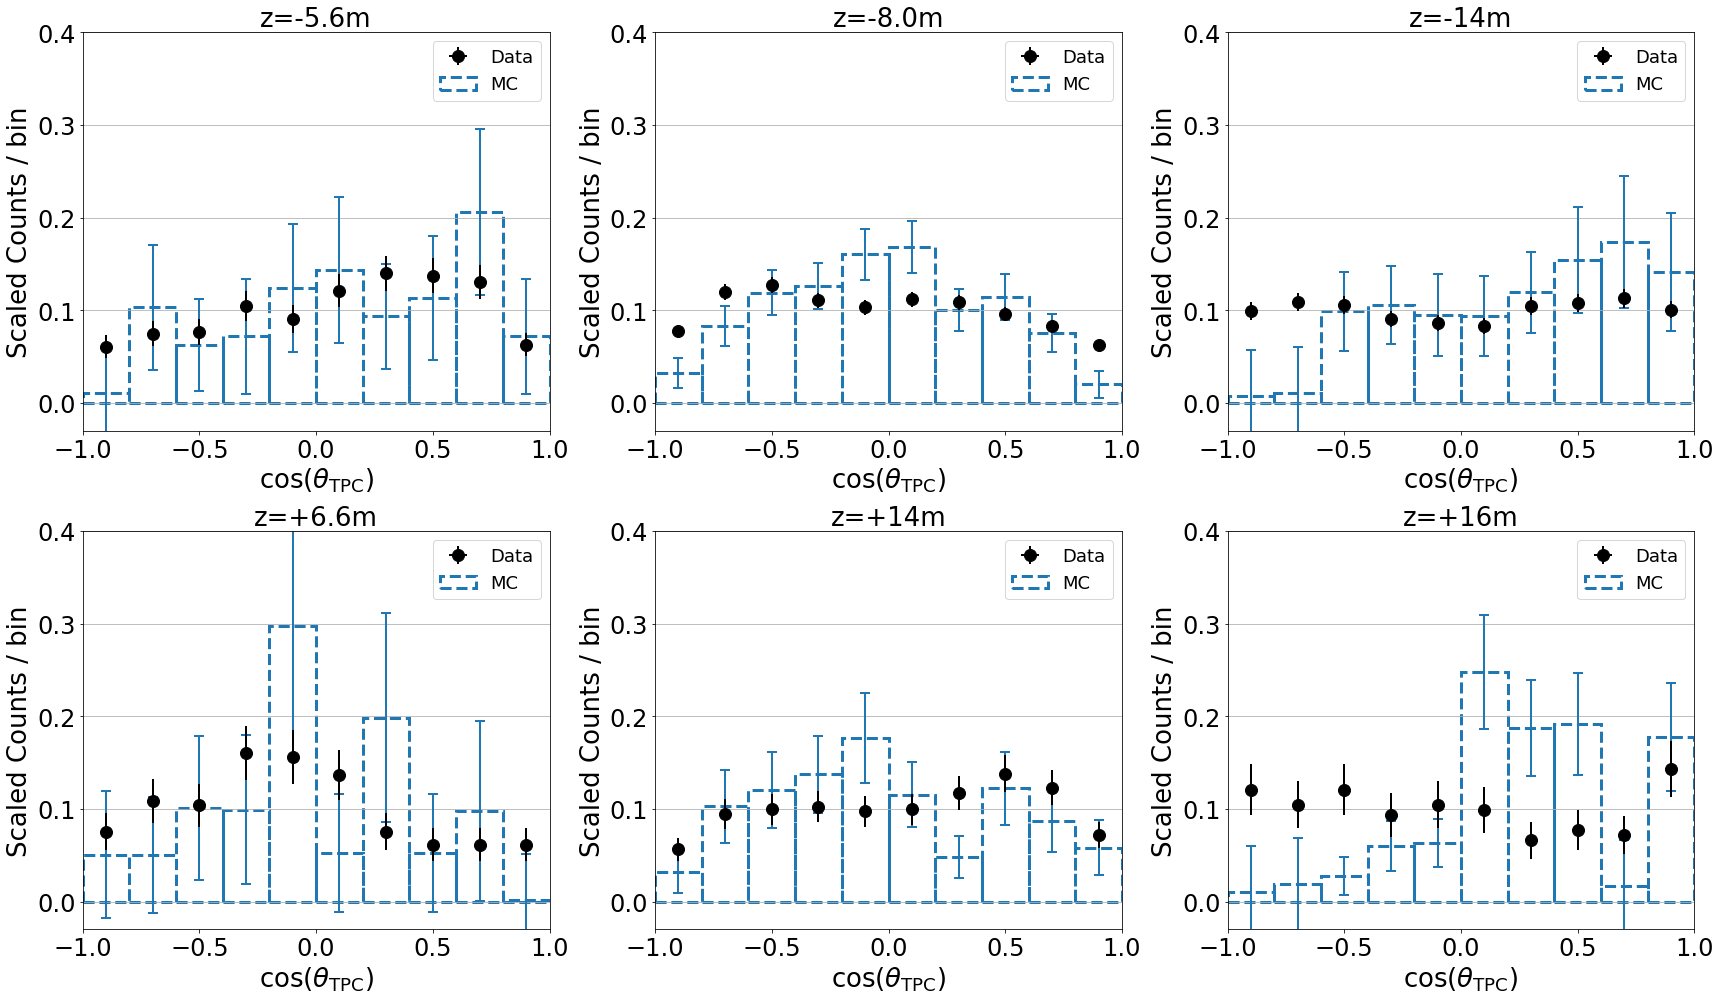

In [7]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
nbins = 11
xmin = -1
xmax = 1
phi_low = -np.pi/4
phi_high = np.pi/4
#E_cut = {'palila': 40, 'tako': 120, 'elepaio': 110, 'iiwi': 55, 'nene': 95, 'humu': 155}
#E_cut = {'palila': 40, 'tako': 67, 'elepaio': 150, 'iiwi': 100, 'nene': 75, 'humu': 135}
#E_cut = {'palila': 90,'tako': 145,'elepaio': 155,'iiwi': 110, 'nene': 135,'humu': 130}
#E_cut = {'palila': 30,'tako': 50,'elepaio': 100,'iiwi': 60, 'nene': 45,'humu': 100}
#E_cut = {'palila': 100,'tako': 160,'elepaio': 140,'iiwi': 100, 'nene': 130,'humu': 130}
#E_cut = {'palila': 100,'tako': 100,'elepaio': 100,'iiwi': 100, 'nene': 100,'humu': 100}
E_cut = {'palila': cut,'tako': cut,'elepaio': cut,'iiwi': cut, 'nene': cut,'humu': cut}
width = (np.abs(xmin)+np.abs(xmax))/(nbins-1)
center = [xmin +(width*i)+width/2 for i in range(0,nbins-1)]
tpcs = ['palila', 'tako', 'elepaio','iiwi', 'nene','humu']
pos = ['z=-5.6m', 'z=-8.0m', 'z=-14m', 'z=+6.6m', 'z=+14m', 'z=+16m']#
#tpcs = ['iiwi', 'nene', 'humu']
#pos = ['z=+6.5m', 'z=+14m', 'z=+16m']
#tpcs = ['iiwi']
#pos = ['z=+6.6m']
n0 = {}
d0 = {}
p0 = {}
nerr0 = {}
derr0 = {}
err0 = {}
n1 = {}
d1 = {}
p1 = {}
err1 = {}
n2 = {}
d2 = {}
p2 = {}
err2 = {}
n3 = {}
d3 = {}
p3 = {}
nerr3 = {}
derr3 = {}
err3 = {}
n4 = {}
d4 = {}
p4 = {}
nerr4 = {}
derr4 = {}
err4 = {}
plt.figure(figsize = (24,14))
i=1
j=1
for tpc in tpcs:
    data[tpc]['ones'] = 1
    Lumi[tpc]['ones'] = 1
    Single_beam[tpc]['ones'] = 1
    HER[tpc]['ones'] = 1
    LER[tpc]['ones'] = 1
    #Scaled_MC[tpc]['counts'] = 1
    
    ### CUTS ###
    data_tmp = data[tpc].loc[(np.abs(data[tpc]['new_phi'])<phi_high) & (np.abs(data[tpc]['new_phi'])>phi_low)]
    Lumi_tmp = Lumi[tpc].loc[(np.abs(Lumi[tpc]['new_phi'])<phi_high) & (np.abs(Lumi[tpc]['new_phi'])>phi_low)]
    MC_tmp = Scaled_MC[tpc].loc[(np.abs(Scaled_MC[tpc]['new_phi'])<phi_high) & (np.abs(Scaled_MC[tpc]['new_phi'])>phi_low)]
    MC_tmp2 = MC_tmp.loc[MC_tmp['VRC_id']==5]
    MC_tmp2.index = [i for i in range(0,len(MC_tmp2))]
    SB_tmp = Single_beam[tpc].loc[(np.abs(Single_beam[tpc]['new_phi'])<phi_high) & (np.abs(Single_beam[tpc]['new_phi'])>phi_low)]
    HER_tmp = HER[tpc].loc[(np.abs(HER[tpc]['new_phi'])<phi_high) & (np.abs(HER[tpc]['new_phi'])>phi_low)]
    LER_tmp = LER[tpc].loc[(np.abs(LER[tpc]['new_phi'])<phi_high) & (np.abs(LER[tpc]['new_phi'])>phi_low)]
    
    data_tmp = data_tmp.loc[data_tmp['track_energy']>E_cut[tpc]]
    Lumi_tmp = Lumi_tmp.loc[Lumi_tmp['track_energy']>E_cut[tpc]]
    MC_tmp = MC_tmp.loc[MC_tmp['reco_energy']>E_cut[tpc]]
    MC_tmp2 = MC_tmp2.loc[MC_tmp2['reco_energy']>E_cut[tpc]] #no lumi
    MC_tmp3 = MC_tmp.loc[MC_tmp['reco_energy']>E_cut[tpc]] #hotspots
    SB_tmp = SB_tmp.loc[SB_tmp['track_energy']>E_cut[tpc]]
    HER_tmp = HER_tmp.loc[HER_tmp['track_energy']>E_cut[tpc]]
    LER_tmp = LER_tmp.loc[LER_tmp['track_energy']>E_cut[tpc]]
    
    ############
    
    #MC_tmp2 = MC_tmp2.loc[(MC_tmp2['bgType'] != 'twoPhoton_Lumi') & (MC_tmp2['bgType'] != 'RBB_Lumi')]
    #MC_tmp2.index = [i for i in range(0,len(MC_tmp2))]
    
    ##### BEFORE BINNING COMPUTE KS TEST#####
    
    #print(tpc, scipy.stats.ks_2samp(np.cos(Lumi_tmp['new_theta']),np.cos(MC_tmp['new_theta']))[1])
    
    
    test = Lumi_tmp.groupby(pd.cut(np.cos(Lumi_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_all = data_tmp.groupby(pd.cut(np.cos(data_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_MC = MC_tmp.groupby(pd.cut(np.cos(MC_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_MC2 = MC_tmp2.groupby(pd.cut(np.cos(MC_tmp2['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_SB = SB_tmp.groupby(pd.cut(np.cos(SB_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_HER = HER_tmp.groupby(pd.cut(np.cos(HER_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_LER = LER_tmp.groupby(pd.cut(np.cos(LER_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    
    #test = Lumi_tmp.groupby(pd.cut(Lumi_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_all = data_tmp.groupby(pd.cut(data_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_MC = MC_tmp.groupby(pd.cut(MC_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_MC2 = MC_tmp2.groupby(pd.cut(MC_tmp2['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_MC3 = MC_tmp3.groupby(pd.cut(MC_tmp3['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_SB = SB_tmp.groupby(pd.cut(SB_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_HER = HER_tmp.groupby(pd.cut(HER_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_LER = LER_tmp.groupby(pd.cut(LER_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    
    
    plt.subplot(2,3,i)
    
    ### Compute fractional coefficients for time of each background study. MC is already scaled to 1 equivalents
    foo = len(b.select_study("HER", "Cont_inj"))
    bar = len(b.select_study("LER", "Cont_inj"))
    lum = len(b.select_study("Lumi", "Cont_inj"))

    #clumi = 1/(lum) # Scale to 1s equivalent rate
    #cler = 1/(bar) # Scale to 1s equivalent rate
    #cher = 1/(foo) # Scale to 1s equivalent rate
    
    clumi = 1
    cler = 0
    cher = 0
    
    #plot 0: all data
    #n0[tpc] = (test_all['ones'])
    #d0[tpc] = (test_all['ones']).sum()
    #err0[tpc] = 1/d0[tpc]*np.sqrt(test['ones'])
    n0[tpc] = clumi*test['ones'] + cler*test_LER['ones'] + cher*test_HER['ones']
    d0[tpc] = (clumi*test['ones'] + cler*test_LER['ones'] + cher*test_HER['ones']).sum()
    nerr0[tpc] = np.sqrt(clumi**2*test['ones'] + cler**2*test_LER['ones'] + cher**2*test_HER['ones']+(0.1)**2)
    derr0[tpc] = np.sqrt((nerr0[tpc]**2).sum())
    err0[tpc] = n0[tpc]/d0[tpc]*np.sqrt((nerr0[tpc]/n0[tpc])**2+((derr0[tpc]/d0[tpc])**2))
    #err0[tpc] = nerr0[tpc]/d0[tpc]
    #n0[tpc] = clumi*test['ones']
    #d0[tpc] = (clumi*test['ones']).sum()
    #vals = []
    #for ent in range(0,len(n0[tpc])):
    #    val = (n0[tpc].sum()-n0[tpc][ent])*np.sqrt(n0[tpc][ent])
    #    vals.append(val)
    #nerr0[tpc] = pd.Series(vals)
    #derr0[tpc] = (n0[tpc].sum())**2
    #nerr0[tpc] = np.sqrt(clumi**2*test['ones'])
    #derr0[tpc] = np.sqrt((nerr0[tpc]**2).sum())
    #err0[tpc] = n0[tpc]/d0[tpc]*np.sqrt((nerr0[tpc]/n0[tpc])**2+((derr0[tpc]/d0[tpc])**2))
    #err0[tpc] = nerr0[tpc]/derr0[tpc]
    #p0[tpc] = plt.bar(center,n0[tpc]/d0[tpc] ,yerr = err0[tpc], width = width, label = 'Data', fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
    p0[tpc] = plt.errorbar(center,n0[tpc]/d0[tpc] ,err0[tpc], [0 for i in range(0,len(n0[tpc]))], 'o', markersize = 12, lw = 2, color = 'k', label = 'Data',zorder = 1e6)
    def get_MC_weights_and_errs(df = MC_tmp, nbins = nbins, xmin = xmin, xmax = xmax, cos = True):
        spacing = (xmax-xmin)/(nbins-1)
        npoints = int((xmax-xmin)/spacing)
        boundaries = np.linspace(xmin,xmax, npoints+1)
        errs = []
        weights_list = []
        for i in range(1,len(boundaries)):
            if cos == True:
                weights = MC_tmp.loc[(np.cos(MC_tmp['new_theta'])>boundaries[i-1]) & (np.cos(MC_tmp['new_theta'])<=boundaries[i])]['weights']
                weights_err = MC_tmp.loc[(np.cos(MC_tmp['new_theta'])>boundaries[i-1]) & (np.cos(MC_tmp['new_theta'])<=boundaries[i])]['weights_err']
            else:
                weights = MC_tmp.loc[(MC_tmp['new_theta']>boundaries[i-1]) & (MC_tmp['new_theta']<=boundaries[i])]['weights']
            #errs.append(np.sqrt((weights*weights.index.to_numpy()**2).sum())/weights.sum())
            #errs.append(np.sqrt((weights**2).sum())) #indices are actual weights..."weights" represents number of events with each assigned weight
            weights_list.append(weights.sum())
            #errs.append(np.sqrt(weights.sum()))
            errs.append(np.sqrt(weights.sum()/np.sqrt(len(weights))+(0.1)**2))
        return pd.Series(weights_list), pd.Series(errs)
    #if xmax >1.5:
    #    n3[tpc] = get_MC_weights_and_errs(df = MC_tmp, cos = False)[0]
    #    d3[tpc] = n3[tpc].sum()
    #    nerr3[tpc] = get_MC_weights_and_errs(df = MC_tmp, cos = False)[1]
    #    #derr3[tpc] = np.sqrt((nerr3[tpc]**2).sum())
    #    derr3[tpc] = (n3[tpc].sum())**2
    #    vals = []
    #    for ent in range(0,len(nerr3[tpc])):
    #        val = (n3[tpc].sum()-n3[tpc][ent])*nerr3[tpc][ent]
    #        vals.append(val)
    #else:
    #    n3[tpc] = get_MC_weights_and_errs(df = MC_tmp)[0]
    #    d3[tpc] = n3[tpc].sum()
    #    nerr3[tpc] = get_MC_weights_and_errs(df = MC_tmp)[1]
        #derr3[tpc] = np.sqrt((nerr3[tpc]**2).sum())
    #    derr3[tpc] = (n3[tpc].sum())**2
    #    vals = []
    #    for ent in range(0,len(nerr3[tpc])):
    #        val = (n3[tpc].sum()-n3[tpc][ent])*nerr3[tpc][ent]
    #        vals.append(val)
    #err3[tpc] = pd.Series(vals)/derr3[tpc]
    #err3[tpc] = n3[tpc]/d3[tpc]*np.sqrt((nerr3[tpc]/n3[tpc])**2+((derr3[tpc]/d3[tpc])**2))
    if xmax >1.5:
        n3[tpc] = get_MC_weights_and_errs(df = MC_tmp, cos = False)[0]
        d3[tpc] = n3[tpc].sum()
        nerr3[tpc] = get_MC_weights_and_errs(df = MC_tmp, cos = False)[1]
        derr3[tpc] = np.sqrt((nerr3[tpc]).sum())
    else:
        n3[tpc] = get_MC_weights_and_errs(df = MC_tmp, cos = True)[0]
        d3[tpc] = n3[tpc].sum()
        nerr3[tpc] = get_MC_weights_and_errs(df = MC_tmp, cos = True)[1]
        derr3[tpc] = np.sqrt((nerr3[tpc]).sum())
    err3[tpc] = n3[tpc]/d3[tpc]*np.sqrt((nerr3[tpc]/n3[tpc])**2+((derr3[tpc]/d3[tpc])**2))
    for k in range(0,len(err3[tpc])):
        if n3[tpc][k]/d3[tpc] < .02:
            err3[tpc][k] = .05
    err3[tpc] = err3[tpc].fillna(0.05)
    #err3[tpc] = nerr3[tpc]/d3[tpc]
    p3[tpc] = plt.bar(center,n3[tpc]/d3[tpc],yerr=err3[tpc],width = width, label = 'MC', fc = 'None', ec = 'tab:blue',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
    
    #print(tpc, scipy.stats.ks_2samp(n0[tpc],n3[tpc])[1])
    
    #Plot 4: All MC to be compared with collisions ACTUAL CHIP AREA
    n4[tpc] = get_MC_weights_and_errs(df = MC_tmp2)[0]
    d4[tpc] = n4[tpc].sum()
    nerr4[tpc] = get_MC_weights_and_errs(df = MC_tmp2, cos = True)[1]
    derr4[tpc] = np.sqrt((nerr4[tpc]**2).sum())
    err4[tpc] = get_MC_weights_and_errs(df = MC_tmp2)[1]/d4[tpc]
    for k in range(0,len(err4[tpc])): #make error 10% when values are zero
        if n4[tpc][k]/d4[tpc] < 1e-2:
            err4[tpc][k] = .05
    err4[tpc] = err4[tpc].fillna(0.05)
    #p4[tpc] = plt.bar(center,n4[tpc]/d4[tpc],yerr=err4[tpc],width = width, label = 'MC expanded chip', fc = 'None', ec = 'tab:green',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='tab:green', lw=2, capsize=5, capthick=2))
  

    #Plot 4: All MC to be compared with collisions ACTUAL CHIP AREA
    #n4[tpc] = (test_MC2['ones']*(test_MC2['scaled_energy']/test_MC2['reco_energy']))
    #d4[tpc] = (test_MC2['ones']*(test_MC2['scaled_energy']/test_MC2['reco_energy'])).sum()
    #err4[tpc] = 1/d4[tpc]*np.sqrt(test_MC2['ones']*(test_MC2['scaled_energy']**2/test_MC2['reco_energy']**2).mean())
    #n4[tpc] = (test_MC2['ones'])
    #d4[tpc] = (test_MC2['ones']).sum()
    #err4[tpc] = 1/d4[tpc]*np.sqrt(test_MC2['ones'])
    #p4[tpc] = plt.bar(center,n4[tpc]/d4[tpc],yerr=err4[tpc],width = width, label = 'MC', fc = 'None', ec = 'tab:green',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='tab:green', lw=2, capsize=5, capthick=2))
    
    #plt.hlines(0,0,1,color = 'k')
    plt.ylabel(r'Scaled Counts / bin')
    #plt.ylabel('Scaled Counts')
    plt.xlabel(r'$\cos(\theta_\mathrm{TPC})$')
    plt.xlim(xmin,xmax)
    plt.ylim(-0.03,0.4)
    plt.title(pos[j-1])
    plt.legend(handles = [p0[tpc],p3[tpc]],ncol=1)
    plt.grid(axis='y')
    
    j+=1
    i+=1
plt.tight_layout()
plt.savefig("costheta_newest.png",bbox_inches = 'tight', dpi = 200)
plt.show()
#np.sqrt((test_err/test['track_energy'].sum())**2+(test_MC_err/test_MC['reco_energy'].sum())**2)

In [ ]:
Lumi['iiwi']['ones'] = len(Lumi['iiwi'].loc[(np.abs(Lumi['iiwi']['new_phi'])>-np.pi/6) & (np.abs(Lumi['iiwi']['new_phi'])<np.pi/6) & (np.abs(Lumi['iiwi']['track_energy'])>70)])
Lumi['nene']['ones'] = len(Lumi['nene'].loc[(np.abs(Lumi['nene']['new_phi'])>-np.pi/6) & (np.abs(Lumi['nene']['new_phi'])<np.pi/6) & (np.abs(Lumi['nene']['track_energy'])>70)])
Lumi['humu']['ones'] = len(Lumi['humu'].loc[(np.abs(Lumi['humu']['new_phi'])>-np.pi/6) & (np.abs(Lumi['humu']['new_phi'])<np.pi/6) & (np.abs(Lumi['humu']['track_energy'])>70)])
Lumi['humu']['ones'] = Lumi['humu']['ones'][0]/(Lumi['iiwi']['ones'][0]+Lumi['nene']['ones'][0]+Lumi['humu']['ones'][0])


In [ ]:
Lumi['humu']['ones']

In [ ]:
Lumi['tako']['ones'] = 1/0.532878
Lumi['palila']['ones'] = 1/0.122396
Lumi['elepaio']['ones'] = 1/0.344727
Lumi['iiwi']['ones'] = 1/0.272374
Lumi['nene']['ones'] = 1/0.455253
Lumi['humu']['ones'] = 1/0.272374

#NORMALIZE
#Lumi['tako']['ones'] = Lumi['tako']['ones'][0]/(Lumi['tako']['ones'][0]+Lumi['palila']['ones'][0]+Lumi['elepaio']['ones'][0])
#Lumi['palila']['ones'] = Lumi['palila']['ones'][0]/(Lumi['tako']['ones'][0]+Lumi['palila']['ones'][0]+Lumi['elepaio']['ones'][0])
#Lumi['elepaio']['ones'] = Lumi['elepaio']['ones'][0]/(Lumi['tako']['ones'][0]+Lumi['palila']['ones'][0]+Lumi['elepaio']['ones'][0])

#Lumi['iiwi']['ones'] = Lumi['humu']['ones'][0]/(Lumi['iiwi']['ones'][0]+Lumi['nene']['ones'][0]+Lumi['humu']['ones'][0])
#Lumi['nene']['ones'] = Lumi['humu']['ones'][0]/(Lumi['iiwi']['ones'][0]+Lumi['nene']['ones'][0]+Lumi['humu']['ones'][0])
#Lumi['humu']['ones'] = Lumi['humu']['ones'][0]/(Lumi['iiwi']['ones'][0]+Lumi['nene']['ones'][0]+Lumi['humu']['ones'][0])

In [ ]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
nbins = 21
xmin = -1
xmax = 1
phi_low = -np.pi/2
phi_high = np.pi/2
E_cut = {'palila': cut,'tako': cut,'elepaio': cut,'iiwi': cut, 'nene': cut,'humu': cut}
width = (np.abs(xmin)+np.abs(xmax))/(nbins-1)
center = [xmin +(width*i)+width/2 for i in range(0,nbins-1)]
pos = ['bwd','fwd']#
#COMBINE RELEVANT DATAFRAMES
Lum = {}
MC_combined = {}
Lum['bwd'] = Lumi['elepaio'].append(Lumi['tako'].append(Lumi['palila']))
Lum['fwd'] = Lumi['humu'].append(Lumi['nene'].append(Lumi['iiwi']))
MC_combined['bwd'] = Scaled_MC['elepaio'].append(Scaled_MC['tako'].append(Scaled_MC['palila']))
MC_combined['fwd'] = Scaled_MC['humu'].append(Scaled_MC['nene'].append(Scaled_MC['iiwi']))
for key in Lum.keys():
    Lum[key].index = [i for i in range(0,len(Lum[key]))]
    MC_combined[key].index = [i for i in range(0,len(MC_combined[key]))]

n0 = {}
d0 = {}
p0 = {}
nerr0 = {}
derr0 = {}
err0 = {}
n1 = {}
d1 = {}
p1 = {}
nerr1 = {}
derr1 = {}
err1 = {}
n2 = {}
d2 = {}
p2 = {}
nerr2 = {}
derr2 = {}
err2 = {}

plt.figure(figsize = (24,11))
i=1
j=1
for key in ['bwd', 'fwd']:
    #Lum['bwd']['ones'] = 1 #UNCOMMENT TO UNWEIGHT OTHERWISE SUMS ARE WEIGHTED AVERAGES
    
    ### CUTS ###
    Lum_tmp = Lum[key].loc[(np.abs(Lum[key]['new_phi'])<phi_high) & (np.abs(Lum[key]['new_phi'])>phi_low)]
    MC_combined_tmp = MC_combined[key].loc[(np.abs(MC_combined[key]['new_phi'])<phi_high) & (np.abs(MC_combined[key]['new_phi'])>phi_low)]
    MC_combined_tmp2 = MC_combined_tmp.loc[MC_combined_tmp['VRC_id']==5] #only actual chip area
    MC_combined_tmp2.index = [i for i in range(0,len(MC_combined_tmp2))]
    Lum_tmp = Lum_tmp.loc[Lum_tmp['track_energy']>cut]
    MC_combined_tmp = MC_combined_tmp.loc[MC_combined_tmp['reco_energy']>cut]
    MC_combined_tmp2 = MC_combined_tmp2.loc[MC_combined_tmp2['reco_energy']>cut]
    
    test_combined = Lum_tmp.groupby(pd.cut(np.cos(Lum_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_combined_MC = MC_combined_tmp.groupby(pd.cut(np.cos(MC_combined_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_combined_MC2 = MC_combined_tmp2.groupby(pd.cut(np.cos(MC_combined_tmp2['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    
    #test_combined = Lum_tmp.groupby(pd.cut(Lum_tmp['new_theta'], bins = np.linspace(xmin,xmax,nbins))).sum()
    #test_combined_MC = MC_combined_tmp.groupby(pd.cut(MC_combined_tmp['new_theta'], bins = np.linspace(xmin,xmax,nbins))).sum()
    #test_combined_MC2 = MC_combined_tmp2.groupby(pd.cut(MC_combined_tmp2['new_theta'], bins = np.linspace(xmin,xmax,nbins))).sum()
    
 
    
    plt.subplot(1,2,i)
    
    n0[key] = test_combined['ones']
    d0[key] = (test_combined['ones']).sum()
    nerr0[key] = np.sqrt(test_combined['ones'])
    derr0[key] = np.sqrt((nerr0[key]**2).sum())
    err0[key] = n0[key]/d0[key]*np.sqrt((nerr0[key]/n0[key])**2+((derr0[key]/d0[key])**2))
    p0[key] = plt.bar(center,n0[key]/d0[key] ,yerr = err0[key], width = width, label = 'Data', fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
      
    def get_MC_weights_and_errs(df = MC_combined_tmp, nbins = nbins, xmin = xmin, xmax = xmax, cos = True):
        spacing = (xmax-xmin)/(nbins-1)
        npoints = int((xmax-xmin)/spacing)
        boundaries = np.linspace(xmin,xmax, npoints+1)
        errs = []
        weights_list = []
        for i in range(1,len(boundaries)):
            if cos == True:
                weights = df.loc[(np.cos(df['new_theta'])>boundaries[i-1]) & (np.cos(df['new_theta'])<=boundaries[i])]['weights']
            else:
                weights = df.loc[(df['new_theta']>boundaries[i-1]) & (df['new_theta']<=boundaries[i])]['weights']
            errs.append(np.sqrt((weights**2).sum())) #indices are actual weights..."weights" represents number of events with each assigned weight
            weights_list.append(weights.sum())
        return pd.Series(weights_list), pd.Series(errs)
    if xmax > 1:
        n1[key] = get_MC_weights_and_errs(df = MC_combined_tmp, cos = False)[0]
    else:
        n1[key] = get_MC_weights_and_errs(df = MC_combined_tmp, cos = True)[0]
    d1[key] = n1[key].sum()
    nerr1[key] = get_MC_weights_and_errs(df = MC_combined_tmp)[1]
    derr1[key] = np.sqrt((nerr1[key]**2).sum())
    err1[key] = n1[key]/d1[key]*np.sqrt((nerr1[key]/n1[key])**2+((derr1[key]/d1[key])**2))
    for k in range(0,len(err1[key])):
        if n1[key][k]/d1[key] < .001:
            err1[key][k] = .05
    err1[key] = err1[key].fillna(0.05)
    #err3[tpc] = nerr3[tpc]/d3[tpc]
    p1[key] = plt.bar(center,n1[key]/d1[key],yerr=err1[key],width = width, label = 'MC', fc = 'None', ec = 'tab:red',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='tab:red', lw=2, capsize=5, capthick=2))
    

    n2[key] = get_MC_weights_and_errs(df = MC_combined_tmp2)[0]
    d2[key] = n2[key].sum()
    err2[key] = get_MC_weights_and_errs(df = MC_combined_tmp2)[1]/d2[key]
    for k in range(0,len(err2[key])): #make error 10% when values are zero
        if n2[key][k]/d2[key] < .05:
            err2[key][k] = .05
    err2[key] = err2[key].fillna(0.05)
    #p2[key] = plt.bar(center,n2[key]/d2[key],yerr=err2[key],width = width, label = 'MC', fc = 'None', ec = 'tab:green',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='tab:green', lw=2, capsize=5, capthick=2))
    
    plt.ylabel(r'Scaled Counts')
    plt.xlabel(r'$\cos(\theta)$')
    plt.xlim(xmin,xmax)
    plt.ylim(-0.03,0.18)
    plt.title(pos[j-1])
    plt.legend(handles = [p0[key],p1[key]],ncol=1)
    plt.grid(axis='y')
    
    j+=1
    i+=1
plt.tight_layout()
#plt.savefig("angular_distributions_combined.png",bbox_inches='tight',dpi = 200)
plt.show()
#np.sqrt((test_err/test['track_energy'].sum())**2+(test_MC_err/test_MC['reco_energy'].sum())**2)


In [ ]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
nbins = 21
xmin = -np.pi/2
xmax = np.pi/2
phi_low = -np.pi/2
phi_high = np.pi/2
E_cut = {'palila': cut,'tako': cut,'elepaio': cut,'iiwi': cut, 'nene': cut,'humu': cut}
width = (np.abs(xmin)+np.abs(xmax))/(nbins-1)
center = [xmin +(width*i)+width/2 for i in range(0,nbins-1)]
pos = ['bwd','fwd']#
#COMBINE RELEVANT DATAFRAMES
Lum = {}
MC_combined = {}
Lum['bwd'] = Lumi['elepaio'].append(Lumi['tako'].append(Lumi['palila']))
Lum['fwd'] = Lumi['humu'].append(Lumi['nene'].append(Lumi['iiwi']))
MC_combined['bwd'] = Scaled_MC['elepaio'].append(Scaled_MC['tako'].append(Scaled_MC['palila']))
MC_combined['fwd'] = Scaled_MC['humu'].append(Scaled_MC['nene'].append(Scaled_MC['iiwi']))
for key in Lum.keys():
    Lum[key].index = [i for i in range(0,len(Lum[key]))]
    MC_combined[key].index = [i for i in range(0,len(MC_combined[key]))]

n0 = {}
d0 = {}
p0 = {}
nerr0 = {}
derr0 = {}
err0 = {}
n1 = {}
d1 = {}
p1 = {}
nerr1 = {}
derr1 = {}
err1 = {}
n2 = {}
d2 = {}
p2 = {}
nerr2 = {}
derr2 = {}
err2 = {}

plt.figure(figsize = (24,11))
i=1
j=1
for key in ['bwd', 'fwd']:
    #Lum['bwd']['ones'] = 1 #UNCOMMENT TO UNWEIGHT OTHERWISE SUMS ARE WEIGHTED AVERAGES
    
    ### CUTS ###
    Lum_tmp = Lum[key].loc[(np.abs(Lum[key]['new_phi'])<phi_high) & (np.abs(Lum[key]['new_phi'])>phi_low)]
    MC_combined_tmp = MC_combined[key].loc[(np.abs(MC_combined[key]['new_phi'])<phi_high) & (np.abs(MC_combined[key]['new_phi'])>phi_low)]
    MC_combined_tmp2 = MC_combined_tmp.loc[MC_combined_tmp['VRC_id']==5] #only actual chip area
    MC_combined_tmp2.index = [i for i in range(0,len(MC_combined_tmp2))]
    Lum_tmp = Lum_tmp.loc[Lum_tmp['track_energy']>cut]
    MC_combined_tmp = MC_combined_tmp.loc[MC_combined_tmp['reco_energy']>cut]
    MC_combined_tmp2 = MC_combined_tmp2.loc[MC_combined_tmp2['reco_energy']>cut]
    
    #test_combined = Lum_tmp.groupby(pd.cut(np.cos(Lum_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    #test_combined_MC = MC_combined_tmp.groupby(pd.cut(np.cos(MC_combined_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    #test_combined_MC2 = MC_combined_tmp2.groupby(pd.cut(np.cos(MC_combined_tmp2['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    
    test_combined = Lum_tmp.groupby(pd.cut(Lum_tmp['new_phi'], bins = np.linspace(xmin,xmax,nbins))).sum()
    test_combined_MC = MC_combined_tmp.groupby(pd.cut(MC_combined_tmp['new_phi'], bins = np.linspace(xmin,xmax,nbins))).sum()
    test_combined_MC2 = MC_combined_tmp2.groupby(pd.cut(MC_combined_tmp2['new_phi'], bins = np.linspace(xmin,xmax,nbins))).sum()
    
 
    
    plt.subplot(1,2,i)
    
    n0[key] = test_combined['ones']
    d0[key] = (test_combined['ones']).sum()
    nerr0[key] = np.sqrt(test_combined['ones'])
    derr0[key] = np.sqrt((nerr0[key]**2).sum())
    err0[key] = n0[key]/d0[key]*np.sqrt((nerr0[key]/n0[key])**2+((derr0[key]/d0[key])**2))
    p0[key] = plt.bar(center,n0[key]/d0[key] ,yerr = err0[key], width = width, label = 'Data', fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
      
    def get_MC_weights_and_errs(df = MC_combined_tmp, nbins = nbins, xmin = xmin, xmax = xmax):
        spacing = (xmax-xmin)/(nbins-1)
        npoints = int((xmax-xmin)/spacing)
        boundaries = np.linspace(xmin,xmax, npoints+1)
        errs = []
        weights_list = []
        for i in range(1,len(boundaries)):
            weights = df.loc[(df['new_phi']>boundaries[i-1]) & (df['new_phi']<=boundaries[i])]['weights']
            errs.append(np.sqrt((weights**2).sum())) #indices are actual weights..."weights" represents number of events with each assigned weight
            weights_list.append(weights.sum())
        return pd.Series(weights_list), pd.Series(errs)
    n1[key] = get_MC_weights_and_errs(df = MC_combined_tmp)[0]

    d1[key] = n1[key].sum()
    nerr1[key] = get_MC_weights_and_errs(df = MC_combined_tmp)[1]
    derr1[key] = np.sqrt((nerr1[key]**2).sum())
    err1[key] = n1[key]/d1[key]*np.sqrt((nerr1[key]/n1[key])**2+((derr1[key]/d1[key])**2))
    for k in range(0,len(err1[key])):
        if n1[key][k]/d1[key] < .001:
            err1[key][k] = .05
    err1[key] = err1[key].fillna(0.05)
    #err3[tpc] = nerr3[tpc]/d3[tpc]
    p1[key] = plt.bar(center,n1[key]/d1[key],yerr=err1[key],width = width, label = 'MC', fc = 'None', ec = 'tab:red',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='tab:red', lw=2, capsize=5, capthick=2))
    

    n2[key] = get_MC_weights_and_errs(df = MC_combined_tmp2)[0]
    d2[key] = n2[key].sum()
    err2[key] = get_MC_weights_and_errs(df = MC_combined_tmp2)[1]/d2[key]
    for k in range(0,len(err2[key])): #make error 10% when values are zero
        if n2[key][k]/d2[key] < .05:
            err2[key][k] = .05
    err2[key] = err2[key].fillna(0.05)
    #p2[key] = plt.bar(center,n2[key]/d2[key],yerr=err2[key],width = width, label = 'MC', fc = 'None', ec = 'tab:green',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='tab:green', lw=2, capsize=5, capthick=2))
    
    plt.ylabel(r'Scaled Counts')
    plt.xlabel(r'$\phi$')
    plt.xlim(xmin,xmax)
    plt.ylim(0,0.12)
    plt.title(pos[j-1])
    plt.legend(handles = [p0[key],p1[key]],ncol=1)
    plt.grid(axis='y')
    
    j+=1
    i+=1
plt.tight_layout()
plt.savefig("angular_distributions_combined_phi.png",bbox_inches='tight',dpi = 200)
plt.show()
#np.sqrt((test_err/test['track_energy'].sum())**2+(test_MC_err/test_MC['reco_energy'].sum())**2)


In [ ]:
import array
def perform_root_chi2_test(data1,data2,err1,err2,xmin = xmin, xmax = xmax):
    n = len(data1)
    res = array.array('d', [0 for i in range(0,n)])
    chi2 = array.array('d', [0])
    ndf = array.array('i', [0])
    igood = array.array('i', [0])
    option = "WW P"
    h1 = ROOT.TH1D("h1", "h1", n, xmin, xmax)
    h2 = ROOT.TH1D("h2", "h2", n, xmin, xmax)
    for i in range(0,len(data1)):
        h1.SetBinContent(i+1,data1.fillna(0)[i])
        try:
            h1.SetBinError(i+1,err1.fillna(0)[i])
        except:
            h1.SetBinError(i+1,err1)
        h2.SetBinContent(i+1,data2.fillna(0)[i])
        try:
            h2.SetBinError(i+1,err2.fillna(0)[i])
        except:
            h2.SetBinError(i+1,err2)
    test = h1.Chi2TestX(h2, chi2, ndf, igood, option, res=res)
    return h1, h2, chi2, test, ndf
p = {}
for tpc in tpcs:
#for tpc in ['bwd','fwd']:
    h1,h2,res,p[tpc],ndf = perform_root_chi2_test(n0[tpc]/d0[tpc],n3[tpc]/d3[tpc],err0[tpc],err3[tpc])

In [ ]:
p

In [ ]:
import scipy.stats
for tpc in tpcs:
#for tpc in ['bwd','fwd']:
    print(tpc, scipy.stats.ks_2samp(n0[tpc]/d0[tpc],n3[tpc]/d3[tpc])[1])
    #print(tpc, scipy.stats.mstats.ks_twosamp(n0[tpc]/d0[tpc],n3[tpc]/d3[tpc])[1])

In [ ]:
c1 = ROOT.TCanvas("c1","c1",800,600)
f = ROOT.TF1("f","TMath::Gaus(x,0,1)",-10,10)
qqplot = ROOT.TGraphQQ(len(n1),res,f)
qqplot.SetMarkerStyle(20)
qqplot.SetMarkerColor(2)
qqplot.SetMarkerSize(.9)
qqplot.SetTitle("Q-Q plot of Normalized Residuals")
qqplot.Draw("AP")
c1.Draw()

In [ ]:
def perform_chi2_vs_uniform(data,err,xmin = xmin, xmax = xmax):
    n = len(data)
    h1 = ROOT.TH1D("h1", "h1", n, xmin, xmax)
    h2 = ROOT.TH1D("h2", "h2", n, xmin, xmax)
    for i in range(0,len(data)):
        h1.SetBinContent(i+1,data[i])
        h1.SetBinError(i+1,err.fillna(0)[i])
        h2.SetBinContent(i+1,1/n)
        h2.SetBinError(i+1,np.sqrt((xmax-xmin)**2/12)/(n*np.sqrt(n)))
    val = h1.Chi2Test(h2,"WW P")
    return h1, h2, val
h1,h2,val = perform_chi2_vs_uniform(n1/d1,err1)

In [ ]:
def compute_test_statistic(n1,n2,d1=1,d2=1):
    return np.sum((n1/d1-n2/d2)**2/(n1/d1**2+n2/d2**2))
compute_test_statistic(n1,n5,d1,d5)

In [ ]:
from scipy import stats
stats.ks_2samp(, n4)


In [ ]:
c1 = ROOT.TCanvas("c1","c1",800,600)
h1.Draw()
h2.Draw('SAME')
c1.Draw()

In [ ]:
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=22)
plt.rc('axes', titlesize=22)
plt.figure(figsize = (20,25))
i = 1
j=1
pos = ['z=16m', 'z=14m', 'z=6.5m', 'z=-5.5m', 'z=-8.0m', 'z=-14m']
for tpc in ['humu', 'nene', 'iiwi', 'palila', 'tako', 'elepaio']:
    plt.subplot(6,3,i+1)
    a1,b1,c1,d1 = plt.hist2d(Lumi[tpc]['new_theta'], Lumi[tpc]['new_phi'], bins=(11,11), range=((0,np.pi),(0,np.pi)), density=None, vmin = 0, weights=Lumi[tpc]['track_energy']/Lumi[tpc]['track_energy'].sum())
    plt.colorbar(d1).set_label(r'$\Sigma E$ per bin [keV]', rotation = 270, labelpad = 20)
    plt.title('Lumi ' + pos[j-1])
    #plt.yticks([-90,-60,-30,0,30,60,90])
    plt.ylabel(r'$\phi[^\circ]$')
    plt.xlabel(r'$|\cos(\theta)|$')
    plt.subplot(6,3,i)
    a2,b2,c2,d2 = plt.hist2d(Single_beam[tpc]['new_theta'], Single_beam[tpc]['new_phi'], bins=(11,11), range=((0,np.pi),(0,np.pi)), density=None, vmin = 0, weights=Single_beam[tpc]['track_energy']/Single_beam[tpc]['track_energy'].sum())
    plt.colorbar(d2).set_label(r'$\Sigma E$ per bin [keV]', rotation = 270, labelpad = 20)
    plt.title('Single Beam ' + pos[j-1])
    #plt.yticks([-90,-60,-30,0,30,60,90])
    plt.ylabel(r'$\phi[^\circ]$')
    plt.xlabel(r'$|\cos(\theta)|$')
    plt.subplot(6,3,i+2)
    a3,b3,c3,d3 = plt.hist2d(MC[tpc]['new_theta'], MC[tpc]['new_phi'], bins=(11,11), range=((0,np.pi),(0,np.pi)), density=None, vmin = 0, weights=MC[tpc]['reco_energy']/MC[tpc]['reco_energy'].sum())
    plt.colorbar(d2).set_label(r'$\Sigma E$ per bin [keV]', rotation = 270, labelpad = 20)
    plt.title('MC ' + pos[j-1])
    #plt.yticks([-90,-60,-30,0,30,60,90])
    plt.ylabel(r'$\phi[^\circ]$')
    plt.xlabel(r'$|\cos(\theta)|$')
    i+=3
    j+=1
plt.tight_layout()
plt.show()

In [ ]:
tpc = 'tako'
nbins = 21
Lumi_tmp = Lumi[tpc].loc[(np.abs(Lumi[tpc]['new_phi'])<np.pi/6) | (np.abs(Lumi[tpc]['new_phi'])>5*np.pi/6)]
MC_tmp = Scaled_MC[tpc].loc[(np.abs(Scaled_MC[tpc]['new_phi'])<np.pi/6) | (np.abs(Scaled_MC[tpc]['new_phi'])>5*np.pi/6)]
SB_tmp = Single_beam[tpc].loc[(np.abs(Single_beam[tpc]['new_phi'])<np.pi/6) | (np.abs(Single_beam[tpc]['new_phi'])>5*np.pi/6)]
HER_tmp = HER[tpc].loc[(np.abs(HER[tpc]['new_phi'])<np.pi/6) | (np.abs(HER[tpc]['new_phi'])>5*np.pi/6)]
LER_tmp = LER[tpc].loc[(np.abs(LER[tpc]['new_phi'])<np.pi/6) | (np.abs(LER[tpc]['new_phi'])>5*np.pi/6)]
    
Lumi_tmp = Lumi_tmp.loc[Lumi_tmp['track_energy']>0]
MC_tmp = MC_tmp.loc[MC_tmp['reco_energy']>0]
MC_tmp2 = MC_tmp.loc[MC_tmp['reco_energy']>0]
MC_tmp3 = MC_tmp.loc[MC_tmp['reco_energy']>0]
SB_tmp = SB_tmp.loc[SB_tmp['track_energy']>0]
HER_tmp = HER_tmp.loc[HER_tmp['track_energy']>0]
LER_tmp = LER_tmp.loc[LER_tmp['track_energy']>0]

MC_tmp2 = MC_tmp2.loc[((MC_tmp2['truth_mother_Z']>-870) & #Line is for RBB hotspot
               (MC_tmp2['truth_mother_Z']<=-750) & (MC_tmp2['truth_mother_X']>20) &
                                       (MC_tmp2['truth_mother_X']<=60) &
                                       (np.abs(MC_tmp2['truth_mother_Y'])<20))
                                      |                                
                                      (MC_tmp2['truth_mother_Z']>1390) &
                                      (MC_tmp2['truth_mother_Z']<=1680) &
                                      (MC_tmp2['truth_mother_X']<80) &
                                      (MC_tmp2['truth_mother_X']>=30) &
                                      (np.abs(MC_tmp2['truth_mother_Y'])<20)] #FWD and BWD hotspots
MC_tmp2.index = [i for i in range(0,len(MC_tmp2))]

MC_tmp3 = MC_tmp3.loc[((MC_tmp3['truth_mother_Z']<=-870) | #Line is for RBB hotspot
               (MC_tmp3['truth_mother_Z']>-750) | (MC_tmp3['truth_mother_X']<=20) |
                                       (MC_tmp3['truth_mother_X']>60) |
                                       (np.abs(MC_tmp3['truth_mother_Y'])>=20))
                                      &                                
                                      (MC_tmp3['truth_mother_Z']<=1390) |
                                      (MC_tmp3['truth_mother_Z']>1680) |
                                      (MC_tmp3['truth_mother_X']>=80) |
                                      (MC_tmp3['truth_mother_X']<30) |
                                      (np.abs(MC_tmp3['truth_mother_Y'])>=20)] #FWD and BWD hotspots

(counts, bins) = np.histogram(Lumi_tmp['new_theta'], bins=nbins, range = (0,np.pi), weights = Lumi_tmp['track_energy'])
factor = 1/(len(Lumi_tmp))
plt.hist(bins[:-1], bins, weights=factor*counts, label = 'Data Lumi', histtype = 'step')
(counts_MC2, bins_MC2) = np.histogram(MC_tmp2['new_theta'], bins=nbins, range = (0,np.pi), weights = MC_tmp2['reco_energy'])
factor_MC2 = 1/(len(MC_tmp2))
plt.hist(bins_MC2[:-1], bins_MC2, weights=factor_MC2*counts_MC2, label = 'MC Hotspot', histtype = 'step')
(counts_MC3, bins_MC3) = np.histogram(MC_tmp3['new_theta'], bins=nbins, range = (0,np.pi), weights = MC_tmp3['reco_energy'])
factor_MC3 = 1/len(MC_tmp3)
plt.hist(bins_MC3[:-1], bins_MC3, weights=factor_MC3*counts_MC3, label = 'MC Not Hotspot', histtype = 'step')
    

#plt.hist(np.cos(Lumi['tako']['new_theta']), bins = 21, range = (-1,1), histtype = 'step')
#plt.hist(np.cos(MC['tako']['new_theta']), bins = 21, range = (-1,1), histtype = 'step')

In [ ]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
nbins = 11
width = 1/(nbins-1)
center = [(width*i)+width/2 for i in range(0,nbins-1)]
#tpcs = ['palila','tako', 'elepaio']
#pos = ['z=-5.5m', 'z=-8.0m', 'z=-14m']#
#tpcs = ['palila', 'iiwi', 'tako']#, 'nene', 'elepaio', 'humu']
#pos = ['z=-5.5m', 'z=+6.5m', 'z=-8.0m']#, 'z=+14m', 'z=-14m', 'z=+16m']
tpcs = ['tako']
pos = ['z=-8.0m']
plt.figure(figsize = (11,8))
i=1
j=1
for tpc in tpcs:
    Lumi[tpc]['ones'] = 1
    Single_beam[tpc]['ones'] = 1
    HER[tpc]['ones'] = 1
    LER[tpc]['ones'] = 1
    Scaled_MC[tpc]['counts'] = 1
    
    ### CUTS ###
    Lumi_tmp = Lumi[tpc].loc[np.abs(Lumi[tpc]['phi_fold'])<30]
    MC_tmp = Scaled_MC[tpc].loc[np.abs(Scaled_MC[tpc]['phi_fold'])<30]
    SB_tmp = Single_beam[tpc].loc[np.abs(Single_beam[tpc]['phi_fold'])<30]
    HER_tmp = HER[tpc].loc[np.abs(HER[tpc]['phi_fold'])<30]
    LER_tmp = LER[tpc].loc[np.abs(LER[tpc]['phi_fold'])<30]
    
    Lumi_tmp = Lumi_tmp.loc[Lumi_tmp['track_energy']>40]
    MC_tmp = MC_tmp.loc[MC_tmp['reco_energy']>40]
    MC_tmp2 = MC_tmp.loc[MC_tmp['reco_energy']>40]
    MC_tmp3 = MC_tmp.loc[MC_tmp['reco_energy']>40]
    SB_tmp = SB_tmp.loc[SB_tmp['track_energy']>40]
    HER_tmp = HER_tmp.loc[HER_tmp['track_energy']>40]
    LER_tmp = LER_tmp.loc[LER_tmp['track_energy']>40]
    
    ### We subtract what's below from the total MC sample to get MC from the hotspot
    
    MC_tmp2 = MC_tmp2.loc[((MC_tmp2['truth_mother_Z']<=-870) | #Line is for RBB hotspot
               (MC_tmp2['truth_mother_Z']>-750) | (MC_tmp2['truth_mother_X']<=20) |
                                       (MC_tmp2['truth_mother_X']>60) |
                                       (np.abs(MC_tmp2['truth_mother_Y'])>=20))
                                      &                                
                                      (MC_tmp2['truth_mother_Z']<=1390) |
                                      (MC_tmp2['truth_mother_Z']>1680) |
                                      (MC_tmp2['truth_mother_X']>=80) |
                                      (MC_tmp2['truth_mother_X']<30) |
                                      (np.abs(MC_tmp2['truth_mother_Y'])>=20)] #FWD and BWD hotspots
    MC_tmp2.index = [i for i in range(0,len(MC_tmp2))]
    ############
    
    MC_tmp3 = MC_tmp3.loc[(MC_tmp3['bgType'] != 'twoPhoton_Lumi') & (MC_tmp3['bgType'] != 'RBB_Lumi')]
    MC_tmp3.index = [i for i in range(0,len(MC_tmp3))]
    
    test = Lumi_tmp.groupby(pd.cut(np.abs(np.cos(Lumi_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_MC = MC_tmp.groupby(pd.cut(np.abs(np.cos(MC_tmp['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_MC2 = MC_tmp2.groupby(pd.cut(np.abs(np.cos(MC_tmp2['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_MC3 = MC_tmp3.groupby(pd.cut(np.abs(np.cos(MC_tmp3['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_SB = SB_tmp.groupby(pd.cut(np.abs(np.cos(SB_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_HER = HER_tmp.groupby(pd.cut(np.abs(np.cos(HER_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_LER = LER_tmp.groupby(pd.cut(np.abs(np.cos(LER_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    
    #plt.subplot(3,1,i)
    
    # Coefficients for collisions data
    clumi = 1
    cler = 0.0
    cher= 0.0
    
    #plot 1: Collisions
    n1 = (clumi*test['ones']*test['track_energy']-cher*scale_HER*test_HER['ones']*test_HER['track_energy']
         -cler*scale_LER*test_LER['ones']*test_LER['track_energy'])
    d1 = (clumi*test['ones']*test['track_energy']+cher*scale_HER*test_HER['ones']*test_HER['track_energy']
         +cler*scale_LER*test_LER['ones']*test_LER['track_energy']).sum()
     
    err1 = 1/d1*np.sqrt((np.sqrt(test['ones'])*(clumi*test['track_energy']))**2 + (np.sqrt(test_HER['ones'])*(cher*scale_HER*test_HER['track_energy']))**2 + (np.sqrt(test_LER['ones'])*(cler*scale_LER*test_LER['track_energy']))**2)/np.sqrt(len(test['ones']))
    
     
    p1 = plt.bar(center,(d1.sum()/n1.sum())*n1/d1,yerr = 3*err1, width = width, label = 'Collisions', fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
    
    #Plot 2: MC hotspot
    n2 = (test_MC['ones']*test_MC['reco_energy']-test_MC2['ones']*test_MC2['reco_energy'])
    
    d2 = (test_MC['ones']*test_MC['reco_energy'].sum()+test_MC2['ones']*test_MC2['reco_energy']).sum()
 
    err2 = np.sqrt((test_MC['ones']+test_MC2['ones'])/(test_MC['counts']+test_MC2['counts']))/d2*np.sqrt((np.sqrt(test_MC['ones'])*(test_MC['reco_energy']))**2 + (np.sqrt(test_MC2['ones'])*(test_MC2['reco_energy']))**2)/np.sqrt(len(test_MC))
    
    p2 = plt.bar(center,(d2.sum()/n2.sum())*n2/d2,yerr=3*err2,width = width, label = 'MC Hotspot', fc = 'None', ec = 'tab:green',lw=3, error_kw=dict(ecolor='tab:green', lw=2, capsize=5, capthick=2))
    
    print((d2.sum()/n2.sum())*n2/d2)
    
    #Plot 3: Single beam
    n3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']
         +0.37*scale_LER*test_LER['ones']*test_LER['track_energy'])
    d3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']
         +0.37*scale_LER*test_LER['ones']*test_LER['track_energy']).sum()
    
    err3 = 1/d3 * np.sqrt((np.sqrt(test_LER['ones'])*(0.37*scale_LER*test_LER['track_energy']))**2 + (np.sqrt(test_HER['ones'])*(0.63*scale_HER*test_HER['track_energy']))**2)/np.sqrt(len(test_LER))
    
    p3 = plt.bar(center,(d3.sum()/n3.sum())*n3/d3,yerr=3*err3,width = width, label = 'Single Beam', fc = 'None', ec = 'tab:orange',lw=3, error_kw=dict(ecolor='tab:orange', lw=2, capsize=5, capthick=2))
    
    
    #Plot 4: MC not hotspot
    n4 = (test_MC3['ones']*test_MC3['reco_energy'])
    
    d4 = (test_MC3['ones']*test_MC3['reco_energy']).sum()
 
    err4 = np.sqrt((test_MC3['ones'])/(test_MC3['counts']))/d4*np.sqrt((np.sqrt(test_MC3['ones'])*(test_MC3['reco_energy']))**2)/np.sqrt(len(test_MC3))
    
    p4 = plt.bar(center,n4/d4,yerr=3*err4,width = width, label = 'MC Single Beam', fc = 'None', ec = 'lime',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='lime', lw=2, capsize=5, capthick=2))
    
    
    #plt.hlines(0,0,1,color = 'k')
    plt.ylabel(r'$\mathcal{R}$ [a.u]')
    plt.xlabel(r'$|\cos(\theta)|$')
    plt.xlim(0,1)
    plt.ylim(0,0.7)
    plt.title(pos[j-1])
    plt.legend(handles = [p1,p3,p2,p4],ncol=1)
    plt.grid(axis='y')
    
    #j+=1
    #i+=1
plt.tight_layout()
plt.savefig("angular_distribution.jpg")
plt.show()
#np.sqrt((test_err/test['track_energy'].sum())**2+(test_MC_err/test_MC['reco_energy'].sum())**2)

### All TPCs
Likely don't have sufficient statistics in either data or MC to perform this in TPCs that aren't tako

In [ ]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
nbins = 11
width = 1/(nbins-1)
center = [(width*i)+width/2 for i in range(0,nbins-1)]
#tpcs = ['palila','tako', 'elepaio']
#pos = ['z=-5.5m', 'z=-8.0m', 'z=-14m']#
tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
pos = ['z=-5.5m', 'z=+6.5m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']
#tpcs = ['tako']
#pos = ['z=-8.0m']
plt.figure(figsize = (16,16))
i=1
j=1
for tpc in tpcs:
    Lumi[tpc]['ones'] = 1
    Single_beam[tpc]['ones'] = 1
    HER[tpc]['ones'] = 1
    LER[tpc]['ones'] = 1
    Scaled_MC[tpc]['counts'] = 1
    
    ### CUTS ###
    Lumi_tmp = Lumi[tpc].loc[np.abs(Lumi[tpc]['phi_fold'])<30]
    MC_tmp = Scaled_MC[tpc].loc[np.abs(Scaled_MC[tpc]['phi_fold'])<30]
    SB_tmp = Single_beam[tpc].loc[np.abs(Single_beam[tpc]['phi_fold'])<30]
    HER_tmp = HER[tpc].loc[np.abs(HER[tpc]['phi_fold'])<30]
    LER_tmp = LER[tpc].loc[np.abs(LER[tpc]['phi_fold'])<30]
    
    Lumi_tmp = Lumi_tmp.loc[Lumi_tmp['track_energy']>40]
    MC_tmp = MC_tmp.loc[MC_tmp['reco_energy']>40]
    MC_tmp2 = MC_tmp.loc[MC_tmp['reco_energy']>40]
    MC_tmp3 = MC_tmp.loc[MC_tmp['reco_energy']>40]
    SB_tmp = SB_tmp.loc[SB_tmp['track_energy']>40]
    HER_tmp = HER_tmp.loc[HER_tmp['track_energy']>40]
    LER_tmp = LER_tmp.loc[LER_tmp['track_energy']>40]
    
    ### We subtract what's below from the total MC sample to get MC from the hotspot
    
    MC_tmp2 = MC_tmp2.loc[((MC_tmp2['truth_mother_Z']<=-870) | #Line is for RBB hotspot
               (MC_tmp2['truth_mother_Z']>-750) | (MC_tmp2['truth_mother_X']<=20) |
                                       (MC_tmp2['truth_mother_X']>60) |
                                       (np.abs(MC_tmp2['truth_mother_Y'])>=20))
                                      &                                
                                      (MC_tmp2['truth_mother_Z']<=1390) |
                                      (MC_tmp2['truth_mother_Z']>1680) |
                                      (MC_tmp2['truth_mother_X']>=80) |
                                      (MC_tmp2['truth_mother_X']<30) |
                                      (np.abs(MC_tmp2['truth_mother_Y'])>=20)] #FWD and BWD hotspots
    MC_tmp2.index = [i for i in range(0,len(MC_tmp2))]
    ############
    
    MC_tmp3 = MC_tmp3.loc[(MC_tmp3['bgType'] != 'twoPhoton_Lumi') & (MC_tmp3['bgType'] != 'RBB_Lumi')]
    MC_tmp3.index = [i for i in range(0,len(MC_tmp3))]
    
    test = Lumi_tmp.groupby(pd.cut(np.abs(np.cos(Lumi_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_MC = MC_tmp.groupby(pd.cut(np.abs(np.cos(MC_tmp['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_MC2 = MC_tmp2.groupby(pd.cut(np.abs(np.cos(MC_tmp2['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_MC3 = MC_tmp3.groupby(pd.cut(np.abs(np.cos(MC_tmp3['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_SB = SB_tmp.groupby(pd.cut(np.abs(np.cos(SB_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_HER = HER_tmp.groupby(pd.cut(np.abs(np.cos(HER_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_LER = LER_tmp.groupby(pd.cut(np.abs(np.cos(LER_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    
    plt.subplot(3,2,i)
    
    # Coefficients for collisions data
    clumi = 1
    cler = 0.0
    cher= 0.0
    
    #plot 1: Collisions
    n1 = (clumi*test['ones']*test['track_energy']-cher*scale_HER*test_HER['ones']*test_HER['track_energy']
         -cler*scale_LER*test_LER['ones']*test_LER['track_energy'])
    d1 = (clumi*test['ones']*test['track_energy']+cher*scale_HER*test_HER['ones']*test_HER['track_energy']
         +cler*scale_LER*test_LER['ones']*test_LER['track_energy']).sum()
     
    err1 = 1/d1*np.sqrt((np.sqrt(test['ones'])*(clumi*test['track_energy']))**2 + (np.sqrt(test_HER['ones'])*(cher*scale_HER*test_HER['track_energy']))**2 + (np.sqrt(test_LER['ones'])*(cler*scale_LER*test_LER['track_energy']))**2)/np.sqrt(len(test['ones']))
    
     
    p1 = plt.bar(center,(d1.sum()/n1.sum())*n1/d1,yerr = 1.96*err1, width = width, label = 'Collisions', fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
    
    #Plot 2: MC hotspot
    n2 = (test_MC['ones']*test_MC['reco_energy']-test_MC2['ones']*test_MC2['reco_energy'])
    
    d2 = (test_MC['ones']*test_MC['reco_energy'].sum()+test_MC2['ones']*test_MC2['reco_energy']).sum()
 
    err2 = np.sqrt((test_MC['ones']+test_MC2['ones'])/(test_MC['counts']+test_MC2['counts']))/d2*np.sqrt((np.sqrt(test_MC['ones'])*(test_MC['reco_energy']))**2 + (np.sqrt(test_MC2['ones'])*(test_MC2['reco_energy']))**2)/np.sqrt(len(test_MC))
    
    p2 = plt.bar(center,(d2.sum()/n2.sum())*n2/d2,yerr=1.96*err2,width = width, label = 'MC Hotspot', fc = 'None', ec = 'tab:green',lw=3, error_kw=dict(ecolor='tab:green', lw=2, capsize=5, capthick=2))
    
    #Plot 3: Single beam
    n3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']
         +0.37*scale_LER*test_LER['ones']*test_LER['track_energy'])
    d3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']
         +0.37*scale_LER*test_LER['ones']*test_LER['track_energy']).sum()
    
    err3 = 1/d3 * np.sqrt((np.sqrt(test_LER['ones'])*(0.37*scale_LER*test_LER['track_energy']))**2 + (np.sqrt(test_HER['ones'])*(0.63*scale_HER*test_HER['track_energy']))**2)/np.sqrt(len(test_LER))
    
    p3 = plt.bar(center,(d3.sum()/n3.sum())*n3/d3,yerr=1.96*err3,width = width, label = 'Single Beam', fc = 'None', ec = 'tab:orange',lw=3, error_kw=dict(ecolor='tab:orange', lw=2, capsize=5, capthick=2))
    
    
    #Plot 4: MC not hotspot
    n4 = (test_MC3['ones']*test_MC3['reco_energy'])
    
    d4 = (test_MC3['ones']*test_MC3['reco_energy']).sum()
 
    err4 = np.sqrt((test_MC3['ones'])/(test_MC3['counts']))/d4*np.sqrt((np.sqrt(test_MC3['ones'])*(test_MC3['reco_energy']))**2)/np.sqrt(len(test_MC3))
    
    p4 = plt.bar(center,n4/d4,yerr=1.96*err4,width = width, label = 'MC Single Beam', fc = 'None', ec = 'lime',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='lime', lw=2, capsize=5, capthick=2))
    
    
    #plt.hlines(0,0,1,color = 'k')
    plt.ylabel(r'$\mathcal{R}$ [a.u]')
    plt.xlabel(r'$|\cos(\theta)|$')
    plt.xlim(0,1)
    plt.ylim(0,0.7)
    plt.title(pos[j-1])
    plt.legend(handles = [p1,p3,p2,p4],ncol=1)
    plt.grid(axis='y')
    
    j+=1
    i+=1
plt.tight_layout()
plt.show()
#np.sqrt((test_err/test['track_energy'].sum())**2+(test_MC_err/test_MC['reco_energy'].sum())**2)

### OLD

In [ ]:
def plot_event(df,i, MC = False):
    
    l=1000
    phi_low1 = 0
    phi_high1 = np.pi/11
    theta_low1 = 3*np.pi/11
    theta_high1 = 4*np.pi/11
    phi_low2 = 10*np.pi/11
    phi_high2 = np.pi
    theta_low2 = 6*np.pi/11
    theta_high2 = 7*np.pi/11
    elow = 50
    ehigh = 5000
    
    if MC == True:
        ekey = 'reco_energy'
        lkey = 'fit_length'
        l = l/10000
    else:
        ekey = 'track_energy'
        lkey = 'length'
    
    df_tmp = df.loc[(df['new_phi']>phi_low1) & (df['new_phi']<phi_high1) & (df['new_theta']>theta_low1) & (df['new_theta']<theta_high1) & (df[ekey]>elow) & (df[ekey]<ehigh) & (df[lkey]>l)]
    df_tmp2 = df.loc[(df['new_phi']>phi_low2) & (df['new_phi']<phi_high2) & (df['new_theta']>theta_low2) & (df['new_theta']<theta_high2) & (df[ekey]>elow) & (df[ekey]<ehigh) & (df[lkey]>l)]
  
    if MC == True:
        df_tmp['x'] = df_tmp['x']*10000
        df_tmp['y'] = df_tmp['y']*10000
        
    fig = plt.figure(figsize = (16,16))
    #fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12,14), projection='3d')
    ax = fig.add_subplot(2, 2, 1, projection='3d')
    #a,b,c,d = ax[0].hist2d(df_tmp.iloc[i]['x'],df_tmp.iloc[i]['y'],weights=df_tmp.iloc[i]['tot'],bins = (80,336), range = ((0,20000),(0,16800)),vmin = 0, vmax=12)
    p1 = ax.scatter(df_tmp.iloc[i]['z'], df_tmp.iloc[i]['x'],df_tmp.iloc[i]['y'], c = df_tmp.iloc[i]['tot'])
    p2 = ax.scatter(df_tmp2.iloc[i]['z'], df_tmp2.iloc[i]['x'],df_tmp2.iloc[i]['y'], c = df_tmp2.iloc[i]['tot'], cmap = 'plasma')
    #plt.colorbar(p1).set_label('TOT',rotation = 270, labelpad = 20)
    ax.set_xlabel('z')
    ax.set_ylabel('x')
    ax.set_zlabel('y')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    #ax = fig.add_subplot(1, 2, 2, projection='3d')
    #ax.hist(df_tmp['new_phi'])
    ax = fig.add_subplot(2, 2, 2, projection='3d')
    p3 = ax.scatter(df_tmp.iloc[i]['x'], df_tmp.iloc[i]['y'],df_tmp.iloc[i]['z'], c = df_tmp.iloc[i]['tot'])
    p4 = ax.scatter(df_tmp2.iloc[i]['x'], df_tmp2.iloc[i]['y'],df_tmp2.iloc[i]['z'], c = df_tmp2.iloc[i]['tot'], cmap = 'plasma')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    #plt.colorbar(p4).set_label('TOT',rotation = 270, labelpad = 20)
    ax = fig.add_subplot(2, 2, 3, projection='3d')
    p5 = ax.scatter(df_tmp.iloc[i]['y'], df_tmp.iloc[i]['z'],df_tmp.iloc[i]['x'], c = df_tmp.iloc[i]['tot'])
    p6 = ax.scatter(df_tmp2.iloc[i]['y'], df_tmp2.iloc[i]['z'],df_tmp2.iloc[i]['x'], c = df_tmp2.iloc[i]['tot'], cmap = 'plasma')
    ax.set_xlabel('y')
    ax.set_ylabel('z')
    ax.set_zlabel('x')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    #plt.colorbar(p6).set_label('TOT',rotation = 270, labelpad = 20)
    ax = fig.add_subplot(2, 2, 4)
    a,b,c,d = ax.hist2d(df['new_theta'], df['new_phi'], range = ((0,np.pi),(0,np.pi)), bins = (11, 11), weights = df['track_energy'])
    #a,b,c,d = ax.hist2d(df_tmp.iloc[i]['y'],df_tmp.iloc[i]['z'],weights=df_tmp.iloc[i]['tot'],bins = (80,336), range = ((0,20000),(0,16800)),vmin = 0, vmax=12)
    #a,b,c,d = ax.hist2d(df_tmp2.iloc[i]['y'],df_tmp2.iloc[i]['z'],weights=df_tmp2.iloc[i]['tot'],bins = (80,336), range = ((0,20000),(0,16800)),vmin = 0, vmax=12) 
    #plt.title(tpc)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\phi$')
    plt.colorbar(d, ax=ax).set_label('Energy per bin [keV]', rotation = 270, labelpad = 30)
    plt.tight_layout()
    plt.show()
    #print(df_tmp.iloc[i]['phi']*np.pi/180)
    #print(df_tmp2.iloc[i]['phi']*np.pi/180)
plot_event(Lumi['palila'], 8 , MC = False)

In [ ]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
nbins = 11
width = 1/(nbins-1)
center = [(width*i)+width/2 for i in range(0,nbins-1)]
#nbins = 11
#width = 2/(nbins-1)
#center = [-1+(width*i)+width/2 for i in range(0,nbins-1)]
tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
pos = ['z=-5.5m', 'z=+6.5m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']
plt.figure(figsize = (16,16))
i=1
j=1
for tpc in tpcs:
    Lumi[tpc]['ones'] = 1
    Single_beam[tpc]['ones'] = 1
    HER[tpc]['ones'] = 1
    LER[tpc]['ones'] = 1
    Scaled_MC[tpc]['counts'] = 1
    Lumi_tmp = Lumi[tpc].loc[np.abs(Lumi[tpc]['phi_fold'])<100]
    MC_tmp = Scaled_MC[tpc].loc[np.abs(Scaled_MC[tpc]['phi_fold'])<100]
    SB_tmp = Single_beam[tpc].loc[np.abs(Single_beam[tpc]['phi_fold'])<100]
    HER_tmp = HER[tpc].loc[np.abs(HER[tpc]['phi_fold'])<100]
    LER_tmp = LER[tpc].loc[np.abs(LER[tpc]['phi_fold'])<100]
    
    Lumi_tmp = Lumi_tmp.loc[Lumi_tmp['track_energy']>60]
    MC_tmp = MC_tmp.loc[MC_tmp['reco_energy']>60]
    MC_tmp2 = MC_tmp.loc[MC_tmp['reco_energy']>60]
    SB_tmp = SB_tmp.loc[SB_tmp['track_energy']>60]
    HER_tmp = HER_tmp.loc[HER_tmp['track_energy']>60]
    LER_tmp = LER_tmp.loc[LER_tmp['track_energy']>60]
    
    ### Look at only singleb eam backgrounds ###
    
    MC_tmp2 = MC_tmp2.loc[(MC_tmp2['bgType']!='twoPhoton_Lumi') & (MC_tmp2['bgType']!='RBB_Lumi')]
    
    #MC_tmp2 = MC_tmp2.loc[((MC_tmp2['truth_mother_Z']<=-870) | #Line is for RBB hotspot
    #           (MC_tmp2['truth_mother_Z']>-750) | (MC_tmp2['truth_mother_X']<=20) |
    #                                   (MC_tmp2['truth_mother_X']>60) |
    #                                   (np.abs(MC_tmp2['truth_mother_Y'])>=20))
    #                                  &                                
    #                                  (MC_tmp2['truth_mother_Z']<=1390) |
    #                                  (MC_tmp2['truth_mother_Z']>1680) |
    #                                  (MC_tmp2['truth_mother_X']>=80) |
    #                                  (MC_tmp2['truth_mother_X']<30) |
    #                                  (np.abs(MC_tmp2['truth_mother_Y'])>=20)] #FWD and BWD hotspots
    
    test = Lumi_tmp.groupby(pd.cut(np.abs(np.cos(Lumi_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_MC = MC_tmp.groupby(pd.cut(np.abs(np.cos(MC_tmp['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_MC2 = MC_tmp2.groupby(pd.cut(np.abs(np.cos(MC_tmp2['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_SB = SB_tmp.groupby(pd.cut(np.abs(np.cos(SB_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_HER = HER_tmp.groupby(pd.cut(np.abs(np.cos(HER_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_LER = LER_tmp.groupby(pd.cut(np.abs(np.cos(LER_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    
    plt.subplot(3,2,i)
    
    clumi = 0.95
    cler = 0.02
    cher= 0.03
     
    n1 = (clumi*test['ones']*test['track_energy']-cher*scale_HER*test_HER['ones']*test_HER['track_energy']
         -cler*scale_LER*test_LER['ones']*test_LER['track_energy'])
    d1 = (clumi*test['ones']*test['track_energy']+cher*scale_HER*test_HER['ones']*test_HER['track_energy']
         +cler*scale_LER*test_LER['ones']*test_LER['track_energy']).sum()
    err1 = np.sqrt(((d1-n1)/d1**2)**2*(clumi*test['ones']*test['track_energy']
              +cher*scale_HER*test_HER['ones']*test_HER['track_energy'] + 
             cler*scale_LER*test_LER['ones']*test_LER['track_energy'])/((clumi*test['ones']+cler*scale_LER*test_LER['ones'] + cher*scale_HER*test_HER['ones'])))
    
    #n1 = test['ones']*test['track_energy']
    #d1 = test['ones']*test['track_energy'].sum()
     
    #err1 = np.sqrt(test['ones']*test['track_energy']/(test['ones'].sum()*d1))
    
    p1 = plt.bar(center,n1/d1,yerr = 1.96*err1, width = width, label = 'Collisions %s'%(test['ones'].sum()), fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
    
    n2 = (test_MC2['counts']*test_MC2['reco_energy'])
    
    d2 = (test_MC2['counts']*test_MC2['reco_energy']).sum()
    
    err2 = np.sqrt(((d2-n2)/d2**2)**2*(test_MC['ones']*test_MC['reco_energy']
              +test_MC2['ones']*test_MC2['reco_energy'])/((test_MC['ones']+test_MC2['ones'])))
    
    #n2 = (test_MC2['ones']*test_MC2['reco_energy'])
    
    #d2 = test_MC2['ones']*test_MC2['reco_energy'].sum()
    
    #err2 = np.sqrt(((d2-n2)/d2**2)**2*(test_MC['ones']*test_MC['reco_energy']))
    p2 = plt.bar(center,n2/d2,yerr=1.96*err2,width = width, label = 'MC %s'%((test_MC2['counts']).sum()), fc = 'None', ec = 'tab:green',lw=3, error_kw=dict(ecolor='tab:green', lw=2, capsize=5, capthick=2))
    
    n3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']
         +0.37*scale_LER*test_LER['ones']*test_LER['track_energy'])
    d3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']
         +0.37*scale_LER*test_LER['ones']*test_LER['track_energy']).sum()
    
    err3 = np.sqrt(((d3-n3)/d3**2)**2*(0.63*scale_HER*test_HER['ones']*test_HER['track_energy'] + 
             0.37*scale_LER*test_LER['ones']*test_LER['track_energy'])**2/(0.37*scale_LER*test_LER['ones'] + 0.63*scale_HER*test_HER['ones'])**2)

    p3 = plt.bar(center,(d3.sum()/n3.sum())*n3/d3,yerr=1.96*err3,width = width, label = 'Single Beam %s'%(test_HER['ones'].sum()+test_LER['ones'].sum()), fc = 'None', ec = 'tab:orange',lw=3, error_kw=dict(ecolor='tab:orange', lw=2, capsize=5, capthick=2))
    
    #plt.hlines(0,0,1,color = 'k')
    plt.ylabel(r'$\mathcal{R}$')
    plt.xlabel(r'$|\cos(\theta)|$')
    plt.xlim(0,1)
    #plt.ylim(0,0.45)
    plt.title(pos[j-1])
    plt.legend(handles = [p1,p3,p2])
    plt.grid(axis='y')

    j+=1
    i+=1
plt.tight_layout()
plt.show()
#np.sqrt((test_err/test['track_energy'].sum())**2+(test_MC_err/test_MC['reco_energy'].sum())**2)

In [ ]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
nbins = 11
width = 1/(nbins-1)
center = [(width*i)+width/2 for i in range(0,nbins-1)]
#nbins = 11
#width = 2/(nbins-1)
#center = [-1+(width*i)+width/2 for i in range(0,nbins-1)]
#tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
#pos = ['z=-5.5m', 'z=+6.5m', 'z=-8.0m', 'z=+14m', 'z=-14m', 'z=+16m']
tpcs = ['tako']
pos = ['z=-8.0m']
plt.figure(figsize = (16,16))
i=1
j=1
for tpc in tpcs:
    Lumi[tpc]['ones'] = 1
    Single_beam[tpc]['ones'] = 1
    HER[tpc]['ones'] = 1
    LER[tpc]['ones'] = 1
    Scaled_MC[tpc]['counts'] = 1
    Lumi_tmp = Lumi[tpc].loc[np.abs(Lumi[tpc]['phi_fold'])<30]
    MC_tmp = Scaled_MC[tpc].loc[np.abs(Scaled_MC[tpc]['phi_fold'])<30]
    SB_tmp = Single_beam[tpc].loc[np.abs(Single_beam[tpc]['phi_fold'])<30]
    HER_tmp = HER[tpc].loc[np.abs(HER[tpc]['phi_fold'])<30]
    LER_tmp = LER[tpc].loc[np.abs(LER[tpc]['phi_fold'])<30]
    
    Lumi_tmp = Lumi_tmp.loc[Lumi_tmp['track_energy']>40]
    MC_tmp = MC_tmp.loc[MC_tmp['reco_energy']>40]
    MC_tmp2 = MC_tmp.loc[MC_tmp['reco_energy']>40]
    SB_tmp = SB_tmp.loc[SB_tmp['track_energy']>40]
    HER_tmp = HER_tmp.loc[HER_tmp['track_energy']>40]
    LER_tmp = LER_tmp.loc[LER_tmp['track_energy']>40]
    
    ### Add MC lumi cuts ###
    
    #MC_tmp2 = MC_tmp2.loc[((MC_tmp2['truth_mother_Z']>-870) & #Line is for RBB hotspot
    #           (MC_tmp2['truth_mother_Z']<-750) & (MC_tmp2['truth_mother_X']>20) &
    #                                   (MC_tmp2['truth_mother_X']<60) &
    #                                   (np.abs(MC_tmp2['truth_mother_Y'])<20))
    #                                  |                                
    #                                  (MC_tmp2['truth_mother_Z']>1390) &
    #                                  (MC_tmp2['truth_mother_Z']<1680) &
    #                                  (MC_tmp2['truth_mother_X']<80) &
    #                                  (MC_tmp2['truth_mother_X']>30) &
    #                                  (np.abs(MC_tmp2['truth_mother_Y'])<20)] #FWD and BWD hotspots
    
    ###                  ###
    
    ### Add cuts for everything outside of lumi region ###
    
    MC_tmp2 = MC_tmp2.loc[((MC_tmp2['truth_mother_Z']<=-870) | #Line is for RBB hotspot
               (MC_tmp2['truth_mother_Z']>-750) | (MC_tmp2['truth_mother_X']<=20) |
                                       (MC_tmp2['truth_mother_X']>60) |
                                       (np.abs(MC_tmp2['truth_mother_Y'])>=20))
                                      &                                
                                      (MC_tmp2['truth_mother_Z']<=1390) |
                                      (MC_tmp2['truth_mother_Z']>1680) |
                                      (MC_tmp2['truth_mother_X']>=80) |
                                      (MC_tmp2['truth_mother_X']<30) |
                                      (np.abs(MC_tmp2['truth_mother_Y'])>=20)] #FWD and BWD hotspots
    
    ###                  ###
    
    test = Lumi_tmp.groupby(pd.cut(np.abs(np.cos(Lumi_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_MC = MC_tmp.groupby(pd.cut(np.abs(np.cos(MC_tmp['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_MC2 = MC_tmp2.groupby(pd.cut(np.abs(np.cos(MC_tmp2['fit_theta'])), bins = np.linspace(0,1,nbins))).sum()
    test_SB = SB_tmp.groupby(pd.cut(np.abs(np.cos(SB_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_HER = HER_tmp.groupby(pd.cut(np.abs(np.cos(HER_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    test_LER = LER_tmp.groupby(pd.cut(np.abs(np.cos(LER_tmp['theta']*np.pi/180)), bins = np.linspace(0,1,nbins))).sum()
    
    plt.subplot(3,2,i)
    
    clumi = 1
    cler = 0.0
    cher= 0.0
     
    n1 = (clumi*test['ones']*test['track_energy']-cher*scale_HER*test_HER['ones']*test_HER['track_energy']
         -cler*scale_LER*test_LER['ones']*test_LER['track_energy'])
    d1 = (clumi*test['ones']*test['track_energy']+cher*scale_HER*test_HER['ones']*test_HER['track_energy']
         +cler*scale_LER*test_LER['ones']*test_LER['track_energy']).sum()
    #err1 = np.sqrt(((d1-n1)/d1**2)**2*(clumi*test['ones']*test['track_energy']
    #          +cher*scale_HER*test_HER['ones']*test_HER['track_energy'] + 
    #         cler*scale_LER*test_LER['ones']*test_LER['track_energy'])/((clumi*test['ones']+cler*scale_LER*test_LER['ones'] + cher*scale_HER*test_HER['ones'])))
    
    err1 = 1/d1*np.sqrt((np.sqrt(test['ones'])*(clumi*test['track_energy']))**2 + (np.sqrt(test_HER['ones'])*(cher*scale_HER*test_HER['track_energy']))**2 + (np.sqrt(test_LER['ones'])*(cler*scale_LER*test_LER['track_energy']))**2)/np.sqrt(len(test['ones']))
    
    #n1 = test['ones']*test['track_energy']
    #d1 = test['ones']*test['track_energy'].sum()
     
    #err1 = np.sqrt(test['ones']*test['track_energy']/(test['ones'].sum()*d1))
    
    p1 = plt.bar(center,(d1.sum()/n1.sum())*n1/d1,yerr = 1.96*err1, width = width, label = 'Collisions %s'%(test['ones'].sum()), fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
    
    n2 = (test_MC['ones']*test_MC['reco_energy']-test_MC2['ones']*test_MC2['reco_energy'])
    
    d2 = (test_MC['ones']*test_MC['reco_energy'].sum()+test_MC2['ones']*test_MC2['reco_energy']).sum()
    
    #err2 = np.sqrt(((d2-n2)/d2**2)**2*(test_MC['ones']*test_MC['reco_energy']
    #          +test_MC2['ones']*test_MC2['reco_energy'])/((test_MC['ones']+test_MC2['ones'])))
    
    err2 = np.sqrt((test_MC['ones']+test_MC2['ones'])/(test_MC['counts']+test_MC2['counts']))/d2*np.sqrt((np.sqrt(test_MC['ones'])*(test_MC['reco_energy']))**2 + (np.sqrt(test_MC2['ones'])*(test_MC2['reco_energy']))**2)/np.sqrt(len(test_MC))
    
    #n2 = (test_MC2['ones']*test_MC2['reco_energy'])
    
    #d2 = test_MC2['ones']*test_MC2['reco_energy'].sum()
    
    #err2 = np.sqrt(((d2-n2)/d2**2)**2*(test_MC['ones']*test_MC['reco_energy']))
    p2 = plt.bar(center,(d2.sum()/n2.sum())*n2/d2,yerr=1.96*err2,width = width, label = 'MC %s'%((test_MC['counts']-test_MC2['counts']).sum()), fc = 'None', ec = 'tab:green',lw=3, error_kw=dict(ecolor='tab:green', lw=2, capsize=5, capthick=2))
    
    n3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']
         +0.37*scale_LER*test_LER['ones']*test_LER['track_energy'])
    d3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']
         +0.37*scale_LER*test_LER['ones']*test_LER['track_energy']).sum()
    
    #err3 = np.sqrt(((d3-n3)/d3**2)**2*(0.63*scale_HER*test_HER['ones']*test_HER['track_energy'] + 
    #         0.37*scale_LER*test_LER['ones']*test_LER['track_energy'])**2/(0.37*scale_LER*test_LER['ones'] + 0.63*scale_HER*test_HER['ones'])**2)

    err3 = 1/d3 * np.sqrt((np.sqrt(test_LER['ones'])*(0.37*scale_LER*test_LER['track_energy']))**2 + (np.sqrt(test_HER['ones'])*(0.63*scale_HER*test_HER['track_energy']))**2)/np.sqrt(len(test_LER))
    
    p3 = plt.bar(center,(d3.sum()/n3.sum())*n3/d3,yerr=1.96*err3,width = width, label = 'Single Beam %s'%(test_HER['ones'].sum()+test_LER['ones'].sum()), fc = 'None', ec = 'tab:orange',lw=3, error_kw=dict(ecolor='tab:orange', lw=2, capsize=5, capthick=2))
    
    #plt.hlines(0,0,1,color = 'k')
    plt.ylabel(r'$\mathcal{R}$')
    plt.xlabel(r'$|\cos(\theta)|$')
    plt.xlim(0,1)
    plt.ylim(0,0.38)
    plt.title(pos[j-1])
    plt.legend(handles = [p1,p3,p2],ncol=3)
    plt.grid(axis='y')

    j+=1
    i+=1
plt.tight_layout()
plt.show()
#np.sqrt((test_err/test['track_energy'].sum())**2+(test_MC_err/test_MC['reco_energy'].sum())**2)

In [ ]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
nbins = 21
xmin = 0
xmax = np.pi
phi_cut = np.pi
E_cut = 80
width = (np.abs(xmin)+np.abs(xmax))/(nbins-1)
center = [xmin +(width*i)+width/2 for i in range(0,nbins-1)]
#tpcs = ['palila','tako', 'elepaio']
#pos = ['z=-5.5m', 'z=-8.0m', 'z=-14m']#
#tpcs = ['palila', 'iiwi', 'tako']#, 'nene', 'elepaio', 'humu']
#pos = ['z=-5.5m', 'z=+6.5m', 'z=-8.0m']#, 'z=+14m', 'z=-14m', 'z=+16m']
tpcs = ['tako']
pos = ['z=-8.0m']
plt.figure(figsize = (11,8))
i=1
j=1
for tpc in tpcs:
    Lumi[tpc]['ones'] = 1
    Single_beam[tpc]['ones'] = 1
    HER[tpc]['ones'] = 1
    LER[tpc]['ones'] = 1
    Scaled_MC[tpc]['counts'] = 1
    
    ### CUTS ###
    Lumi_tmp = Lumi[tpc].loc[np.abs(Lumi[tpc]['new_phi'])<phi_cut]
    MC_tmp = Scaled_MC[tpc].loc[np.abs(Scaled_MC[tpc]['new_phi'])<phi_cut]
    SB_tmp = Single_beam[tpc].loc[np.abs(Single_beam[tpc]['new_phi'])<phi_cut]
    HER_tmp = HER[tpc].loc[np.abs(HER[tpc]['new_phi'])<phi_cut]
    LER_tmp = LER[tpc].loc[np.abs(LER[tpc]['new_phi'])<phi_cut]
    
    Lumi_tmp = Lumi_tmp.loc[Lumi_tmp['track_energy']>E_cut]
    MC_tmp = MC_tmp.loc[MC_tmp['reco_energy']>E_cut]
    MC_tmp2 = MC_tmp.loc[MC_tmp['reco_energy']>E_cut]
    MC_tmp3 = MC_tmp.loc[MC_tmp['reco_energy']>E_cut]
    SB_tmp = SB_tmp.loc[SB_tmp['track_energy']>E_cut]
    HER_tmp = HER_tmp.loc[HER_tmp['track_energy']>E_cut]
    LER_tmp = LER_tmp.loc[LER_tmp['track_energy']>E_cut]
    
    ### We subtract what's below from the total MC sample to get MC from the hotspot
    
    MC_tmp2 = MC_tmp2.loc[((MC_tmp2['truth_mother_Z']<=-870) | #Line is for RBB hotspot
               (MC_tmp2['truth_mother_Z']>-750) | (MC_tmp2['truth_mother_X']<=20) |
                                       (MC_tmp2['truth_mother_X']>60) |
                                       (np.abs(MC_tmp2['truth_mother_Y'])>=20))
                                      &                                
                                      (MC_tmp2['truth_mother_Z']<=1390) |
                                      (MC_tmp2['truth_mother_Z']>1680) |
                                      (MC_tmp2['truth_mother_X']>=80) |
                                      (MC_tmp2['truth_mother_X']<30) |
                                      (np.abs(MC_tmp2['truth_mother_Y'])>=20)] #FWD and BWD hotspots
    MC_tmp2.index = [i for i in range(0,len(MC_tmp2))]
    ############
    
    MC_tmp3 = MC_tmp3.loc[(MC_tmp3['bgType'] != 'twoPhoton_Lumi') & (MC_tmp3['bgType'] != 'RBB_Lumi')]
    MC_tmp3.index = [i for i in range(0,len(MC_tmp3))]
    
    #test = Lumi_tmp.groupby(pd.cut(np.cos(Lumi_tmp['new_theta']), bins = np.linspace(-1,1,nbins))).sum()
    #test_MC = MC_tmp.groupby(pd.cut(np.cos(MC_tmp['new_theta']), bins = np.linspace(-1,1,nbins))).sum()
    #test_MC2 = MC_tmp2.groupby(pd.cut(np.cos(MC_tmp2['new_theta']), bins = np.linspace(-1,1,nbins))).sum()
    #test_MC3 = MC_tmp3.groupby(pd.cut(np.cos(MC_tmp3['new_theta']), bins = np.linspace(-1,1,nbins))).sum()
    #test_SB = SB_tmp.groupby(pd.cut(np.cos(SB_tmp['new_theta']), bins = np.linspace(-1,1,nbins))).sum()
    #test_HER = HER_tmp.groupby(pd.cut(np.cos(HER_tmp['new_theta']), bins = np.linspace(-1,1,nbins))).sum()
    #test_LER = LER_tmp.groupby(pd.cut(np.cos(LER_tmp['new_theta']), bins = np.linspace(-1,1,nbins))).sum()
    
    test = Lumi_tmp.groupby(pd.cut(Lumi_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    test_MC = MC_tmp.groupby(pd.cut(MC_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    test_MC2 = MC_tmp2.groupby(pd.cut(MC_tmp2['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    test_MC3 = MC_tmp3.groupby(pd.cut(MC_tmp3['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    test_SB = SB_tmp.groupby(pd.cut(SB_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    test_HER = HER_tmp.groupby(pd.cut(HER_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    test_LER = LER_tmp.groupby(pd.cut(LER_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    
    
    #plt.subplot(3,1,i)
    
    # Coefficients for collisions data
    clumi = 1
    cler = 0.0
    cher= 0.0
    
    #plot 1: Collisions
    n1 = (clumi*test['ones']-cher*scale_HER*test_HER['ones']
         -cler*scale_LER*test_LER['ones'])
    d1 = (clumi*test['ones']+cher*scale_HER*test_HER['ones']
         +cler*scale_LER*test_LER['ones']).sum()
     
    err1 = 1/d1*np.sqrt((np.sqrt(test['ones'])*(clumi))**2 + (np.sqrt(test_HER['ones'])*(cher*scale_HER))**2 + (np.sqrt(test_LER['ones'])*(cler*scale_LER))**2)/np.sqrt(len(test['ones']))
    
     
    p1 = plt.bar(center,(d1.sum()/n1.sum())*n1/d1,yerr = 3*err1, width = width, label = 'Collisions', fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
    
    #Plot 2: MC hotspot
    n2 = (test_MC['ones']-test_MC2['ones'])
    
    d2 = (test_MC['ones']+test_MC2['ones']).sum()
 
    err2 = np.sqrt((test_MC['ones']+test_MC2['ones'])/(test_MC['counts']+test_MC2['counts']))/d2*np.sqrt((np.sqrt(test_MC['ones']))**2 + (np.sqrt(test_MC2['ones'])**2)/np.sqrt(len(test_MC)))
    
    p2 = plt.bar(center,(d2.sum()/n2.sum())*n2/d2,yerr=3*err2,width = width, label = 'MC Hotspot', fc = 'None', ec = 'tab:green',lw=3, error_kw=dict(ecolor='tab:green', lw=2, capsize=5, capthick=2))
    
    print((d2.sum()/n2.sum())*n2/d2)
    
    #Plot 3: Single beam
    n3 = (0.63*scale_HER*test_HER['ones']
         +0.37*scale_LER*test_LER['ones'])
    d3 = (0.63*scale_HER*test_HER['ones']
         +0.37*scale_LER*test_LER['ones']).sum()
    
    err3 = 1/d3 * np.sqrt((np.sqrt(test_LER['ones'])*(0.37*scale_LER)**2 + (np.sqrt(test_HER['ones'])*(0.63*scale_HER))**2)/np.sqrt(len(test_LER)))
    
    p3 = plt.bar(center,(d3.sum()/n3.sum())*n3/d3,yerr=3*err3,width = width, label = 'Single Beam', fc = 'None', ec = 'tab:orange',lw=3, error_kw=dict(ecolor='tab:orange', lw=2, capsize=5, capthick=2))
    
    
    #Plot 4: MC not hotspot
    n4 = (test_MC3['ones'])
    
    d4 = (test_MC3['ones']).sum()
 
    err4 = np.sqrt((test_MC3['ones'])/(test_MC3['counts']))/d4*np.sqrt((np.sqrt(test_MC3['ones']))**2)/np.sqrt(len(test_MC3))
    
    p4 = plt.bar(center,n4/d4,yerr=3*err4,width = width, label = 'MC Single Beam', fc = 'None', ec = 'lime',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='lime', lw=2, capsize=5, capthick=2))
    
    
    #plt.hlines(0,0,1,color = 'k')
    plt.ylabel(r'$\mathcal{R}$ [a.u]')
    plt.xlabel(r'$\cos(\theta)$')
    plt.xlim(0,1)
    plt.ylim(0,0.7)
    plt.title(pos[j-1])
    plt.legend(handles = [p1,p3,p2,p4],ncol=1)
    plt.grid(axis='y')
    
    #j+=1
    #i+=1
plt.tight_layout()
#plt.savefig("angular_distribution.jpg")
plt.show()
#np.sqrt((test_err/test['track_energy'].sum())**2+(test_MC_err/test_MC['reco_energy'].sum())**2)

In [ ]:
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
nbins = 11
xmin = -1
xmax = 1
phi_low = -np.pi/6
phi_high = np.pi/6
E_cut = 50
width = (np.abs(xmin)+np.abs(xmax))/(nbins-1)
center = [xmin +(width*i)+width/2 for i in range(0,nbins-1)]
#tpcs = ['palila','tako', 'elepaio']
#pos = ['z=-5.5m', 'z=-8.0m', 'z=-14m']#
#tpcs = ['palila', 'iiwi', 'tako']#, 'nene', 'elepaio', 'humu']
#pos = ['z=-5.5m', 'z=+6.5m', 'z=-8.0m']#, 'z=+14m', 'z=-14m', 'z=+16m']
tpcs = ['tako']
pos = ['z=-8.0m']
plt.figure(figsize = (11,8))
i=1
j=1
for tpc in tpcs:
    Lumi[tpc]['ones'] = 1
    Single_beam[tpc]['ones'] = 1
    HER[tpc]['ones'] = 1
    LER[tpc]['ones'] = 1
    #Scaled_MC[tpc]['counts'] = 1
    
    ### CUTS ###
    Lumi_tmp = Lumi[tpc].loc[(np.abs(Lumi[tpc]['new_phi'])<phi_high) & (np.abs(Lumi[tpc]['new_phi'])>phi_low)]
    MC_tmp = Scaled_MC[tpc].loc[(np.abs(Scaled_MC[tpc]['new_phi'])<phi_high) & (np.abs(Scaled_MC[tpc]['new_phi'])>phi_low)]
    SB_tmp = Single_beam[tpc].loc[(np.abs(Single_beam[tpc]['new_phi'])<phi_high) & (np.abs(Single_beam[tpc]['new_phi'])>phi_low)]
    HER_tmp = HER[tpc].loc[(np.abs(HER[tpc]['new_phi'])<phi_high) & (np.abs(HER[tpc]['new_phi'])>phi_low)]
    LER_tmp = LER[tpc].loc[(np.abs(LER[tpc]['new_phi'])<phi_high) & (np.abs(LER[tpc]['new_phi'])>phi_low)]
    
    Lumi_tmp = Lumi_tmp.loc[Lumi_tmp['track_energy']>E_cut]
    MC_tmp = MC_tmp.loc[MC_tmp['reco_energy']>E_cut]
    MC_tmp2 = MC_tmp.loc[MC_tmp['reco_energy']>E_cut]
    MC_tmp3 = MC_tmp.loc[MC_tmp['reco_energy']>E_cut]
    MC_tmp4 = MC_tmp.loc[MC_tmp['reco_energy']>E_cut]
    SB_tmp = SB_tmp.loc[SB_tmp['track_energy']>E_cut]
    HER_tmp = HER_tmp.loc[HER_tmp['track_energy']>E_cut]
    LER_tmp = LER_tmp.loc[LER_tmp['track_energy']>E_cut]
    
    ### We subtract what's below from the total MC sample to get MC from the hotspot
    
    #MC_tmp2 = MC_tmp2.loc[(((MC_tmp2['truth_mother_Z']<=-870) | #Line is for RBB hotspot
    #           (MC_tmp2['truth_mother_Z']>-750) | (MC_tmp2['truth_mother_X']<=20) |
    #                                   (MC_tmp2['truth_mother_X']>60) |
    #                                   (np.abs(MC_tmp2['truth_mother_Y'])>=20))
    #                                  &                                
    #                                  (MC_tmp2['truth_mother_Z']<=1390) |
    #                                  (MC_tmp2['truth_mother_Z']>1680) |
    #                                  (MC_tmp2['truth_mother_X']>=80) |
    #                                  (MC_tmp2['truth_mother_X']<30) |
    #                                  (np.abs(MC_tmp2['truth_mother_Y'])>=20))] #FWD and BWD hotspots
    #MC_tmp2.index = [i for i in range(0,len(MC_tmp2))]
    ############
    
    MC_tmp3 = MC_tmp3.loc[(MC_tmp3['bgType'] != 'twoPhoton_Lumi') & (MC_tmp3['bgType'] != 'RBB_Lumi')]
    MC_tmp3.index = [i for i in range(0,len(MC_tmp3))]
    
    #MC_tmp4 = MC_tmp4.loc[(((MC_tmp4['truth_mother_Z']>-870) & #Line is for RBB hotspot
    #           (MC_tmp4['truth_mother_Z']<=-750) & (MC_tmp4['truth_mother_X']>20) &
    #                                   (MC_tmp4['truth_mother_X']<60) &
    #                                   (np.abs(MC_tmp4['truth_mother_Y'])<20))
    #                                  |                                
    #                                  (MC_tmp4['truth_mother_Z']>1390) &
    #                                  (MC_tmp4['truth_mother_Z']<=1680) &
    #                                  (MC_tmp4['truth_mother_X']<80) &
    #                                  (MC_tmp4['truth_mother_X']>=30) &
    #                                  (np.abs(MC_tmp4['truth_mother_Y'])<20)) & ((MC_tmp4['bgType'] == 'RBB_Lumi') | (MC_tmp4['bgType'] == 'twoPhoton_Lumi'))] #FWD and BWD hotspots
    #MC_tmp4.index = [i for i in range(0,len(MC_tmp4))]
    
    test = Lumi_tmp.groupby(pd.cut(np.cos(Lumi_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_MC = MC_tmp.groupby(pd.cut(np.cos(MC_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    #test_MC2 = MC_tmp2.groupby(pd.cut(np.cos(MC_tmp2['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_MC3 = MC_tmp3.groupby(pd.cut(np.cos(MC_tmp3['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    #test_MC4 = MC_tmp4.groupby(pd.cut(np.cos(MC_tmp4['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_SB = SB_tmp.groupby(pd.cut(np.cos(SB_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_HER = HER_tmp.groupby(pd.cut(np.cos(HER_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    test_LER = LER_tmp.groupby(pd.cut(np.cos(LER_tmp['new_theta']), bins = np.linspace(xmin,xmax,nbins))).sum()
    
    #test = Lumi_tmp.groupby(pd.cut(Lumi_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_MC = MC_tmp.groupby(pd.cut(MC_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_MC2 = MC_tmp2.groupby(pd.cut(MC_tmp2['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_MC3 = MC_tmp3.groupby(pd.cut(MC_tmp3['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_MC4 = MC_tmp4.groupby(pd.cut(MC_tmp4['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_SB = SB_tmp.groupby(pd.cut(SB_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_HER = HER_tmp.groupby(pd.cut(HER_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    #test_LER = LER_tmp.groupby(pd.cut(LER_tmp['new_theta'], bins = np.linspace(0,np.pi,nbins))).sum()
    
    
    #plt.subplot(3,1,i)
    
    # Coefficients for collisions data
    clumi = 1
    cler = 0
    cher= 0
    
    #plot 1: Collisions
    n1 = (clumi*test['ones']*test['track_energy']-cher*scale_HER*test_HER['ones']*test_HER['track_energy']-cler*scale_LER*test_LER['ones']*test_LER['track_energy'])
    d1 = (clumi*test['ones']*test['track_energy']+cher*scale_HER*test_HER['ones']*test_HER['track_energy']+cler*scale_LER*test_LER['ones']*test_LER['track_energy']).sum() 
    #err1 = 1/d1*np.sqrt(((test['ones'])*(clumi*test['track_energy']))**2 + (np.sqrt(test_HER['ones'])*(cher*scale_HER*test_HER['track_energy']))**2 + (np.sqrt(test_LER['ones'])*(cler*scale_LER*test_LER['track_energy']))**2)/np.sqrt(len(test['ones']))
    #err1 = 1/d1*np.sqrt(test['ones'])*clumi*test['track_energy']
    err1 = 1/d1*np.sqrt(test['ones']*(test['track_energy']**2).mean())
    p1 = plt.bar(center,n1/d1 ,yerr = err1, width = width, label = 'Collisions', fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
    
    #Plot 2: MC hotspot
    #n2 = (test_MC['ones']*test_MC['reco_energy']-test_MC2['ones']*test_MC2['reco_energy'])
    
    #d2 = (test_MC['ones']*test_MC['reco_energy'].sum()+test_MC2['ones']*test_MC2['reco_energy']).sum()
 
    #err2 = np.sqrt((test_MC['ones']+test_MC2['ones'])/(test_MC['counts']+test_MC2['counts']))/d2*np.sqrt((np.sqrt(test_MC['ones'])*(test_MC['reco_energy']))**2 + (np.sqrt(test_MC2['ones'])*(test_MC2['reco_energy']))**2)/np.sqrt(len(test_MC))
    
    #n2 = (test_MC['ones']*test_MC['scaled_energy']-test_MC2['ones']*test_MC2['scaled_energy'])
    #d2 = (test_MC['ones']*test_MC['scaled_energy']+test_MC2['ones']*test_MC2['scaled_energy']).sum()
    #err2 = 1/d2*np.sqrt(((test_MC['counts'])*(test_MC['reco_energy']))**2 + (np.sqrt(test_MC2['counts'])*(test_MC2['reco_energy']))**2)/np.sqrt(len(test_MC))
    #err2 = (d2.sum()/n2.sum())/d2*np.sqrt(test_MC['ones']*(test_MC['scaled_energy']**2).mean() + test_MC2['ones']*(test_MC2['scaled_energy']**2).mean())
    #p2 = plt.bar(center, d2.sum()/n2.sum()*n2/d2,yerr=err2,width = width, label = 'MC Hotspot', fc = 'None', ec = 'tab:green',lw=3, error_kw=dict(ecolor='tab:green', lw=2, capsize=5, capthick=2))
    
    #Plot 3: Single beam
    #n3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']+0.37*scale_LER*test_LER['ones']*test_LER['track_energy'])
    #d3 = (0.63*scale_HER*test_HER['ones']*test_HER['track_energy']+0.37*scale_LER*test_LER['ones']*test_LER['track_energy']).sum()
    
    #err3 = 1/d3 * np.sqrt(((test_LER['ones'])*(0.37*scale_LER*test_LER['track_energy']))**2 + ((test_HER['ones'])*(0.63*scale_HER*test_HER['track_energy']))**2)/np.sqrt(len(test_LER))
    #err3 = 1/d3*np.sqrt(test_HER['ones']*((0.63*scale_HER*test_HER['track_energy'])**2).mean() + test_LER['ones']*((0.37*scale_LER*test_LER['track_energy'])**2).mean())
    
    #p3 = plt.bar(center,n3/d3,yerr=err3,width = width, label = 'Single Beam', fc = 'None', ec = 'tab:orange',lw=3, error_kw=dict(ecolor='tab:orange', lw=2, capsize=5, capthick=2))
    
    
    #Plot 4: MC not hotspot
    #n4 = (test_MC3['ones']*test_MC3['reco_energy'])
    
    #d4 = (test_MC3['ones']*test_MC3['reco_energy']).sum()
 
    #err4 = np.sqrt((test_MC3['ones'])/(test_MC3['counts']))/d4*np.sqrt((np.sqrt(test_MC3['ones'])*(test_MC3['reco_energy']))**2)/np.sqrt(len(test_MC3))
    #err4 = 1/d4*np.sqrt(test_MC3['ones']*(test_MC3['reco_energy']**2).mean())
    #p4 = plt.bar(center,n4/d4,yerr=err4,width = width, label = 'MC Single Beam', fc = 'None', ec = 'lime',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='lime', lw=2, capsize=5, capthick=2))
    
    #Plot 5: Direct MC hotspot
    #n5 = (test_MC4['ones']*test_MC4['scaled_energy'])
    
    #d5 = (test_MC4['ones']*test_MC4['scaled_energy']).sum()
    
    #err5 = 1/d5*np.sqrt(((test_MC4['counts'])*(test_MC4['reco_energy']))**2)/np.sqrt(len(test_MC4))
 
    #err5 = np.sqrt((test_MC4['ones'])/(test_MC4['counts']))/d4*np.sqrt((np.sqrt(test_MC4['ones'])*(test_MC4['reco_energy']))**2)/np.sqrt(len(test_MC4))
    
    #err5 = 1/d5*np.sqrt(test_MC4['ones']*(test_MC4['scaled_energy']**2).mean())
    #p5 = plt.bar(center,n5/d5,yerr=err5,width = width, label = 'MC Hotspot', fc = 'None', ec = 'tab:red',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='tab:red', lw=2, capsize=5, capthick=2))

    #Plot 6: All MC
    
    n6 = (test_MC['ones']*test_MC['scaled_energy'])
    
    d6 = (test_MC['ones']*test_MC['scaled_energy']).sum()
    
    err6 = 1/d6*np.sqrt(test_MC['ones']*(test_MC['scaled_energy']**2).mean())
    p6 = plt.bar(center,n6/d6,yerr=err6,width = width, label = 'MC All', fc = 'None', ec = 'tab:red',lw=3, linestyle = 'dashed', error_kw=dict(ecolor='tab:red', lw=2, capsize=5, capthick=2))

    #plt.hlines(0,0,1,color = 'k')
    plt.ylabel(r'$\mathcal{R}$ [a.u]')
    plt.xlabel(r'$\cos(\theta)$')
    plt.xlim(xmin,xmax)
    plt.ylim(0,0.5)
    plt.title(pos[j-1])
    plt.legend(handles = [p1,p3,p6],ncol=1)
    plt.grid(axis='y')
    
    #j+=1
    #i+=1
plt.tight_layout()
#plt.savefig("angular_distribution.jpg")
plt.show()
#np.sqrt((test_err/test['track_energy'].sum())**2+(test_MC_err/test_MC['reco_energy'].sum())**2)

### Scale z by correct drift speed

In [ ]:
tpcs = ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']
for tpc in tpcs:
    if tpc != 'elepaio':
        Lumi[tpc]['z'] = Lumi[tpc]['z']*7/8
        LER[tpc]['z'] = LER[tpc]['z']*7/8
        HER[tpc]['z'] = HER[tpc]['z']*7/8
        Single_beam[tpc]['z'] = Single_beam[tpc]['z']*7/8
    else:
        Lumi[tpc]['z'] = Lumi[tpc]['z']*5.5/8
        LER[tpc]['z'] = LER[tpc]['z']*5.5/8
        HER[tpc]['z'] = HER[tpc]['z']*5.5/8
        Single_beam[tpc]['z'] = Single_beam[tpc]['z']*5.5/8

### Regenerate theta and phi from scratch without head-tail but with properly folded phi. Use "new length" determined with newly scaled drift speeds

In [ ]:
from ROOT import TVector3
def fitsvd_numpy(df, i, MC = False): #faster than root fit, so this is standard
    x = df.iloc[i]['x']
    y = df.iloc[i]['y']
    z = df.iloc[i]['z']
    if MC == True:
        q = df.iloc[i]['q_from_tot']
    else:
        q = df.iloc[i]['pixel_charge']
    data = np.concatenate((x[:, np.newaxis], y[:, np.newaxis], z[:, np.newaxis]), axis=1)
    datamean = data.mean(axis=0)
    uu, dd, vv = np.linalg.svd(data - datamean)
    projection = []
    for point in data:
        projection += [np.dot(point, vv[0])]
    vec = TVector3(vv[0][0],vv[0][1],vv[0][2])
    maxp = max(projection)
    minp = min(projection)
    length = maxp - minp    
    midp = 0.5*float(maxp+minp)
    head_charge = 0
    tail_charge = 0
    i=0
    for p in projection:
        if p > midp:
            head_charge += q[i]
        else:
            tail_charge += q[i]
        i += 1
    head_charge_fraction = head_charge/(head_charge+tail_charge)
    theta = vec.Theta() #RADIANS
    phi = vec.Phi() #RADIANS
    
    #if MC == True:
    #    vec.RotateX(np.pi/2)
    #    theta = vec.Theta()
    #    phi = vec.Phi()

    if phi < -np.pi/2 or phi > np.pi/2: #fold phi to be restricted from 0 to pi
        vec = -1*vec
        theta = vec.Theta()
        phi = vec.Phi()
        
        
    #if phi > np.pi/2: #fold phi to be restricted from 0 to pi
    #    vec = -1*vec
    #    theta = vec.Theta()
    #    phi = vec.Phi()
    #if phi > np.pi/2: #FAKE NEWS
    #    vec = -1*vec
    #    theta = vec.Theta()
    #    phi = vec.Phi()
    #if theta > np.pi/2: #FAKE NEWS
    #    vec = -1*vec
    #    theta = vec.Theta()
    #    phi = vec.Phi()
    return length, theta, phi, head_charge_fraction, head_charge, tail_charge

def update_ntuple(df, MC = False):
    length = []
    theta = []
    phi = []
    head_charge_frac = []
    head_charge = []
    tail_charge = []
    for j in range(0,len(df)):
        l, t, p, q, hc, tc = fitsvd_numpy(df, j, MC = MC)
        length.append(l)
        theta.append(t)
        phi.append(p)
        head_charge_frac.append(q)
        head_charge.append(hc)
        tail_charge.append(tc)
    df['new_length'] = length
    df['new_theta'] = theta
    df['new_phi'] = phi
    df['new_head_q_frac'] = head_charge_frac
    df['new_head_q'] = head_charge
    df['new_tail_q'] = tail_charge
    return df

for tpc in ['palila', 'iiwi', 'nene', 'tako', 'elepaio', 'humu']:
    Lumi[tpc] = update_ntuple(Lumi[tpc])
    HER[tpc] = update_ntuple(HER[tpc])
    LER[tpc] = update_ntuple(LER[tpc])
    Single_beam[tpc] = update_ntuple(Single_beam[tpc])
    MC_red[tpc] = update_ntuple(MC_red[tpc], MC = True)

### Apply new cuts to data and MC

In [ ]:
x = {'iiwi': np.array([850, 2500, 15000]), 'nene': np.array([950, 2500, 16000]), 'humu': np.array([1950, 3000, 20000]),
    'palila': np.array([900, 2350, 15000]), 'tako': np.array([700, 2500, 15000]), 'elepaio': np.array([1050, 2500, 15000])}
y = np.array([8,20,800])
E_cut = 6
cut = {}
for tpc in ['palila', 'iiwi', 'tako', 'nene', 'elepaio', 'humu']:
    cut[tpc] = np.polyfit(x[tpc],y,2)
    MC_red[tpc] = MC_red[tpc].loc[(MC_red[tpc]['reco_energy'] >= E_cut) & (MC_red[tpc]['reco_energy']>=cut[tpc][0]*((MC_red[tpc]['fit_length']*10000)**2 + cut[tpc][1]*(MC_red[tpc]['fit_length']*10000) + cut[tpc][2]))]
    Lumi[tpc] = Lumi[tpc].loc[(Lumi[tpc]['track_energy'] >= E_cut) & (Lumi[tpc]['track_energy']>=(cut[tpc][0]*Lumi[tpc]['new_length']**2 + cut[tpc][1]*Lumi[tpc]['new_length'] + cut[tpc][2]))]

### Create virtual readout chips (VRCs)

In [ ]:
def identify_edges(df):
    df['hit_edge'] = 0
    for i in range(0,len(df)):
        if ((0 in df['column'].iloc[i]) == True or (79 in df['column'].iloc[i]) == True 
        or (-78 in df['column'].iloc[i]) == True or (-159 in df['column'].iloc[i]) == True
        or (159 in df['column'].iloc[i]) == True or (0 in df['row'].iloc[i]) == True
        or (335 in df['row'].iloc[i]) == True or (-335 in df['row'].iloc[i]) == True
        or (670 in df['row'].iloc[i]) == True or (-670 in df['row'].iloc[i]) == True):
            df['hit_edge'].iloc[i] = 1
    return(df)

def Assign_VRC_ID(df):
    df['col_id'] = 0 #allowed values of 0-3 for 4x4 array of VRC
    df['row_id'] = 0 #allowed values of 0-3 for 4x4 array of VRC
    df['VRC_id'] = 0 #in practice we index from 1-9 given the locations of all hits
    
    index_col1 = df.loc[(df['column'].apply(lambda x: x.max()) > -79) & (df['column'].apply(lambda x: x.max()) <= 0)].index.to_numpy()
    index_col2 = df.loc[(df['column'].apply(lambda x: x.max()) > 0) & (df['column'].apply(lambda x: x.max()) <= 79)].index.to_numpy()
    index_col3 = df.loc[(df['column'].apply(lambda x: x.max()) > 79) & (df['column'].apply(lambda x: x.max()) <= 158)].index.to_numpy()
    df['col_id'][index_col1] = 1
    df['col_id'][index_col2] = 2
    df['col_id'][index_col3] = 3
    
    index_row1 = df.loc[(df['row'].apply(lambda x: x.max()) > -335) & (df['row'].apply(lambda x: x.max()) <= 0)].index.to_numpy()
    index_row2 = df.loc[(df['row'].apply(lambda x: x.max()) > 0) & (df['row'].apply(lambda x: x.max()) <= 335)].index.to_numpy()
    index_row3 = df.loc[(df['row'].apply(lambda x: x.max()) > 335) & (df['row'].apply(lambda x: x.max()) <= 670)].index.to_numpy()
    df['row_id'][index_row1] = 1
    df['row_id'][index_row2] = 2
    df['row_id'][index_row3] = 3
    
    
    for i in range(1,4):
        index_top = df.loc[(df['col_id']==i) & (df['row_id']==3)].index.to_numpy()
        df['VRC_id'][index_top] = int(i)
        index_mid = df.loc[(df['col_id']==i) & (df['row_id']==2)].index.to_numpy()
        df['VRC_id'][index_mid] = i+3
        index_bot = df.loc[(df['col_id']==i) & (df['row_id']==1)].index.to_numpy()
        df['VRC_id'][index_bot] = i+6
    
    return df

tpcs = ['iiwi', 'nene', 'humu', 'palila', 'tako', 'elepaio']
MC_red = {}
for tpc in tpcs:
    MC[tpc] = identify_edges(MC[tpc])
    MC[tpc]['ones'] = 1
    MC_red[tpc] = MC[tpc].loc[MC[tpc]['hit_edge'] == 0]
    MC_red[tpc].index = [i for i in range(0,len(MC_red[tpc]))]
    MC_red[tpc] = Assign_VRC_ID(MC_red[tpc])

### Some EvL validation

In [ ]:
tab = Lumi_all['humu'].pivot_table(index=['ts'],aggfunc='size')
tab2 = Single_beam_all['humu'].pivot_table(index=['ts'],aggfunc='size')
counts = pd.DataFrame()
counts['ts'] = tab.index
counts['rate'] = tab.array
print(counts.loc[counts['rate']>2])
counts2 = pd.DataFrame()
counts2['ts'] = tab2.index
counts2['rate'] = tab2.array
counts2.loc[counts2['rate']>2]

In [ ]:
min_ang = 0.7
max_ang =-0.7
for tpc in ['humu']:
    tmp = Lumi[tpc].loc[(np.cos(Lumi[tpc]['new_theta'])>=min_ang) | (np.cos(Lumi[tpc]['new_theta'])<max_ang)]
    tmp2 = Single_beam[tpc].loc[(np.cos(Single_beam[tpc]['new_theta'])>=min_ang) | (np.cos(Single_beam[tpc]['new_theta'])<max_ang)]
    plt.plot(tmp['length'], tmp['track_energy'], 'o', markersize = 1, label = 'lumi')
    plt.plot(tmp2['length'], tmp2['track_energy'], 'o', markersize = 1, label='single')
    plt.ylabel('Energy [keV]')
    plt.xlabel('length [um]')
    plt.title('|cos(theta)|<0.1')
    plt.ylim(0,500)
    plt.xlim(0,10000)
    plt.legend()
plt.show()

In [ ]:
rate = 3
for tpc in ['humu']:
    tmp = Lumi[tpc].loc[(Lumi[tpc]['ts'].isin(counts.loc[counts['rate']==rate]['ts'].to_numpy()))]
    tmp2 = Single_beam[tpc].loc[(Single_beam[tpc]['ts'].isin(counts2.loc[counts2['rate']==rate]['ts'].to_numpy()))]
    plt.plot(tmp['length'], tmp['track_energy'], 'o', markersize = 1, label = 'lumi')
    plt.plot(tmp2['length'], tmp2['track_energy'], 'o', markersize = 1, label='single')
    plt.ylabel('Energy [keV]')
    plt.xlabel('length [um]')
    plt.xlim(0,10000)
    plt.ylim(0,500)
    plt.title('Rate = %s Hz'%(rate))
    plt.legend()
plt.show()

In [ ]:
#Some older code

#plot 1: Collisions
    n1[tpc] = (test['ones'])
    d1[tpc] = (test['ones']).sum()
    err1[tpc] = 1/d1[tpc]*np.sqrt(test['ones'])
    #p1 = plt.bar(center,n1 ,yerr = err1*d1, width = width, label = 'Data', fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
    #p1[tpc] = plt.bar(center,n1[tpc]/d1[tpc] ,yerr = err1[tpc], width = width, label = 'Collisions', fc = 'None', ec = 'tab:blue',lw=3, error_kw=dict(ecolor='tab:blue', lw=2, capsize=5, capthick=2))
  
    #Plot 2: Single beam
    n2[tpc] = (cher*test_HER['ones']+cler*test_LER['ones'])
    d2[tpc] = (cher*test_HER['ones']+cler*test_LER['ones']).sum()
    err2[tpc] = 1/d2[tpc]*np.sqrt(test_HER['ones'] + test_LER['ones'])
    #p2 = plt.bar(center,n2*500/1e6,yerr=err2*d2*500/1e6,width = width, label = '500*Single beam data', fc = 'None', ec = 'tab:orange',lw=3, error_kw=dict(ecolor='tab:orange', lw=2, capsize=5, capthick=2))
    #p2[tpc] = plt.bar(center,n2[tpc]/d2[tpc],yerr=err2[tpc],width = width, label = 'No collisions', fc = 'None', ec = 'tab:orange',lw=3, error_kw=dict(ecolor='tab:orange', lw=2, capsize=5, capthick=2))
    
    #def get_MC_errs(df = MC_tmp, nbins = nbins, xmin = xmin, xmax = xmax):
    #    spacing = (xmax-xmin)/(nbins-1)
    #    npoints = int((xmax-xmin)/spacing)
    #    boundaries = np.linspace(xmin,xmax, npoints+1)
    #    errs = []
    #    for i in range(1,len(boundaries)):
    #        weights = MC_tmp.loc[(np.cos(MC_tmp['new_theta'])>boundaries[i-1]) & (np.cos(MC_tmp['new_theta'])<=boundaries[i])].groupby('weights')['ones'].sum()
            #errs.append(np.sqrt((weights*weights.index.to_numpy()**2).sum())/weights.sum())
    #        errs.append(np.sqrt((weights*weights.index.to_numpy()**2).sum())/(weights*weights.index).to_numpy().sum()) #indices are actual weights..."weights" represents number of events with each assigned weight
    #    return pd.Series(errs)
    
    #err3[tpc] = get_MC_errs(df = MC_tmp)
